# Utils

In [1]:
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Tuple
from unidecode import unidecode

import emojis
import json
import lightgbm as lgb
import matplotlib
import numpy as np
import optuna
import pandas as pd
import re
import seaborn as sns
import spacy
import swifter

nlp = spacy.load('en_core_web_sm')

In [2]:
PATH = "../data/twibot/{}.json"
DATE_REF = "2022-06-01"

SEED = 42
PARAMS = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED
}

In [3]:
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop('label', axis=1), df['label']    

def get_train_val(df: pd.DataFrame) -> Tuple[lgb.Dataset, lgb.Dataset]:
    """ Get train/validation/test datasets """
    X_train, X_val, y_train, y_val = train_test_split(*get_X_y(df),
                                                      test_size=0.2, 
                                                      random_state=SEED)
    return X_train, X_val, y_train, y_val

In [4]:
def train_clf(params: dict, 
              X_train: pd.DataFrame, 
              y_train: pd.Series, 
              X_val: pd.DataFrame, 
              y_val: pd.Series):
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, y_train,
            eval_set=[( X_val, y_val )],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(100)])
    return clf


def objective_func(trial, 
                   X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series):
    params = {
        **PARAMS,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    clf = train_clf(params, X_train, y_train, X_val, y_val)
    y_pred = clf.predict(X_val)
    return roc_auc_score(y_val, y_pred)


def get_best_clf(df_train: pd.DataFrame):
    
    X_train, X_val, y_train, y_val = get_train_val(df_train)
    
    study = optuna.create_study(direction='maximize')
    objective = lambda trial: objective_func(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print(study.best_params, "->", study.best_value)
    return train_clf(study.best_params, X_train, y_train, X_val, y_val)


def eval_clf(clf: lgb.LGBMClassifier, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best classifier """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # AUROC / accuracy
    auroc = roc_auc_score(y_test, y_pred)
    print('AUROC:', auroc)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    
    # Confusion matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

In [5]:
def get_probas(clf: lgb.LGBMClassifier, df_train: pd.DataFrame, df_test: pd.DataFrame):
    X_train, X_test = get_X_y(df_train)[0], get_X_y(df_test)[0]
    y_train_pred = pd.Series([ y[0] for y in clf.predict_proba(X_train) ])
    y_test_pred = pd.Series([ y[0] for y in clf.predict_proba(X_test) ])
    return y_train_pred, y_test_pred


def compute_agg(ids: pd.Series, labels: pd.Series, preds: pd.Series) -> pd.DataFrame:
    """ Get min/max/mean/median, aggregated by user """
    df = pd.concat([ ids, labels, preds ], axis=1)
    df.columns = [ 'id', 'label', 'pred' ]
    
    df_agg = pd.concat([
        df.groupby('id').max()['label'],
        df.groupby('id').min()['pred'],
        df.groupby('id').max()['pred'],
        df.groupby('id').mean()['pred'],
        df.groupby('id').median()['pred']
    ], axis=1)
    df_agg.columns = [ 'label', 'min', 'max', 'mean', 'median' ]
    df_agg = df_agg.reset_index(drop=True)
    
    return df_agg


def get_agg(clf: lgb.LGBMClassifier, 
            df_train: pd.DataFrame, 
            df_test: pd.DataFrame, 
            ids_train: pd.Series, 
            ids_test: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Build aggregated set """
    
    y_train, y_test = get_X_y(df_train)[1], get_X_y(df_test)[1]
    y_train_pred, y_test_pred = get_probas(clf, df_train, df_test)
    
    df_train_agg = compute_agg(ids_train, y_train, y_train_pred)
    df_test_agg = compute_agg(ids_test, y_test, y_test_pred)
    return df_train_agg, df_test_agg

In [ ]:
def f():
    y_train, y_test = get_X_y(df_train)[1], get_X_y(df_test)[1]
    y_train_pred, y_test_pred = get_probas(clf, df_train, df_test)
    

## Deprecated

> __LightGBMTuner documentation not terrific (couldn't train a proper classifier, was weird)__

In [28]:
def train_model(df_train: pd.DataFrame) -> lgb.Booster:
    """ Fine-tune LGBM model """
    
    ds_train, ds_val = get_train_val(df_train)
    tuner = lgb.LightGBMTuner(PARAMS, ds_train,
                              valid_sets=ds_val,
                              callbacks=[lgb.early_stopping(100)],
                              verbosity=-1,
                              optuna_seed=SEED)
    tuner.run()
    return tuner.get_best_booster()


def eval_model(clf: lgb.Booster, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best model """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # !!! Taking 0.5 as threshold !!!
    y_pred = y_pred.round(0).astype(int)
    
    # AUROC
    score = roc_auc_score(y_test, y_pred)
    print('AUROC:', score)
    
    # Confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred, normalize='true') * 100
    sns.heatmap(cmatrix, annot=True)
    plt.show()
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

In [ ]:
clf_users = train_model(df_train_users)

In [ ]:
eval_model(clf_users, df_test_users)

# Data preprocessing

## Main datasets

In [6]:
def extract_following(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('following', np.nan)

def extract_followers(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('follower', np.nan) 
    

def build_df(filename: str):
    with open(PATH.format(filename)) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data)
    df_profile = pd.DataFrame.from_dict(df['profile'].values.tolist())
    df = pd.concat([ df, df_profile ], axis=1)
    # df['following'] = df['neighbor'].apply(extract_following)
    # df['followers'] = df['neighbor'].apply(extract_followers)
    # df = df.drop([ 'ID', 'id_str', 'profile', 'neighbor' ], axis=1)
    
    df = df[[
        'id', 'screen_name', 'location', 'followers_count',
        'friends_count', 'statuses_count', 'created_at',
        'tweet', 'label'
    ]]

    df['id'] = df['id'].astype(str).str.strip()
    df['screen_name'] = df['screen_name'].astype(str).str.strip()
    df['location'] = df['location'].astype(str).str.strip()
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends_count'] = df['friends_count'].astype(int)
    df['statuses_count'] = df['statuses_count'].astype(int)
    
    df.loc[df['location'] == "", 'location'] = np.nan
    le = LabelEncoder()
    le.fit(df['location'].unique())
    df['location_enc'] = le.transform(df['location'])
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at_year'] = df['created_at'].dt.year
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_date'] = (pd.Timestamp(DATE_REF).date() - df['created_at'].dt.date).dt.days.astype(int)
    df['created_at_hour'] = df['created_at'].dt.hour * 60 + df['created_at'].dt.minute
    df = df.drop('created_at', axis=1)
    
    df = df.explode('tweet').reset_index(drop=True)
    df['tweet'] = df['tweet'].astype(str).str.strip()
    df['label'] = df['label'].astype(int)
    
    print(df.shape)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

In [7]:
df_train = build_df('train')
df_test = build_df('test')

(1398465, 14)
(199863, 14)


## Aggregating by user

In [8]:
def agg_users(df: pd.DataFrame):
    df_users = df.drop([ 'tweet', 'location', 'screen_name', 'id' ], axis=1)
    df_users = df_users.drop_duplicates()
    df_users = df_users.sample(frac=1).reset_index(drop=True)
    return df_users

In [9]:
df_train_users = agg_users(df_train)
df_test_users = agg_users(df_test)

# Detection on users metadata

## EDA

In [6]:
df_train_users['label'].mean()

0.5612466779415318

In [7]:
def plot_distrib(colname: str):
    print(colname)
    # Humans
    df_train_users[df_train_users['label'] == 0][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    # Bots
    df_train_users[df_train_users['label'] == 1][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    plt.show()

followers_count


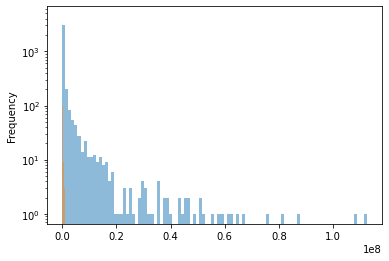

friends_count


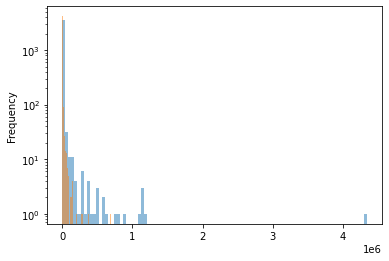

statuses_count


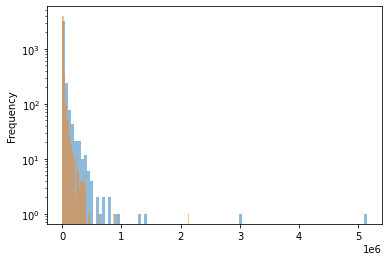

In [8]:
plot_distrib('followers_count')
plot_distrib('friends_count')
plot_distrib('statuses_count')

In [9]:
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

def plot_scatter(colname_1: str, colname_2: str, **kwargs):
    df_train_users.plot.scatter(colname_1, 
                                colname_2,
                                c='label', 
                                alpha=0.05,
                                cmap=cmap,
                                loglog=True,
                                **kwargs)
    plt.show()

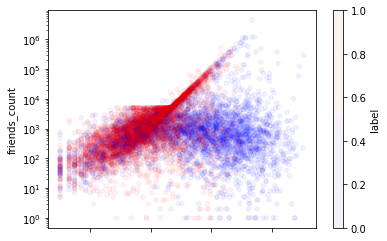

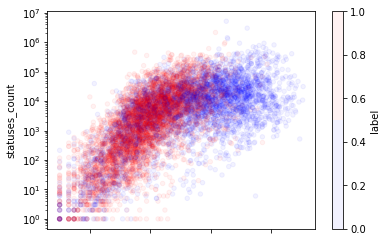

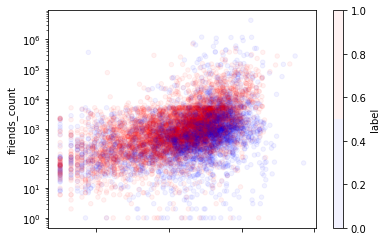

In [10]:
plot_scatter('followers_count', 'friends_count')
plot_scatter('followers_count', 'statuses_count')
plot_scatter('statuses_count', 'friends_count')

## Training

In [10]:
clf_users = get_best_clf(df_train_users)

[I 2022-03-29 12:08:22,665] A new study created in memory with name: no-name-dc1a181e-caec-45c4-8380-8e50dcc4afe0


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:23,574] Trial 2 finished with value: 0.7427580306655794 and parameters: {'lambda_l1': 3.269910774093909e-07, 'lambda_l2': 8.173343862125158e-05, 'num_leaves': 241, 'feature_fraction': 0.5261204062199879, 'bagging_fraction': 0.6185952262509382, 'bagging_freq': 4, 'learning_rate': 0.07031156913794198, 'min_child_samples': 68}. Best is trial 2 with value: 0.7427580306655794.


Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.808354
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.798553


[I 2022-03-29 12:08:23,763] Trial 4 finished with value: 0.7260728719683096 and parameters: {'lambda_l1': 6.042587039787647e-07, 'lambda_l2': 0.03808306349782212, 'num_leaves': 106, 'feature_fraction': 0.4417080396491029, 'bagging_fraction': 0.997060720506079, 'bagging_freq': 3, 'learning_rate': 0.049119892746509596, 'min_child_samples': 84}. Best is trial 2 with value: 0.7427580306655794.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:24,061] Trial 5 finished with value: 0.7389036676603349 and parameters: {'lambda_l1': 2.2957536706587654e-06, 'lambda_l2': 1.247210906468655e-06, 'num_leaves': 229, 'feature_fraction': 0.6057593485552675, 'bagging_fraction': 0.8077545939696207, 'bagging_freq': 5, 'learning_rate': 0.2251821261907184, 'min_child_samples': 52}. Best is trial 2 with value: 0.7427580306655794.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.802615
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:24,437] Trial 3 finished with value: 0.7382308251010378 and parameters: {'lambda_l1': 1.5876539402522359e-06, 'lambda_l2': 0.004042458306657392, 'num_leaves': 77, 'feature_fraction': 0.9570950978290121, 'bagging_fraction': 0.6253670246512765, 'bagging_freq': 7, 'learning_rate': 0.010919288228266905, 'min_child_samples': 11}. Best is trial 2 with value: 0.7427580306655794.
[I 2022-03-29 12:08:24,562] Trial 0 finished with value: 0.7404498687734213 and parameters: {'lambda_l1': 2.9341507401601826e-06, 'lambda_l2': 4.075993405295585e-06, 'num_leaves': 256, 'feature_fraction': 0.63575560280797, 'bagging_fraction': 0.8199876738477276, 'bagging_freq': 5, 'learning_rate': 0.02889519369569524, 'min_child_samples': 44}. Best is trial 2 with value: 0.7427580306655794.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.807278
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.809315


[I 2022-03-29 12:08:24,672] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.5980445350371721, 'lambda_l2': 2.8847405886347004, 'num_leaves': 73, 'feature_fraction': 0.5239262604882149, 'bagging_fraction': 0.9537327841676088, 'bagging_freq': 1, 'learning_rate': 0.005105970542495457, 'min_child_samples': 42}. Best is trial 2 with value: 0.7427580306655794.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.808934
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:25,033] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.004619550533833033, 'lambda_l2': 0.000339965108221659, 'num_leaves': 143, 'feature_fraction': 0.567783653187715, 'bagging_fraction': 0.5440726763322162, 'bagging_freq': 7, 'learning_rate': 0.0006703364753300523, 'min_child_samples': 17}. Best is trial 2 with value: 0.7427580306655794.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.802189
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.81015


[I 2022-03-29 12:08:25,158] Trial 6 finished with value: 0.6999634615298924 and parameters: {'lambda_l1': 5.886229367921696e-07, 'lambda_l2': 5.118686673688981e-08, 'num_leaves': 118, 'feature_fraction': 0.9359423160986663, 'bagging_fraction': 0.914002692296125, 'bagging_freq': 3, 'learning_rate': 0.004229838927503812, 'min_child_samples': 27}. Best is trial 2 with value: 0.7427580306655794.
[I 2022-03-29 12:08:25,284] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 4.930576802455463e-07, 'lambda_l2': 9.503007023217114e-08, 'num_leaves': 44, 'feature_fraction': 0.8359260584966745, 'bagging_fraction': 0.7228962547636728, 'bagging_freq': 7, 'learning_rate': 0.00025603391133568055, 'min_child_samples': 84}. Best is trial 2 with value: 0.7427580306655794.
[I 2022-03-29 12:08:25,331] Trial 8 finished with value: 0.7480070938102941 and parameters: {'lambda_l1': 0.0054448767616545385, 'lambda_l2': 0.016012812652260913, 'num_leaves': 236, 'feature_fraction': 0.9579485354866383,

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.810656
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.808281
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.808639


[I 2022-03-29 12:08:25,645] Trial 7 finished with value: 0.7344900878260057 and parameters: {'lambda_l1': 0.0006338488100877266, 'lambda_l2': 0.0008045287848714416, 'num_leaves': 168, 'feature_fraction': 0.6175253076449344, 'bagging_fraction': 0.4818596488351376, 'bagging_freq': 5, 'learning_rate': 0.011148611435509256, 'min_child_samples': 16}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:25,786] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.000152186943344406, 'lambda_l2': 6.573592553952641e-07, 'num_leaves': 204, 'feature_fraction': 0.5354760726868979, 'bagging_fraction': 0.8492555078647228, 'bagging_freq': 6, 'learning_rate': 0.0033383583624459756, 'min_child_samples': 72}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:25,864] Trial 14 finished with value: 0.7403228753102428 and parameters: {'lambda_l1': 3.5884788491058574e-07, 'lambda_l2': 0.0004023394578412883, 'num_leaves': 30, 'feature_fraction': 0.840447639494816

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.806152
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.812098
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.809754


[I 2022-03-29 12:08:25,958] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.09103523734276889, 'lambda_l2': 1.2973851393260608e-05, 'num_leaves': 110, 'feature_fraction': 0.7878393034740763, 'bagging_fraction': 0.7003587560449387, 'bagging_freq': 1, 'learning_rate': 0.00013172168213140505, 'min_child_samples': 60}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:26,334] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 0.0023852648194307865, 'lambda_l2': 4.77807830156776, 'num_leaves': 181, 'feature_fraction': 0.7763701808472417, 'bagging_fraction': 0.42703554332738314, 'bagging_freq': 1, 'learning_rate': 2.9239681515396142e-05, 'min_child_samples': 29}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.807059
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:26,570] Trial 18 finished with value: 0.5 and parameters: {'lambda_l1': 0.06692559235908105, 'lambda_l2': 0.15002048757213493, 'num_leaves': 198, 'feature_fraction': 0.7748962941782891, 'bagging_fraction': 0.4026998561895787, 'bagging_freq': 3, 'learning_rate': 1.8474391845639127e-05, 'min_child_samples': 64}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:26,664] Trial 19 finished with value: 0.5 and parameters: {'lambda_l1': 1.0378578244562294e-08, 'lambda_l2': 0.09952158421407815, 'num_leaves': 193, 'feature_fraction': 0.7605450647568784, 'bagging_fraction': 0.4114402552268416, 'bagging_freq': 3, 'learning_rate': 2.8095220984593835e-05, 'min_child_samples': 62}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:26,742] Trial 20 finished with value: 0.7372304730840697 and parameters: {'lambda_l1': 0.11331766578348587, 'lambda_l2': 0.17899455981358284, 'num_leaves': 211, 'feature_fraction': 0.7451836003074914, 'bagging_fractio

Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.805834
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.806172
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.804369
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.803742


[I 2022-03-29 12:08:26,836] Trial 10 finished with value: 0.7364440047945602 and parameters: {'lambda_l1': 0.0011897689476609795, 'lambda_l2': 1.1848669185549683e-06, 'num_leaves': 237, 'feature_fraction': 0.6069664147358459, 'bagging_fraction': 0.7748184726050324, 'bagging_freq': 7, 'learning_rate': 0.04018000265640233, 'min_child_samples': 25}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:27,150] Trial 22 finished with value: 0.7415036917222542 and parameters: {'lambda_l1': 1.2623258397135683e-08, 'lambda_l2': 0.07370230081743266, 'num_leaves': 255, 'feature_fraction': 0.42589507626191847, 'bagging_fraction': 0.5648361888598485, 'bagging_freq': 3, 'learning_rate': 0.2142458453933834, 'min_child_samples': 99}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.802299
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:27,354] Trial 21 finished with value: 0.7404632365063876 and parameters: {'lambda_l1': 1.7553476175417573e-08, 'lambda_l2': 0.1152939055597766, 'num_leaves': 206, 'feature_fraction': 0.7219736935714803, 'bagging_fraction': 0.41519912612190657, 'bagging_freq': 3, 'learning_rate': 0.19038052226191332, 'min_child_samples': 31}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:27,511] Trial 25 finished with value: 0.7311570664064415 and parameters: {'lambda_l1': 3.212417007983887e-05, 'lambda_l2': 5.1299190997444265e-05, 'num_leaves': 253, 'feature_fraction': 0.4325902732699528, 'bagging_fraction': 0.5604641288769122, 'bagging_freq': 4, 'learning_rate': 0.061135800341765724, 'min_child_samples': 93}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.802314
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.805833


[I 2022-03-29 12:08:27,589] Trial 26 finished with value: 0.740311735532771 and parameters: {'lambda_l1': 4.0921388751526945e-05, 'lambda_l2': 1.9370096641733132e-05, 'num_leaves': 153, 'feature_fraction': 0.4075160948813131, 'bagging_fraction': 0.5718997230255832, 'bagging_freq': 4, 'learning_rate': 0.12297448009411299, 'min_child_samples': 95}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:27,746] Trial 16 finished with value: 0.7362412608445734 and parameters: {'lambda_l1': 7.131656231766936e-06, 'lambda_l2': 1.0160731530299647e-06, 'num_leaves': 125, 'feature_fraction': 0.8188206737853634, 'bagging_fraction': 0.46125136429244706, 'bagging_freq': 5, 'learning_rate': 0.11090960383938886, 'min_child_samples': 17}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.810508
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.799753
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.808379


[I 2022-03-29 12:08:28,075] Trial 28 finished with value: 0.7390685363669174 and parameters: {'lambda_l1': 8.217302883363802e-05, 'lambda_l2': 4.755953236309419e-05, 'num_leaves': 245, 'feature_fraction': 0.40480825576127216, 'bagging_fraction': 0.5675270666294514, 'bagging_freq': 4, 'learning_rate': 0.08194571418037432, 'min_child_samples': 99}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:28,232] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.0004253767617177329, 'lambda_l2': 0.001417553108429105, 'num_leaves': 234, 'feature_fraction': 0.9768194795690166, 'bagging_fraction': 0.9389323851693306, 'bagging_freq': 5, 'learning_rate': 4.273453027082854e-05, 'min_child_samples': 27}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:28,310] Trial 29 finished with value: 0.7425174114721884 and parameters: {'lambda_l1': 6.047538661161972e-08, 'lambda_l2': 0.007330475030188555, 'num_leaves': 226, 'feature_fraction': 0.400089331846233

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.805978
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.809158
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:28,452] Trial 24 finished with value: 0.7050788473449454 and parameters: {'lambda_l1': 0.0001393542778143708, 'lambda_l2': 4.020239106537789e-05, 'num_leaves': 256, 'feature_fraction': 0.41166576415803213, 'bagging_fraction': 0.5627258134471076, 'bagging_freq': 4, 'learning_rate': 0.29894134433212805, 'min_child_samples': 32}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.77538
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:28,922] Trial 32 finished with value: 0.7245890536090652 and parameters: {'lambda_l1': 3.89580448429224e-08, 'lambda_l2': 0.0030163843324042343, 'num_leaves': 225, 'feature_fraction': 0.497920483533151, 'bagging_fraction': 0.5000360258251761, 'bagging_freq': 2, 'learning_rate': 0.026214830331591336, 'min_child_samples': 72}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.799346
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:29,133] Trial 33 finished with value: 0.7258188850419525 and parameters: {'lambda_l1': 6.79611654854711e-08, 'lambda_l2': 0.009026531813935982, 'num_leaves': 225, 'feature_fraction': 0.4843205219301526, 'bagging_fraction': 0.5003068088561813, 'bagging_freq': 2, 'learning_rate': 0.02522119694385472, 'min_child_samples': 74}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:29,233] Trial 34 finished with value: 0.7292543924142573 and parameters: {'lambda_l1': 7.939870312785128e-08, 'lambda_l2': 0.006152777458622227, 'num_leaves': 222, 'feature_fraction': 0.49914695301136186, 'bagging_fraction': 0.4939286010131779, 'bagging_freq': 2, 'learning_rate': 0.02131177501360045, 'min_child_samples': 74}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.799034
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.794896


[I 2022-03-29 12:08:29,408] Trial 35 finished with value: 0.7237647100761515 and parameters: {'lambda_l1': 5.38286093375302e-08, 'lambda_l2': 0.01636011699987549, 'num_leaves': 220, 'feature_fraction': 0.48604234821004594, 'bagging_fraction': 0.5013081838054645, 'bagging_freq': 2, 'learning_rate': 0.021748195171248447, 'min_child_samples': 73}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.796098
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:30,209] Trial 38 finished with value: 0.7409957178695399 and parameters: {'lambda_l1': 1.357069027283734e-07, 'lambda_l2': 0.8669097293630268, 'num_leaves': 178, 'feature_fraction': 0.679961767651905, 'bagging_fraction': 0.615154614074676, 'bagging_freq': 4, 'learning_rate': 0.11035052039812575, 'min_child_samples': 89}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:30,366] Trial 39 finished with value: 0.5 and parameters: {'lambda_l1': 0.01874124384967552, 'lambda_l2': 0.8810849216398452, 'num_leaves': 174, 'feature_fraction': 0.6651525766010953, 'bagging_fraction': 0.6478192184441411, 'bagging_freq': 4, 'learning_rate': 0.0011250771183339895, 'min_child_samples': 90}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.811471
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.807853


[I 2022-03-29 12:08:30,664] Trial 27 finished with value: 0.7324136333052611 and parameters: {'lambda_l1': 4.2413554334893386e-05, 'lambda_l2': 4.622532034240432e-05, 'num_leaves': 154, 'feature_fraction': 0.8907477499580903, 'bagging_fraction': 0.51451153001054, 'bagging_freq': 4, 'learning_rate': 0.10998009076532345, 'min_child_samples': 6}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.78816


[I 2022-03-29 12:08:30,758] Trial 36 finished with value: 0.7410202253799778 and parameters: {'lambda_l1': 1.1904017867039449e-07, 'lambda_l2': 0.015165220481962756, 'num_leaves': 171, 'feature_fraction': 0.6605417283216864, 'bagging_fraction': 0.6129415628142092, 'bagging_freq': 6, 'learning_rate': 0.02423351210426798, 'min_child_samples': 42}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.812004
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:31,244] Trial 41 finished with value: 0.7309164472130504 and parameters: {'lambda_l1': 1.2717037285124648e-05, 'lambda_l2': 0.00021180621099377967, 'num_leaves': 243, 'feature_fraction': 0.45285738418814453, 'bagging_fraction': 0.6297151828588268, 'bagging_freq': 6, 'learning_rate': 0.058660644175517966, 'min_child_samples': 100}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.806772
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:31,793] Trial 43 finished with value: 0.7398037616800568 and parameters: {'lambda_l1': 2.975566910377569e-06, 'lambda_l2': 0.0002283548210324027, 'num_leaves': 242, 'feature_fraction': 0.44862739282492464, 'bagging_fraction': 0.6019625308358741, 'bagging_freq': 6, 'learning_rate': 0.05869315837980708, 'min_child_samples': 99}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:31,934] Trial 40 finished with value: 0.5 and parameters: {'lambda_l1': 0.023831727679051774, 'lambda_l2': 0.789538246723706, 'num_leaves': 256, 'feature_fraction': 0.4532782748778018, 'bagging_fraction': 0.6348248798196862, 'bagging_freq': 6, 'learning_rate': 0.001136581914162824, 'min_child_samples': 37}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.806189
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.787642


[I 2022-03-29 12:08:32,185] Trial 23 finished with value: 0.7157797175843615 and parameters: {'lambda_l1': 1.0343375526945805e-08, 'lambda_l2': 3.018259328254619e-05, 'num_leaves': 255, 'feature_fraction': 0.4497198694829385, 'bagging_fraction': 0.5634604805666259, 'bagging_freq': 4, 'learning_rate': 0.2220125110354029, 'min_child_samples': 5}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.776343
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.800741


[I 2022-03-29 12:08:32,248] Trial 42 finished with value: 0.7353032915814472 and parameters: {'lambda_l1': 7.942820685285458e-06, 'lambda_l2': 0.03158575675011089, 'num_leaves': 242, 'feature_fraction': 0.4608416738669373, 'bagging_fraction': 0.6142730118644818, 'bagging_freq': 3, 'learning_rate': 0.05088946973111216, 'min_child_samples': 48}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:32,404] Trial 44 finished with value: 0.7041096867048984 and parameters: {'lambda_l1': 0.007577610584522895, 'lambda_l2': 0.0385011912288906, 'num_leaves': 252, 'feature_fraction': 0.5676971612313034, 'bagging_fraction': 0.5299625204397491, 'bagging_freq': 3, 'learning_rate': 0.00663990167025626, 'min_child_samples': 50}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.807453
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.781132


[I 2022-03-29 12:08:32,608] Trial 30 finished with value: 0.726315719117195 and parameters: {'lambda_l1': 7.605538917965959e-08, 'lambda_l2': 0.006641213872255333, 'num_leaves': 229, 'feature_fraction': 0.47500637669075646, 'bagging_fraction': 0.5161960536182174, 'bagging_freq': 2, 'learning_rate': 0.1085753788333226, 'min_child_samples': 5}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:32,780] Trial 31 finished with value: 0.7256918915787739 and parameters: {'lambda_l1': 3.5295237675268965e-08, 'lambda_l2': 0.008770452806609416, 'num_leaves': 226, 'feature_fraction': 0.47323950383562124, 'bagging_fraction': 0.5070374341087394, 'bagging_freq': 2, 'learning_rate': 0.02190789578380929, 'min_child_samples': 5}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.786623
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.805006


[I 2022-03-29 12:08:32,874] Trial 45 finished with value: 0.7245110751667624 and parameters: {'lambda_l1': 0.010852385153034796, 'lambda_l2': 0.03199770132617753, 'num_leaves': 256, 'feature_fraction': 0.5621011330276762, 'bagging_fraction': 0.4490724398961569, 'bagging_freq': 3, 'learning_rate': 0.007924804544670488, 'min_child_samples': 54}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:32,953] Trial 46 finished with value: 0.649081413949675 and parameters: {'lambda_l1': 1.6401820246689314, 'lambda_l2': 0.043824004819199354, 'num_leaves': 93, 'feature_fraction': 0.5727140297348774, 'bagging_fraction': 0.5328046159897355, 'bagging_freq': 3, 'learning_rate': 0.006902759109723964, 'min_child_samples': 55}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.8026
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:33,172] Trial 47 finished with value: 0.6851163661154704 and parameters: {'lambda_l1': 0.7900490607278825, 'lambda_l2': 0.0017192752919173103, 'num_leaves': 92, 'feature_fraction': 0.5447509232995779, 'bagging_fraction': 0.5310511706060412, 'bagging_freq': 3, 'learning_rate': 0.006060467017261074, 'min_child_samples': 80}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.801995
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.807809


[I 2022-03-29 12:08:33,345] Trial 37 finished with value: 0.5078357194736678 and parameters: {'lambda_l1': 0.010293605131549588, 'lambda_l2': 0.6009070276676728, 'num_leaves': 174, 'feature_fraction': 0.662127598687514, 'bagging_fraction': 0.6270962133371258, 'bagging_freq': 6, 'learning_rate': 0.0019759890798898005, 'min_child_samples': 5}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:33,753] Trial 48 finished with value: 0.7051367741877989 and parameters: {'lambda_l1': 2.1115753354634484e-07, 'lambda_l2': 0.032032146742628304, 'num_leaves': 215, 'feature_fraction': 0.5581876377145374, 'bagging_fraction': 0.6684166988591734, 'bagging_freq': 5, 'learning_rate': 0.0069662844326929384, 'min_child_samples': 56}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.804749
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:34,004] Trial 52 finished with value: 0.6523654203483632 and parameters: {'lambda_l1': 1.646651365953592e-06, 'lambda_l2': 0.0012965139481323441, 'num_leaves': 88, 'feature_fraction': 0.6264828991900586, 'bagging_fraction': 0.753102395897657, 'bagging_freq': 5, 'learning_rate': 0.00230376658452628, 'min_child_samples': 81}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.804637
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:34,271] Trial 51 finished with value: 0.7346549565325883 and parameters: {'lambda_l1': 1.6938516946649607e-07, 'lambda_l2': 0.0032659461369420697, 'num_leaves': 187, 'feature_fraction': 0.5777207346006307, 'bagging_fraction': 0.7425292237113803, 'bagging_freq': 5, 'learning_rate': 0.012615404896768436, 'min_child_samples': 57}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:34,349] Trial 49 finished with value: 0.7347819499957668 and parameters: {'lambda_l1': 1.9282674087154287e-07, 'lambda_l2': 0.0025139095446144984, 'num_leaves': 187, 'feature_fraction': 0.5585709720517352, 'bagging_fraction': 0.7366472736110244, 'bagging_freq': 5, 'learning_rate': 0.16278721515451117, 'min_child_samples': 43}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.804148
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.804746
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:34,553] Trial 50 finished with value: 0.7461177875510758 and parameters: {'lambda_l1': 2.7110997624950294e-07, 'lambda_l2': 0.023814494723303326, 'num_leaves': 86, 'feature_fraction': 0.5525678906006753, 'bagging_fraction': 0.4548970153562455, 'bagging_freq': 5, 'learning_rate': 0.037353757611604, 'min_child_samples': 20}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.807319
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.807693


[I 2022-03-29 12:08:34,851] Trial 54 finished with value: 0.5934070341010869 and parameters: {'lambda_l1': 2.0624496952716723e-07, 'lambda_l2': 0.0004930996899746554, 'num_leaves': 214, 'feature_fraction': 0.6361706912771233, 'bagging_fraction': 0.6695614080158006, 'bagging_freq': 5, 'learning_rate': 0.0025084825693077223, 'min_child_samples': 42}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:35,133] Trial 55 finished with value: 0.7407662384536207 and parameters: {'lambda_l1': 2.97225022233048e-07, 'lambda_l2': 4.932578673394886e-06, 'num_leaves': 190, 'feature_fraction': 0.9109202128780312, 'bagging_fraction': 0.7487016169324396, 'bagging_freq': 5, 'learning_rate': 0.014452952167310617, 'min_child_samples': 42}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.810827
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.81355


[I 2022-03-29 12:08:35,164] Trial 58 finished with value: 0.7433038797616979 and parameters: {'lambda_l1': 7.717984014864457e-07, 'lambda_l2': 0.2695138334705472, 'num_leaves': 139, 'feature_fraction': 0.6782807535018385, 'bagging_fraction': 0.592414542936199, 'bagging_freq': 4, 'learning_rate': 0.18452190814839886, 'min_child_samples': 88}. Best is trial 8 with value: 0.7480070938102941.
[I 2022-03-29 12:08:35,244] Trial 59 finished with value: 0.7450907000681755 and parameters: {'lambda_l1': 4.3856835709934083e-07, 'lambda_l2': 0.2875623370431873, 'num_leaves': 140, 'feature_fraction': 0.7060500984220542, 'bagging_fraction': 0.5935553729610413, 'bagging_freq': 4, 'learning_rate': 0.039164059218328474, 'min_child_samples': 89}. Best is trial 8 with value: 0.7480070938102941.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.811321


[I 2022-03-29 12:08:35,545] Trial 56 finished with value: 0.7398416369234608 and parameters: {'lambda_l1': 8.773054274250934e-07, 'lambda_l2': 0.0007412266391285686, 'num_leaves': 140, 'feature_fraction': 0.9333807917403558, 'bagging_fraction': 0.7549563392708304, 'bagging_freq': 5, 'learning_rate': 0.035535182722424126, 'min_child_samples': 43}. Best is trial 8 with value: 0.7480070938102941.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.808928


[I 2022-03-29 12:08:35,666] Trial 61 finished with value: 0.7502127697497114 and parameters: {'lambda_l1': 9.126869061068554e-07, 'lambda_l2': 3.4302831982437234e-06, 'num_leaves': 25, 'feature_fraction': 0.5936924717853151, 'bagging_fraction': 0.4657134703428757, 'bagging_freq': 7, 'learning_rate': 0.035014999344003137, 'min_child_samples': 23}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.810991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.803025


[I 2022-03-29 12:08:35,886] Trial 53 finished with value: 0.7037799492917329 and parameters: {'lambda_l1': 1.3114267148567816e-06, 'lambda_l2': 0.0011874718606048192, 'num_leaves': 190, 'feature_fraction': 0.632692967553001, 'bagging_fraction': 0.6765345339215414, 'bagging_freq': 5, 'learning_rate': 0.003171082667850288, 'min_child_samples': 21}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:35,964] Trial 60 finished with value: 0.7386496807339777 and parameters: {'lambda_l1': 8.900748898943112e-07, 'lambda_l2': 0.0006412876802318652, 'num_leaves': 54, 'feature_fraction': 0.5276151770887952, 'bagging_fraction': 0.5950508863002664, 'bagging_freq': 7, 'learning_rate': 0.03330338730381211, 'min_child_samples': 22}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.811674
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:36,215] Trial 67 finished with value: 0.7384714442944289 and parameters: {'lambda_l1': 3.7199059658927178e-06, 'lambda_l2': 0.3432440254663579, 'num_leaves': 4, 'feature_fraction': 0.7080886798095838, 'bagging_fraction': 0.43478263963618097, 'bagging_freq': 7, 'learning_rate': 0.03444282357277329, 'min_child_samples': 14}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.802048
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:36,591] Trial 68 finished with value: 0.7450149495813672 and parameters: {'lambda_l1': 3.1032401872341826e-06, 'lambda_l2': 0.304556602345289, 'num_leaves': 23, 'feature_fraction': 0.874614013299787, 'bagging_fraction': 0.4730731047327297, 'bagging_freq': 4, 'learning_rate': 0.07600341881949448, 'min_child_samples': 88}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:36,685] Trial 63 finished with value: 0.7362657683550113 and parameters: {'lambda_l1': 5.422188701060279e-07, 'lambda_l2': 0.3265734627110176, 'num_leaves': 56, 'feature_fraction': 0.5111700952537741, 'bagging_fraction': 0.46673176462991356, 'bagging_freq': 4, 'learning_rate': 0.031770476853476594, 'min_child_samples': 21}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.816327
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.811524
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:36,811] Trial 62 finished with value: 0.7437717504155137 and parameters: {'lambda_l1': 1.2828035957369107e-06, 'lambda_l2': 0.19740623868846077, 'num_leaves': 62, 'feature_fraction': 0.5263678038599017, 'bagging_fraction': 0.44657735137581994, 'bagging_freq': 4, 'learning_rate': 0.0384885565288624, 'min_child_samples': 23}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:36,968] Trial 65 finished with value: 0.7374332170340565 and parameters: {'lambda_l1': 6.848291068838816e-07, 'lambda_l2': 0.3434226395591184, 'num_leaves': 57, 'feature_fraction': 0.9971853562465183, 'bagging_fraction': 0.4571439719985255, 'bagging_freq': 4, 'learning_rate': 0.07646277694630539, 'min_child_samples': 20}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.806752
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.80234


[I 2022-03-29 12:08:37,062] Trial 66 finished with value: 0.7441906060484537 and parameters: {'lambda_l1': 8.334547102634779e-07, 'lambda_l2': 1.4851192496108613e-08, 'num_leaves': 55, 'feature_fraction': 0.519818512684953, 'bagging_fraction': 0.46950203362804904, 'bagging_freq': 7, 'learning_rate': 0.03878379772788569, 'min_child_samples': 22}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.808014
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.80966
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:37,218] Trial 57 finished with value: 0.7442151135588915 and parameters: {'lambda_l1': 9.72299285648814e-07, 'lambda_l2': 0.0004024825200772874, 'num_leaves': 192, 'feature_fraction': 0.9192617281462652, 'bagging_fraction': 0.6767478041903401, 'bagging_freq': 5, 'learning_rate': 0.013021659695308418, 'min_child_samples': 20}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:37,313] Trial 71 finished with value: 0.7486910761470629 and parameters: {'lambda_l1': 0.000695423395527765, 'lambda_l2': 2.955841651625631e-07, 'num_leaves': 7, 'feature_fraction': 0.8708324367566598, 'bagging_fraction': 0.4734253414918319, 'bagging_freq': 4, 'learning_rate': 0.07095892447479846, 'min_child_samples': 87}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.813854
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.807448


[I 2022-03-29 12:08:37,470] Trial 64 finished with value: 0.7420473128628782 and parameters: {'lambda_l1': 9.555802078926828e-07, 'lambda_l2': 0.22898527417578113, 'num_leaves': 134, 'feature_fraction': 0.5953052611950567, 'bagging_fraction': 0.4599043896099506, 'bagging_freq': 4, 'learning_rate': 0.03463584376294469, 'min_child_samples': 22}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:37,549] Trial 70 finished with value: 0.7437338751721096 and parameters: {'lambda_l1': 4.811207389177868e-07, 'lambda_l2': 3.0810832007573237, 'num_leaves': 17, 'feature_fraction': 0.6009831117651548, 'bagging_fraction': 0.46320076285030504, 'bagging_freq': 4, 'learning_rate': 0.07648597177344411, 'min_child_samples': 87}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:37,595] Trial 72 finished with value: 0.7459907940878973 and parameters: {'lambda_l1': 1.5551453964417057e-05, 'lambda_l2': 2.885120765254454, 'num_leaves': 11, 'feature_fraction': 0.98215902

Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.815286
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.812195


[I 2022-03-29 12:08:37,752] Trial 69 finished with value: 0.7463584067444669 and parameters: {'lambda_l1': 5.935069009009512e-07, 'lambda_l2': 5.350627893698469e-07, 'num_leaves': 61, 'feature_fraction': 0.6012202795533238, 'bagging_fraction': 0.47293555485607675, 'bagging_freq': 4, 'learning_rate': 0.07192802901295593, 'min_child_samples': 11}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.805188
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:37,972] Trial 73 finished with value: 0.7496424131431552 and parameters: {'lambda_l1': 1.679483280781367e-05, 'lambda_l2': 8.895201583247605, 'num_leaves': 24, 'feature_fraction': 0.5982162577621252, 'bagging_fraction': 0.43182821861140597, 'bagging_freq': 4, 'learning_rate': 0.15658814736773852, 'min_child_samples': 12}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:38,065] Trial 74 finished with value: 0.7392066696075679 and parameters: {'lambda_l1': 0.0011336974044114983, 'lambda_l2': 1.0717863713138525e-08, 'num_leaves': 27, 'feature_fraction': 0.5889975409747553, 'bagging_fraction': 0.47485221234082725, 'bagging_freq': 7, 'learning_rate': 0.014568060338924332, 'min_child_samples': 10}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.807117
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.806487
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:38,269] Trial 75 finished with value: 0.7039826932417198 and parameters: {'lambda_l1': 0.002012716048025129, 'lambda_l2': 1.0264546530252274e-08, 'num_leaves': 28, 'feature_fraction': 0.8568457190081186, 'bagging_fraction': 0.48442651398215664, 'bagging_freq': 7, 'learning_rate': 0.009680534051873637, 'min_child_samples': 12}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:38,332] Trial 76 finished with value: 0.7392957878273424 and parameters: {'lambda_l1': 0.001061349535080353, 'lambda_l2': 3.4311916660559463e-07, 'num_leaves': 26, 'feature_fraction': 0.8611890480912252, 'bagging_fraction': 0.8315016738839583, 'bagging_freq': 4, 'learning_rate': 0.017274634336534474, 'min_child_samples': 10}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.808171
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.811208


[I 2022-03-29 12:08:38,473] Trial 77 finished with value: 0.7408932319167991 and parameters: {'lambda_l1': 0.0026759645604066923, 'lambda_l2': 2.6881636240375645e-07, 'num_leaves': 20, 'feature_fraction': 0.850282373623422, 'bagging_fraction': 0.8166693718499402, 'bagging_freq': 4, 'learning_rate': 0.014216105693665161, 'min_child_samples': 10}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.813845
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:38,708] Trial 78 finished with value: 0.7455719384549575 and parameters: {'lambda_l1': 0.0016352015726181337, 'lambda_l2': 1.3250364205180005e-08, 'num_leaves': 33, 'feature_fraction': 0.9010765370813599, 'bagging_fraction': 0.47863586403236313, 'bagging_freq': 4, 'learning_rate': 0.01488171751006032, 'min_child_samples': 9}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:38,787] Trial 80 finished with value: 0.7476639886641624 and parameters: {'lambda_l1': 0.0011745928899121153, 'lambda_l2': 2.3009047094024493e-07, 'num_leaves': 30, 'feature_fraction': 0.8669032743860424, 'bagging_fraction': 0.47774943771870754, 'bagging_freq': 4, 'learning_rate': 0.016110606047619342, 'min_child_samples': 11}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:38,833] Trial 79 finished with value: 0.7278329568088548 and parameters: {'lambda_l1': 0.0008510650469571045, 'lambda_l2': 1.769218791645119e-07, 'num_leaves': 34, 'feature_fraction': 

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.811436
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.812195
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.807628
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:39,210] Trial 87 finished with value: 0.7465611506944536 and parameters: {'lambda_l1': 0.0002680653352822817, 'lambda_l2': 7.936854630699163e-08, 'num_leaves': 6, 'feature_fraction': 0.9616400791284836, 'bagging_fraction': 0.4364127493635393, 'bagging_freq': 4, 'learning_rate': 0.14145703072263963, 'min_child_samples': 16}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:39,289] Trial 81 finished with value: 0.7353166593144136 and parameters: {'lambda_l1': 2.0133589539177006e-05, 'lambda_l2': 3.4211608726031587e-07, 'num_leaves': 41, 'feature_fraction': 0.9677469043221628, 'bagging_fraction': 0.43522050164758697, 'bagging_freq': 4, 'learning_rate': 0.14576364787186522, 'min_child_samples': 10}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:39,289] Trial 82 finished with value: 0.7388145494405605 and parameters: {'lambda_l1': 0.00022884778537647911, 'lambda_l2': 5.14226854796012e-07, 'num_leaves': 39, 'feature_fraction': 0.

Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.810105
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.802057
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.795754
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:39,539] Trial 83 finished with value: 0.7442797242682281 and parameters: {'lambda_l1': 0.00022846685196937803, 'lambda_l2': 1.8560460865888552e-07, 'num_leaves': 41, 'feature_fraction': 0.9922216758561427, 'bagging_fraction': 0.40519144779379135, 'bagging_freq': 4, 'learning_rate': 0.1434364044648245, 'min_child_samples': 17}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:39,633] Trial 84 finished with value: 0.7438742363682543 and parameters: {'lambda_l1': 0.0003020684533935536, 'lambda_l2': 8.34146717167042, 'num_leaves': 41, 'feature_fraction': 0.966683896929089, 'bagging_fraction': 0.4016063865412042, 'bagging_freq': 4, 'learning_rate': 0.14989720754390012, 'min_child_samples': 16}. Best is trial 61 with value: 0.7502127697497114.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.800471
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.804167
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:39,728] Trial 85 finished with value: 0.7450283173143333 and parameters: {'lambda_l1': 0.0004932952443041618, 'lambda_l2': 6.778740771620993, 'num_leaves': 38, 'feature_fraction': 0.8117497124283384, 'bagging_fraction': 0.4303252562737933, 'bagging_freq': 4, 'learning_rate': 0.15425424819353137, 'min_child_samples': 17}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:39,806] Trial 91 finished with value: 0.5 and parameters: {'lambda_l1': 0.00043136895346212995, 'lambda_l2': 9.426800954245357, 'num_leaves': 2, 'feature_fraction': 0.9436437021911822, 'bagging_fraction': 0.40215728296236897, 'bagging_freq': 3, 'learning_rate': 0.00035025946169542577, 'min_child_samples': 17}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:39,822] Trial 90 finished with value: 0.7414257132799515 and parameters: {'lambda_l1': 0.0004698727637285961, 'lambda_l2': 9.980379138787816, 'num_leaves': 2, 'feature_fraction': 0.9518475629172405, 'bagging

Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.804339
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.798176
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.737335
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.795696


[I 2022-03-29 12:08:39,900] Trial 89 finished with value: 0.5 and parameters: {'lambda_l1': 0.0002873383045508781, 'lambda_l2': 2.056940835829812e-06, 'num_leaves': 6, 'feature_fraction': 0.9619928774904887, 'bagging_fraction': 0.43416115022130924, 'bagging_freq': 4, 'learning_rate': 0.000278534648797464, 'min_child_samples': 18}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:40,072] Trial 86 finished with value: 0.7457501748945063 and parameters: {'lambda_l1': 0.00015037409508184097, 'lambda_l2': 9.313723402209916, 'num_leaves': 40, 'feature_fraction': 0.9538512610236979, 'bagging_fraction': 0.403361133661808, 'bagging_freq': 4, 'learning_rate': 0.14700475081404174, 'min_child_samples': 17}. Best is trial 61 with value: 0.7502127697497114.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.805196
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.811111
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:40,182] Trial 88 finished with value: 0.7362412608445734 and parameters: {'lambda_l1': 0.0002786353748742062, 'lambda_l2': 9.526282704605906, 'num_leaves': 40, 'feature_fraction': 0.9587381781639139, 'bagging_fraction': 0.42756180018906853, 'bagging_freq': 4, 'learning_rate': 0.15067577261989049, 'min_child_samples': 17}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:40,308] Trial 92 finished with value: 0.7484504569536718 and parameters: {'lambda_l1': 0.0005295239320917832, 'lambda_l2': 6.9783533248727e-08, 'num_leaves': 9, 'feature_fraction': 0.8187642229340899, 'bagging_fraction': 0.4227967536312006, 'bagging_freq': 3, 'learning_rate': 0.25949761605746285, 'min_child_samples': 27}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:40,370] Trial 93 finished with value: 0.7398282691904946 and parameters: {'lambda_l1': 9.566462680440856e-05, 'lambda_l2': 5.360097979094097e-08, 'num_leaves': 9, 'feature_fraction': 0.931908939

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.805986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.808203


[I 2022-03-29 12:08:40,465] Trial 94 finished with value: 0.7420851881062824 and parameters: {'lambda_l1': 9.992651387389018e-05, 'lambda_l2': 5.202225575258497e-08, 'num_leaves': 10, 'feature_fraction': 0.9349753196961192, 'bagging_fraction': 0.4192439552937014, 'bagging_freq': 3, 'learning_rate': 0.053958801518757794, 'min_child_samples': 33}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:40,480] Trial 95 finished with value: 0.7365442627918064 and parameters: {'lambda_l1': 0.00422484602836483, 'lambda_l2': 1.559402760682864e-06, 'num_leaves': 8, 'feature_fraction': 0.9245924311158543, 'bagging_fraction': 0.5166085044630483, 'bagging_freq': 5, 'learning_rate': 0.048489768003613945, 'min_child_samples': 26}. Best is trial 61 with value: 0.7502127697497114.
[I 2022-03-29 12:08:40,543] Trial 97 finished with value: 0.743847500902322 and parameters: {'lambda_l1': 7.623056281849154e-05, 'lambda_l2': 5.657908573323813e-08, 'num_leaves': 11, 'feature_fraction': 0.9343

Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.808246
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.811839
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.81096
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.812979
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.815302
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.811154
{'lambda_l1': 9.126869061068554e-07, 'lambda_l2': 3.4302831982437234e-06, 'num_leaves': 25, 'feature_fraction': 0.5936924717853151, 'bagging_fraction': 0.4657134703428757, 'bagging_freq': 7, 'learning_rate': 0.035014999344003137, 'min_child_samples': 23} -> 0.7502127697497114
[LightGBM] [Warning] feature_fraction is set=0.5936924717853151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936924717853151
[LightGBM] [Warning] lambda_l1 is set=9.126869061068554e-07, reg_alpha=0.0 will be ignored. Current value: l

AUROC: 0.7433759208103131
Accuracy: 0.7557058326289096


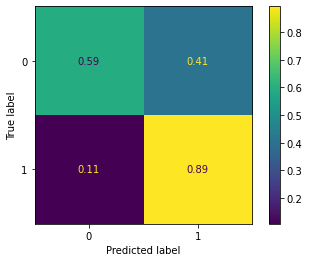

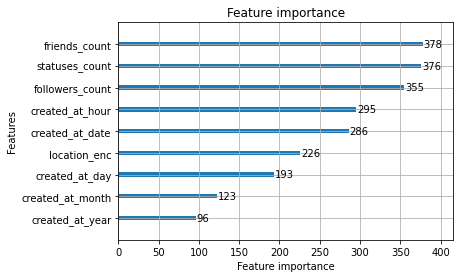

In [11]:
eval_clf(clf_users, df_test_users)

## Feature engineering

In [12]:
def add_avg(df: pd.DataFrame):
    df['avg_daily_followers'] = np.round(df['followers_count'] / df['created_at_date'], 3)
    df['avg_daily_friends'] = np.round(df['friends_count'] / df['created_at_date'], 3)
    df['avg_daily_statuses'] = np.round(df['statuses_count'] / df['created_at_date'], 3)
    return df

df_train_users_fe = add_avg(df_train_users)
df_test_users_fe = add_avg(df_test_users)

In [13]:
clf_users_fe = get_best_clf(df_train_users_fe)

[I 2022-03-29 12:08:41,359] A new study created in memory with name: no-name-92c535bb-b9b2-4350-91fa-59b80bb17ac5


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:42,111] Trial 6 finished with value: 0.7242949634838094 and parameters: {'lambda_l1': 0.004620618935001767, 'lambda_l2': 1.6475686169290964, 'num_leaves': 118, 'feature_fraction': 0.6294360014017264, 'bagging_fraction': 0.6324940917884506, 'bagging_freq': 6, 'learning_rate': 0.004720524535626365, 'min_child_samples': 95}. Best is trial 6 with value: 0.7242949634838094.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.80758
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:42,378] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 1.0991236859583587e-07, 'lambda_l2': 0.29651681968872445, 'num_leaves': 35, 'feature_fraction': 0.7490154693646025, 'bagging_fraction': 0.5676291327696651, 'bagging_freq': 3, 'learning_rate': 0.00041774040122335504, 'min_child_samples': 65}. Best is trial 6 with value: 0.7242949634838094.
[I 2022-03-29 12:08:42,550] Trial 4 finished with value: 0.7464341572312752 and parameters: {'lambda_l1': 0.0004404901571022428, 'lambda_l2': 0.5363874954047085, 'num_leaves': 119, 'feature_fraction': 0.5254476887315627, 'bagging_fraction': 0.9342733392074439, 'bagging_freq': 4, 'learning_rate': 0.042567107067353276, 'min_child_samples': 88}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.807984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.81395


[I 2022-03-29 12:08:42,582] Trial 0 finished with value: 0.737609225518111 and parameters: {'lambda_l1': 0.00013501194539407857, 'lambda_l2': 2.553879163301301, 'num_leaves': 152, 'feature_fraction': 0.6690631665183484, 'bagging_fraction': 0.9734269999571391, 'bagging_freq': 7, 'learning_rate': 0.012015183327325029, 'min_child_samples': 74}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.812477
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:42,770] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.0011631608911674386, 'lambda_l2': 0.06674272586349538, 'num_leaves': 43, 'feature_fraction': 0.9150529036875965, 'bagging_fraction': 0.9469118159764436, 'bagging_freq': 3, 'learning_rate': 1.7454161821249074e-05, 'min_child_samples': 5}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.813206
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:43,131] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.00014222874376651913, 'lambda_l2': 0.0005878008502667156, 'num_leaves': 113, 'feature_fraction': 0.9628360873754144, 'bagging_fraction': 0.8670546196601324, 'bagging_freq': 3, 'learning_rate': 0.000303802632412301, 'min_child_samples': 88}. Best is trial 4 with value: 0.7464341572312752.
[I 2022-03-29 12:08:43,159] Trial 2 finished with value: 0.6428431385654639 and parameters: {'lambda_l1': 4.345599661035604e-08, 'lambda_l2': 0.00038634903637740664, 'num_leaves': 78, 'feature_fraction': 0.4523142832645227, 'bagging_fraction': 0.9954771435186269, 'bagging_freq': 2, 'learning_rate': 0.003471870602507278, 'min_child_samples': 35}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.809748
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.80975
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:43,460] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 0.10343947036356634, 'lambda_l2': 4.1134824341431523e-07, 'num_leaves': 111, 'feature_fraction': 0.9592651687342861, 'bagging_fraction': 0.7972907890099128, 'bagging_freq': 7, 'learning_rate': 0.00010849741012753872, 'min_child_samples': 36}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.806348
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:43,930] Trial 3 finished with value: 0.7394495167564533 and parameters: {'lambda_l1': 3.384877343575773e-08, 'lambda_l2': 6.701407338411476e-06, 'num_leaves': 205, 'feature_fraction': 0.6453173480930776, 'bagging_fraction': 0.6445520003875019, 'bagging_freq': 3, 'learning_rate': 0.062013152978501115, 'min_child_samples': 25}. Best is trial 4 with value: 0.7464341572312752.
[I 2022-03-29 12:08:43,962] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.000450024926831746, 'lambda_l2': 1.663731570151576e-08, 'num_leaves': 156, 'feature_fraction': 0.9850751098612244, 'bagging_fraction': 0.40931413513847875, 'bagging_freq': 5, 'learning_rate': 1.0136790747302441e-05, 'min_child_samples': 88}. Best is trial 4 with value: 0.7464341572312752.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.807552
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.8037
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.808552
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 12:08:44,072] Trial 13 finished with value: 0.7336278690496878 and parameters: {'lambda_l1': 2.731274809129348e-07, 'lambda_l2': 7.531411999449139, 'num_leaves': 227, 'feature_fraction': 0.46847334167932175, 'bagging_fraction': 0.7170876591882349, 'bagging_freq': 7, 'learning_rate': 0.013410530460648733, 'min_child_samples': 44}. Best is trial 4 with value: 0.7464341572312752.
[I 2022-03-29 12:08:44,181] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 0.0001483712888398169, 'lambda_l2': 0.00017374734473644653, 'num_leaves': 210, 'feature_fraction': 0.4994573977016676, 'bagging_fraction': 0.7315049982047099, 'bagging_freq': 2, 'learning_rate': 1.4055043188948269e-05, 'min_child_samples': 74}. Best is trial 4 with value: 0.7464341572312752.



Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.81091
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:44,448] Trial 10 finished with value: 0.7323846698838344 and parameters: {'lambda_l1': 3.4738742983741525e-08, 'lambda_l2': 7.876712502152453e-06, 'num_leaves': 89, 'feature_fraction': 0.5293041468202111, 'bagging_fraction': 0.6224184624235067, 'bagging_freq': 1, 'learning_rate': 0.009281816496656617, 'min_child_samples': 14}. Best is trial 4 with value: 0.7464341572312752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.809763
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.810244


[I 2022-03-29 12:08:44,511] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.2361709964128935e-05, 'lambda_l2': 1.3221283943084983e-05, 'num_leaves': 107, 'feature_fraction': 0.49085465264331957, 'bagging_fraction': 0.7613331699591293, 'bagging_freq': 3, 'learning_rate': 2.5194878763754238e-05, 'min_child_samples': 30}. Best is trial 4 with value: 0.7464341572312752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:44,903] Trial 18 finished with value: 0.7522535769825462 and parameters: {'lambda_l1': 8.66686612240374, 'lambda_l2': 7.3785954215409375e-06, 'num_leaves': 218, 'feature_fraction': 0.5664097115631022, 'bagging_fraction': 0.529165611098365, 'bagging_freq': 1, 'learning_rate': 0.2755117823214519, 'min_child_samples': 17}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.811687
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:45,201] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.35338401141253034, 'lambda_l2': 0.003522780479875015, 'num_leaves': 200, 'feature_fraction': 0.5435545978919445, 'bagging_fraction': 0.8858508563353804, 'bagging_freq': 3, 'learning_rate': 0.0003097340772484271, 'min_child_samples': 28}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:45,279] Trial 17 finished with value: 0.7414012057695136 and parameters: {'lambda_l1': 1.47892808270445, 'lambda_l2': 0.01013035036781603, 'num_leaves': 238, 'feature_fraction': 0.42661457741660647, 'bagging_fraction': 0.771191106531032, 'bagging_freq': 1, 'learning_rate': 0.1192977726454476, 'min_child_samples': 65}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.810477
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.802698
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:45,530] Trial 21 finished with value: 0.7314756640421352 and parameters: {'lambda_l1': 1.5376861409851112, 'lambda_l2': 0.011794442932700266, 'num_leaves': 191, 'feature_fraction': 0.7838553378057805, 'bagging_fraction': 0.5236999819225009, 'bagging_freq': 5, 'learning_rate': 0.22098245582379922, 'min_child_samples': 55}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.805406
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.808813


[I 2022-03-29 12:08:45,608] Trial 16 finished with value: 0.6522384268851845 and parameters: {'lambda_l1': 0.01708053968739896, 'lambda_l2': 1.3012523081879303e-05, 'num_leaves': 100, 'feature_fraction': 0.7386617779703981, 'bagging_fraction': 0.570893564730066, 'bagging_freq': 3, 'learning_rate': 0.0017790933915927197, 'min_child_samples': 36}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:45,734] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.47596284664230193, 'lambda_l2': 1.100665087347373e-06, 'num_leaves': 244, 'feature_fraction': 0.5611562764814467, 'bagging_fraction': 0.732404268606546, 'bagging_freq': 6, 'learning_rate': 0.00022404304850127512, 'min_child_samples': 16}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.80911
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:45,985] Trial 22 finished with value: 0.741211829552493 and parameters: {'lambda_l1': 0.3024425991601004, 'lambda_l2': 0.007511855176274627, 'num_leaves': 251, 'feature_fraction': 0.5811110935340533, 'bagging_fraction': 0.45084563257284715, 'bagging_freq': 5, 'learning_rate': 0.2941911942465986, 'min_child_samples': 55}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:46,079] Trial 24 finished with value: 0.7487801943668373 and parameters: {'lambda_l1': 8.758600598517223, 'lambda_l2': 1.7903626911552006e-07, 'num_leaves': 167, 'feature_fraction': 0.7587758759470303, 'bagging_fraction': 0.4785504259448031, 'bagging_freq': 5, 'learning_rate': 0.20017000300414173, 'min_child_samples': 52}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:46,110] Trial 23 finished with value: 0.7378008296906262 and parameters: {'lambda_l1': 7.09599236248925, 'lambda_l2': 0.01462426593189423, 'num_leaves': 253, 'feature_fraction': 0.77337056342569

Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.799066
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.806162Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.799514


[I 2022-03-29 12:08:46,330] Trial 26 finished with value: 0.7471693825444143 and parameters: {'lambda_l1': 8.875242394777695, 'lambda_l2': 1.879322349654693e-07, 'num_leaves': 256, 'feature_fraction': 0.586737974036183, 'bagging_fraction': 0.4392283888913842, 'bagging_freq': 5, 'learning_rate': 0.05744523136132586, 'min_child_samples': 51}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:46,408] Trial 27 finished with value: 0.7466369011812621 and parameters: {'lambda_l1': 9.100843767973503, 'lambda_l2': 4.486363080806433e-08, 'num_leaves': 160, 'feature_fraction': 0.597876339514343, 'bagging_fraction': 0.4410526797125602, 'bagging_freq': 4, 'learning_rate': 0.03784983787976183, 'min_child_samples': 50}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.809361
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.811006


[I 2022-03-29 12:08:46,643] Trial 20 finished with value: 0.7351005476314605 and parameters: {'lambda_l1': 3.3793266716576036e-06, 'lambda_l2': 0.016271660272478693, 'num_leaves': 188, 'feature_fraction': 0.777204089587735, 'bagging_fraction': 0.4874773640539301, 'bagging_freq': 4, 'learning_rate': 0.1990822742413111, 'min_child_samples': 23}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.796196


[I 2022-03-29 12:08:46,800] Trial 25 finished with value: 0.7448500808747844 and parameters: {'lambda_l1': 0.01712593347715578, 'lambda_l2': 3.1608444342305244e-07, 'num_leaves': 252, 'feature_fraction': 0.5616508871737609, 'bagging_fraction': 0.45739664490213144, 'bagging_freq': 5, 'learning_rate': 0.03769052778395129, 'min_child_samples': 50}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:46,926] Trial 28 finished with value: 0.7465990259378579 and parameters: {'lambda_l1': 6.4820800989308704, 'lambda_l2': 0.23512053872427954, 'num_leaves': 165, 'feature_fraction': 0.4308020648454397, 'bagging_fraction': 0.8157327440145671, 'bagging_freq': 1, 'learning_rate': 0.060339015161778274, 'min_child_samples': 78}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.811555
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.810744
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.807967


[I 2022-03-29 12:08:46,989] Trial 29 finished with value: 0.7462692885246924 and parameters: {'lambda_l1': 9.377302806191777, 'lambda_l2': 2.778091798689934e-08, 'num_leaves': 169, 'feature_fraction': 0.8460286109598765, 'bagging_fraction': 0.5131014389718833, 'bagging_freq': 4, 'learning_rate': 0.04764478847862126, 'min_child_samples': 46}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:47,160] Trial 31 finished with value: 0.7456098136983614 and parameters: {'lambda_l1': 8.325819555604072, 'lambda_l2': 2.2210166642497802e-08, 'num_leaves': 172, 'feature_fraction': 0.8659521959345411, 'bagging_fraction': 0.4948860738831624, 'bagging_freq': 6, 'learning_rate': 0.03575917844437092, 'min_child_samples': 47}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.805836


[I 2022-03-29 12:08:47,380] Trial 32 finished with value: 0.738941542903739 and parameters: {'lambda_l1': 0.036267685915140305, 'lambda_l2': 1.3719003812856068e-07, 'num_leaves': 175, 'feature_fraction': 0.7027028558959699, 'bagging_fraction': 0.5316867830837394, 'bagging_freq': 6, 'learning_rate': 0.10065524784710356, 'min_child_samples': 77}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.808373
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:47,631] Trial 30 finished with value: 0.7455474309445196 and parameters: {'lambda_l1': 2.43837735384864e-06, 'lambda_l2': 3.0919277343728914e-08, 'num_leaves': 165, 'feature_fraction': 0.8450909894760462, 'bagging_fraction': 0.5316810106411778, 'bagging_freq': 4, 'learning_rate': 0.06204635455871152, 'min_child_samples': 44}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:47,710] Trial 34 finished with value: 0.7419091796222279 and parameters: {'lambda_l1': 0.06077090551669663, 'lambda_l2': 7.733966369390788e-08, 'num_leaves': 175, 'feature_fraction': 0.8446525431060757, 'bagging_fraction': 0.5201810133086704, 'bagging_freq': 6, 'learning_rate': 0.09759202808809016, 'min_child_samples': 75}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:47,788] Trial 19 finished with value: 0.7278997954736857 and parameters: {'lambda_l1': 3.2683014645953197e-06, 'lambda_l2': 2.362010663104008e-06, 'num_leaves': 188, 'feature_fraction': 0.

Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.808448
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.811426
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.78263
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.806719


[I 2022-03-29 12:08:48,086] Trial 33 finished with value: 0.7480204615432602 and parameters: {'lambda_l1': 0.02925860758940484, 'lambda_l2': 2.6662091536174117e-07, 'num_leaves': 174, 'feature_fraction': 0.6962095876598026, 'bagging_fraction': 0.5201751098277501, 'bagging_freq': 6, 'learning_rate': 0.08255664332931885, 'min_child_samples': 44}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:48,243] Trial 35 finished with value: 0.7446094616813934 and parameters: {'lambda_l1': 1.721454062625542, 'lambda_l2': 7.403933041188353e-08, 'num_leaves': 220, 'feature_fraction': 0.8450327877612971, 'bagging_fraction': 0.5159669466135024, 'bagging_freq': 6, 'learning_rate': 0.0912683818718949, 'min_child_samples': 44}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:48,352] Trial 38 finished with value: 0.7450394570918052 and parameters: {'lambda_l1': 1.4430065494465782, 'lambda_l2': 1.7070972431407978e-06, 'num_leaves': 223, 'feature_fraction': 0.6809888

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.808975
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.809425
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:49,419] Trial 39 finished with value: 0.7404877440168255 and parameters: {'lambda_l1': 1.4579485022963024, 'lambda_l2': 1.8000555852208027e-06, 'num_leaves': 223, 'feature_fraction': 0.6190161201013012, 'bagging_fraction': 0.4067248038158612, 'bagging_freq': 2, 'learning_rate': 0.018813830263865194, 'min_child_samples': 11}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.807216
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:49,748] Trial 36 finished with value: 0.7441906060484537 and parameters: {'lambda_l1': 0.050395041963104834, 'lambda_l2': 9.552824497233783e-08, 'num_leaves': 138, 'feature_fraction': 0.7010096912526301, 'bagging_fraction': 0.4088587355213165, 'bagging_freq': 6, 'learning_rate': 0.0172727239540281, 'min_child_samples': 5}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.810108
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:50,188] Trial 46 finished with value: 0.7288221690483511 and parameters: {'lambda_l1': 0.005206726600890834, 'lambda_l2': 4.978315389527758e-05, 'num_leaves': 16, 'feature_fraction': 0.655939236447339, 'bagging_fraction': 0.5873072205838412, 'bagging_freq': 7, 'learning_rate': 0.006492158957609791, 'min_child_samples': 64}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.808752
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.805841
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.808163


[I 2022-03-29 12:08:50,391] Trial 40 finished with value: 0.7401201313602561 and parameters: {'lambda_l1': 1.6078583597166254, 'lambda_l2': 1.5508377394703128e-06, 'num_leaves': 229, 'feature_fraction': 0.6048219222914824, 'bagging_fraction': 0.40667767785185005, 'bagging_freq': 2, 'learning_rate': 0.014754968610408412, 'min_child_samples': 5}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:50,470] Trial 41 finished with value: 0.742909531639196 and parameters: {'lambda_l1': 1.3992337044779464, 'lambda_l2': 7.220769955795445e-05, 'num_leaves': 140, 'feature_fraction': 0.6084539123083333, 'bagging_fraction': 0.42122756421399576, 'bagging_freq': 2, 'learning_rate': 0.018978514106381388, 'min_child_samples': 5}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:50,548] Trial 45 finished with value: 0.7457880501379105 and parameters: {'lambda_l1': 0.0018298810537802001, 'lambda_l2': 3.197571501531391e-05, 'num_leaves': 138, 'feature_fraction': 0.709

Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.811687
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:50,799] Trial 43 finished with value: 0.7402471248234346 and parameters: {'lambda_l1': 0.0018272684392212871, 'lambda_l2': 8.960460536612794e-05, 'num_leaves': 137, 'feature_fraction': 0.6686886937755363, 'bagging_fraction': 0.5816780157788765, 'bagging_freq': 7, 'learning_rate': 0.018065834677036773, 'min_child_samples': 8}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:50,924] Trial 44 finished with value: 0.7352008056287067 and parameters: {'lambda_l1': 0.13649631028882933, 'lambda_l2': 3.848480365383493e-05, 'num_leaves': 137, 'feature_fraction': 0.6301153659596214, 'bagging_fraction': 0.5775633611661182, 'bagging_freq': 7, 'learning_rate': 0.0203883407496499, 'min_child_samples': 9}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.81108
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.806316
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.805357


[I 2022-03-29 12:08:50,974] Trial 42 finished with value: 0.7372549805945077 and parameters: {'lambda_l1': 1.422180128876681, 'lambda_l2': 6.705769235989514e-05, 'num_leaves': 223, 'feature_fraction': 0.6786355743468654, 'bagging_fraction': 0.4180879108096488, 'bagging_freq': 2, 'learning_rate': 0.018888774451912813, 'min_child_samples': 6}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:51,551] Trial 37 finished with value: 0.7353679022907839 and parameters: {'lambda_l1': 0.06733324853151346, 'lambda_l2': 1.472343260404209e-07, 'num_leaves': 222, 'feature_fraction': 0.686197852655511, 'bagging_fraction': 0.40066150361519776, 'bagging_freq': 6, 'learning_rate': 0.11258127086171743, 'min_child_samples': 5}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:51,630] Trial 47 finished with value: 0.7430498928353406 and parameters: {'lambda_l1': 0.32411463766132115, 'lambda_l2': 4.65096955094728e-07, 'num_leaves': 140, 'feature_fraction': 0.7298587478591678, 'bagging_fraction': 0.6651961795393784, 'bagging_freq': 5, 'learning_rate': 0.12876742606399094, 'min_child_samples': 59}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:51,646] Trial 53 finished with value: 0.6684044719522684 and parameters: {'lambda_l1': 3.97689173610396, 'lambda_l2': 4.209746819067309e-07, 'num_leaves': 206, 'feature_fraction': 0.4989744832

Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.792562
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.803025
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.809069
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.804172Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.804723



[I 2022-03-29 12:08:51,661] Trial 49 finished with value: 0.7422389170353934 and parameters: {'lambda_l1': 0.21307310643257169, 'lambda_l2': 3.5419661938335764e-07, 'num_leaves': 210, 'feature_fraction': 0.7316539155656172, 'bagging_fraction': 0.4437902872903859, 'bagging_freq': 5, 'learning_rate': 0.14306542055306823, 'min_child_samples': 52}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:51,693] Trial 52 finished with value: 0.6793593291180415 and parameters: {'lambda_l1': 3.7150417464952676, 'lambda_l2': 5.644968277918456e-07, 'num_leaves': 206, 'feature_fraction': 0.5185431933517735, 'bagging_fraction': 0.4376955336276671, 'bagging_freq': 5, 'learning_rate': 0.002629354520803948, 'min_child_samples': 39}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:51,865] Trial 48 finished with value: 0.7407796061865869 and parameters: {'lambda_l1': 0.2310869564510716, 'lambda_l2': 3.5628103833451e-07, 'num_leaves': 146, 'feature_fraction': 0.5936375

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.805808
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.808766
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:52,195] Trial 51 finished with value: 0.7472206255207846 and parameters: {'lambda_l1': 0.13416851310052982, 'lambda_l2': 3.833307302723854e-07, 'num_leaves': 151, 'feature_fraction': 0.6292081054099047, 'bagging_fraction': 0.6544624871629374, 'bagging_freq': 5, 'learning_rate': 0.03236210965371642, 'min_child_samples': 53}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.810829
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:52,367] Trial 54 finished with value: 0.6729183097838438 and parameters: {'lambda_l1': 3.75762518043353, 'lambda_l2': 4.1210813891472853e-07, 'num_leaves': 200, 'feature_fraction': 0.4951060495105374, 'bagging_fraction': 0.4504447420436938, 'bagging_freq': 5, 'learning_rate': 0.002614516099985093, 'min_child_samples': 39}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.805366
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:52,650] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 4.022901789794215, 'lambda_l2': 0.0010182515740107844, 'num_leaves': 155, 'feature_fraction': 0.4264807878462691, 'bagging_fraction': 0.8762308544605488, 'bagging_freq': 1, 'learning_rate': 0.0008639374076900902, 'min_child_samples': 81}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.805223
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:52,877] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 0.6437211614857526, 'lambda_l2': 7.199131795536455e-06, 'num_leaves': 64, 'feature_fraction': 0.42069017712132795, 'bagging_fraction': 0.8400660963820406, 'bagging_freq': 1, 'learning_rate': 0.0007733799831740384, 'min_child_samples': 99}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.808093
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:53,183] Trial 57 finished with value: 0.7435311312221227 and parameters: {'lambda_l1': 0.6438732436348229, 'lambda_l2': 3.6474632910599523e-06, 'num_leaves': 153, 'feature_fraction': 0.412510545694607, 'bagging_fraction': 0.8435427447707696, 'bagging_freq': 1, 'learning_rate': 0.06274294599105223, 'min_child_samples': 68}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:53,262] Trial 55 finished with value: 0.7494396691931682 and parameters: {'lambda_l1': 3.8243447615703277, 'lambda_l2': 4.511734170600059e-06, 'num_leaves': 61, 'feature_fraction': 0.408079874124517, 'bagging_fraction': 0.8203420203778214, 'bagging_freq': 1, 'learning_rate': 0.06520074039507434, 'min_child_samples': 22}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:53,356] Trial 60 finished with value: 0.7456231814313277 and parameters: {'lambda_l1': 4.335185169483697, 'lambda_l2': 0.0014569651930585465, 'num_leaves': 123, 'feature_fraction': 0.40369293106

Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.812813
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.813899
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.811861
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:53,513] Trial 61 finished with value: 0.7442284812918577 and parameters: {'lambda_l1': 0.7912896638060398, 'lambda_l2': 1.0075757603359858e-08, 'num_leaves': 126, 'feature_fraction': 0.5395871227946591, 'bagging_fraction': 0.4719011657291813, 'bagging_freq': 4, 'learning_rate': 0.030849497887056803, 'min_child_samples': 32}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.811604
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.810942
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.811461


[I 2022-03-29 12:08:53,579] Trial 59 finished with value: 0.7422634245458312 and parameters: {'lambda_l1': 3.788435926308954, 'lambda_l2': 4.622164378408353e-06, 'num_leaves': 158, 'feature_fraction': 0.45376236237760065, 'bagging_fraction': 0.8473005548054356, 'bagging_freq': 1, 'learning_rate': 0.07030689995222278, 'min_child_samples': 31}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:53,638] Trial 63 finished with value: 0.7406147374800042 and parameters: {'lambda_l1': 0.7805385407304037, 'lambda_l2': 4.851868583873555e-06, 'num_leaves': 181, 'feature_fraction': 0.5337507011698323, 'bagging_fraction': 0.5488542486375064, 'bagging_freq': 3, 'learning_rate': 0.0295141201939351, 'min_child_samples': 69}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:53,826] Trial 62 finished with value: 0.5 and parameters: {'lambda_l1': 0.6074317566717292, 'lambda_l2': 4.582971104579982e-06, 'num_leaves': 154, 'feature_fraction': 0.5402186731392566, 'baggi

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.80891
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.813489


[I 2022-03-29 12:08:53,904] Trial 64 finished with value: 0.7446339691918316 and parameters: {'lambda_l1': 0.011828974767379237, 'lambda_l2': 3.850580213111727e-06, 'num_leaves': 118, 'feature_fraction': 0.5441115454821442, 'bagging_fraction': 0.48090602731049126, 'bagging_freq': 4, 'learning_rate': 0.031454886739873365, 'min_child_samples': 69}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:54,312] Trial 69 finished with value: 0.5883228396629548 and parameters: {'lambda_l1': 8.7417034491529, 'lambda_l2': 5.076991927583599e-08, 'num_leaves': 46, 'feature_fraction': 0.7625937463563828, 'bagging_fraction': 0.48772774511648787, 'bagging_freq': 4, 'learning_rate': 0.009313747163584218, 'min_child_samples': 22}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:54,406] Trial 68 finished with value: 0.7192107690456775 and parameters: {'lambda_l1': 8.117103362683553, 'lambda_l2': 4.401955317764579e-06, 'num_leaves': 49, 'feature_fraction': 0.4713442459244107, 'bagging_fraction': 0.959285808914192, 'bagging_freq': 3, 'learning_rate': 0.008657638241518396, 'min_child_samples': 26}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.80646
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.80453
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:54,626] Trial 66 finished with value: 0.738460304516957 and parameters: {'lambda_l1': 2.7521342049055102e-05, 'lambda_l2': 1.1648751890724965e-08, 'num_leaves': 51, 'feature_fraction': 0.7999762490581963, 'bagging_fraction': 0.5556648777155003, 'bagging_freq': 6, 'learning_rate': 0.07648444158218191, 'min_child_samples': 23}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.808421


[I 2022-03-29 12:08:54,720] Trial 72 finished with value: 0.7314088253773042 and parameters: {'lambda_l1': 9.530455450643947, 'lambda_l2': 3.744765540403986e-08, 'num_leaves': 235, 'feature_fraction': 0.8087126416570605, 'bagging_fraction': 0.9865905837848052, 'bagging_freq': 3, 'learning_rate': 0.007983506751619024, 'min_child_samples': 23}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:54,799] Trial 70 finished with value: 0.7362902758654493 and parameters: {'lambda_l1': 4.3126926164620555e-05, 'lambda_l2': 4.9369796745582493e-08, 'num_leaves': 40, 'feature_fraction': 0.7523923252542797, 'bagging_fraction': 0.9291034544414334, 'bagging_freq': 4, 'learning_rate': 0.008969524506341819, 'min_child_samples': 22}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:54,893] Trial 65 finished with value: 0.745939551111527 and parameters: {'lambda_l1': 0.0075613304068673625, 'lambda_l2': 1.1676104074894726e-08, 'num_leaves': 184, 'feature_fraction': 0.

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.802785
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.813347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.814126


[I 2022-03-29 12:08:55,002] Trial 71 finished with value: 0.7414769562563218 and parameters: {'lambda_l1': 8.446276424704081, 'lambda_l2': 5.5445470491126156e-08, 'num_leaves': 244, 'feature_fraction': 0.5785519505754233, 'bagging_fraction': 0.9185846718433099, 'bagging_freq': 6, 'learning_rate': 0.2040093040620126, 'min_child_samples': 19}. Best is trial 18 with value: 0.7522535769825462.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.811169
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:55,395] Trial 73 finished with value: 0.7463205315010628 and parameters: {'lambda_l1': 9.664516569166327, 'lambda_l2': 1.5077930416013856e-07, 'num_leaves': 105, 'feature_fraction': 0.8149117217264981, 'bagging_fraction': 0.9100988954317324, 'bagging_freq': 6, 'learning_rate': 0.19057063171547328, 'min_child_samples': 19}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.805913
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:55,629] Trial 75 finished with value: 0.5 and parameters: {'lambda_l1': 2.3659404715229773, 'lambda_l2': 8.247650731296269e-07, 'num_leaves': 234, 'feature_fraction': 0.5884783263198958, 'bagging_fraction': 0.9063806263498699, 'bagging_freq': 6, 'learning_rate': 8.490867707893355e-05, 'min_child_samples': 51}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.806911
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:55,912] Trial 74 finished with value: 0.7380926918603874 and parameters: {'lambda_l1': 2.5188385493709347, 'lambda_l2': 1.0027541430230776e-06, 'num_leaves': 99, 'feature_fraction': 0.8009873098879836, 'bagging_fraction': 0.782228925931609, 'bagging_freq': 6, 'learning_rate': 0.18113331965679053, 'min_child_samples': 49}. Best is trial 18 with value: 0.7522535769825462.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.803699
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:56,304] Trial 79 finished with value: 0.7411984618195266 and parameters: {'lambda_l1': 2.1952110087214898, 'lambda_l2': 0.07082600043511053, 'num_leaves': 196, 'feature_fraction': 0.4523820794953667, 'bagging_fraction': 0.8004185557596507, 'bagging_freq': 1, 'learning_rate': 0.047414846492824785, 'min_child_samples': 48}. Best is trial 18 with value: 0.7522535769825462.
[I 2022-03-29 12:08:56,382] Trial 78 finished with value: 0.7588728327562929 and parameters: {'lambda_l1': 2.253338627156604, 'lambda_l2': 8.39742805929346e-07, 'num_leaves': 164, 'feature_fraction': 0.5794984117383485, 'bagging_fraction': 0.7952836535285951, 'bagging_freq': 1, 'learning_rate': 0.18280092857516375, 'min_child_samples': 49}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.809455
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.81285
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:56,555] Trial 80 finished with value: 0.7420851881062824 and parameters: {'lambda_l1': 2.647700835086167, 'lambda_l2': 0.08831510158663744, 'num_leaves': 162, 'feature_fraction': 0.43964757553929035, 'bagging_fraction': 0.7568806650066262, 'bagging_freq': 1, 'learning_rate': 0.04460733769765261, 'min_child_samples': 50}. Best is trial 78 with value: 0.7588728327562929.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.80839
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:56,785] Trial 76 finished with value: 0.7400711163393799 and parameters: {'lambda_l1': 2.6292874938575173, 'lambda_l2': 8.526257697973316e-07, 'num_leaves': 95, 'feature_fraction': 0.575502518100235, 'bagging_fraction': 0.7714103536949377, 'bagging_freq': 6, 'learning_rate': 0.18952178746336487, 'min_child_samples': 18}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.806913


[I 2022-03-29 12:08:56,885] Trial 81 finished with value: 0.7365308950588403 and parameters: {'lambda_l1': 2.5384506523694434, 'lambda_l2': 1.8353125057473392e-07, 'num_leaves': 165, 'feature_fraction': 0.6519361233758981, 'bagging_fraction': 0.7647567670432232, 'bagging_freq': 1, 'learning_rate': 0.05352886137060552, 'min_child_samples': 49}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:56,985] Trial 77 finished with value: 0.7373953417906524 and parameters: {'lambda_l1': 0.1245950125964345, 'lambda_l2': 9.514030720141206e-07, 'num_leaves': 103, 'feature_fraction': 0.5876928411000092, 'bagging_fraction': 0.7610647301549149, 'bagging_freq': 6, 'learning_rate': 0.1929465308223068, 'min_child_samples': 19}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.810735
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.800489
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:57,433] Trial 82 finished with value: 0.7423391750326396 and parameters: {'lambda_l1': 0.12497003760372632, 'lambda_l2': 0.08847035876198471, 'num_leaves': 163, 'feature_fraction': 0.44663018580148717, 'bagging_fraction': 0.8140847549023654, 'bagging_freq': 1, 'learning_rate': 0.044381323993414136, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:57,511] Trial 84 finished with value: 0.7313107953355524 and parameters: {'lambda_l1': 1.4913052205520123e-08, 'lambda_l2': 1.9733212184412445e-07, 'num_leaves': 162, 'feature_fraction': 0.6574072703792235, 'bagging_fraction': 0.5061115422986728, 'bagging_freq': 2, 'learning_rate': 0.2735755681124581, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.806165
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.795677


[I 2022-03-29 12:08:57,794] Trial 83 finished with value: 0.7411472188431564 and parameters: {'lambda_l1': 0.10650240371091191, 'lambda_l2': 1.1515062530728357, 'num_leaves': 161, 'feature_fraction': 0.6500522244113044, 'bagging_fraction': 0.7521760386447216, 'bagging_freq': 2, 'learning_rate': 0.04842619099963355, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.81098
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.799894


[I 2022-03-29 12:08:57,888] Trial 67 finished with value: 0.7374844600104269 and parameters: {'lambda_l1': 3.530337141466014e-05, 'lambda_l2': 1.2624785031934676e-08, 'num_leaves': 239, 'feature_fraction': 0.4607458846977861, 'bagging_fraction': 0.9800150816064894, 'bagging_freq': 6, 'learning_rate': 0.18678109479651372, 'min_child_samples': 20}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:57,888] Trial 87 finished with value: 0.7385360550037652 and parameters: {'lambda_l1': 0.11867134160487568, 'lambda_l2': 1.460606430786864e-05, 'num_leaves': 190, 'feature_fraction': 0.5575501290125535, 'bagging_fraction': 0.4304603801367516, 'bagging_freq': 2, 'learning_rate': 0.26404621280537516, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.795442
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:58,107] Trial 85 finished with value: 0.7486153256602546 and parameters: {'lambda_l1': 0.12698968979922073, 'lambda_l2': 1.5051682831605824e-05, 'num_leaves': 170, 'feature_fraction': 0.5637029625619561, 'bagging_fraction': 0.7099269657059895, 'bagging_freq': 1, 'learning_rate': 0.2827235560108677, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.807571
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:58,311] Trial 88 finished with value: 0.7368116174511298 and parameters: {'lambda_l1': 4.929755454596737, 'lambda_l2': 1.5862373517684117e-05, 'num_leaves': 178, 'feature_fraction': 0.6130120551420895, 'bagging_fraction': 0.814998266562406, 'bagging_freq': 2, 'learning_rate': 0.2803084854380155, 'min_child_samples': 42}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:58,374] Trial 86 finished with value: 0.7325517665459115 and parameters: {'lambda_l1': 0.12597122569185684, 'lambda_l2': 1.6300927012810823e-07, 'num_leaves': 146, 'feature_fraction': 0.562435102996046, 'bagging_fraction': 0.7079126883891695, 'bagging_freq': 2, 'learning_rate': 0.2605091864747079, 'min_child_samples': 54}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.811851
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.800268
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.816705


[I 2022-03-29 12:08:58,500] Trial 89 finished with value: 0.745001581848401 and parameters: {'lambda_l1': 5.354885672342091, 'lambda_l2': 1.708488934204058e-05, 'num_leaves': 179, 'feature_fraction': 0.4776986627463934, 'bagging_fraction': 0.5023942628531398, 'bagging_freq': 2, 'learning_rate': 0.09573941756448107, 'min_child_samples': 44}. Best is trial 78 with value: 0.7588728327562929.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:58,766] Trial 90 finished with value: 0.7464854002076455 and parameters: {'lambda_l1': 1.0169968045880629, 'lambda_l2': 1.580656555194998e-05, 'num_leaves': 146, 'feature_fraction': 0.633069166294969, 'bagging_fraction': 0.4992572111203333, 'bagging_freq': 2, 'learning_rate': 0.08494782773018454, 'min_child_samples': 45}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.809176
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:58,989] Trial 91 finished with value: 0.7454961879681492 and parameters: {'lambda_l1': 1.0270645888943986, 'lambda_l2': 0.00021750439744905263, 'num_leaves': 147, 'feature_fraction': 0.5149755767879625, 'bagging_fraction': 0.43213583441732206, 'bagging_freq': 1, 'learning_rate': 0.0865916959204533, 'min_child_samples': 42}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:59,096] Trial 92 finished with value: 0.6905302979667678 and parameters: {'lambda_l1': 5.46819505452853, 'lambda_l2': 0.0002522287621540161, 'num_leaves': 146, 'feature_fraction': 0.6182157464459408, 'bagging_fraction': 0.7091761749656406, 'bagging_freq': 1, 'learning_rate': 0.09741198697718706, 'min_child_samples': 42}. Best is trial 78 with value: 0.7588728327562929.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.813899
Did not meet early stopping. Best iteration is:
[3]	valid_0's auc: 0.810284
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:08:59,456] Trial 93 finished with value: 0.7493505509733938 and parameters: {'lambda_l1': 0.9025763015723475, 'lambda_l2': 1.0890588274361383e-07, 'num_leaves': 148, 'feature_fraction': 0.5178263127592079, 'bagging_fraction': 0.7042108083576081, 'bagging_freq': 1, 'learning_rate': 0.08637599516265092, 'min_child_samples': 45}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:59,534] Trial 97 finished with value: 0.7395765102196319 and parameters: {'lambda_l1': 0.9098286895868292, 'lambda_l2': 2.5108340925215213e-06, 'num_leaves': 131, 'feature_fraction': 0.7178355884548139, 'bagging_fraction': 0.6135163714166283, 'bagging_freq': 5, 'learning_rate': 0.11826496743916987, 'min_child_samples': 57}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:59,628] Trial 99 finished with value: 0.7446852121682017 and parameters: {'lambda_l1': 0.027619883011104077, 'lambda_l2': 6.530036713007141, 'num_leaves': 170, 'feature_fraction': 0.71491823

Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.805914
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.802995
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.811546


[I 2022-03-29 12:08:59,660] Trial 98 finished with value: 0.7449258313615927 and parameters: {'lambda_l1': 0.38666546439535876, 'lambda_l2': 8.80690663634726, 'num_leaves': 171, 'feature_fraction': 0.5162157586155365, 'bagging_fraction': 0.6288036647548646, 'bagging_freq': 1, 'learning_rate': 0.11248970759870759, 'min_child_samples': 57}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:59,707] Trial 94 finished with value: 0.7435690064655268 and parameters: {'lambda_l1': 0.03268012657596899, 'lambda_l2': 0.0002965178715476445, 'num_leaves': 176, 'feature_fraction': 0.6181219824006463, 'bagging_fraction': 0.7261897815599236, 'bagging_freq': 5, 'learning_rate': 0.09505570792802705, 'min_child_samples': 43}. Best is trial 78 with value: 0.7588728327562929.
[I 2022-03-29 12:08:59,738] Trial 95 finished with value: 0.7448745883852224 and parameters: {'lambda_l1': 0.026764216053756684, 'lambda_l2': 2.3356234862210053e-06, 'num_leaves': 148, 'feature_fraction': 0.55743837

Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.810845
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.80555
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.803515
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.806823
{'lambda_l1': 2.253338627156604, 'lambda_l2': 8.39742805929346e-07, 'num_leaves': 164, 'feature_fraction': 0.5794984117383485, 'bagging_fraction': 0.7952836535285951, 'bagging_freq': 1, 'learning_rate': 0.18280092857516375, 'min_child_samples': 49} -> 0.7588728327562929
[LightGBM] [Warning] feature_fraction is set=0.5794984117383485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5794984117383485
[LightGBM] [Warning] lambda_l1 is set=2.253338627156604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.253338627156604
[LightGBM] [Warning] bagging_fraction is set=0.7952836535285951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7952836

AUROC: 0.7395257826887662
Accuracy: 0.7506339814032121


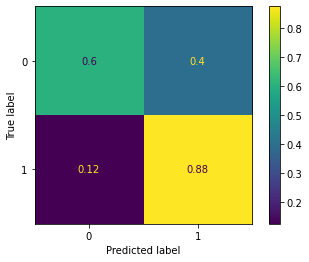

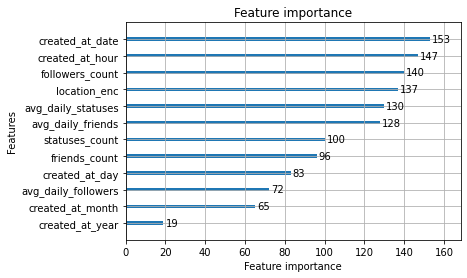

In [14]:
eval_clf(clf_users_fe, df_test_users_fe)

# Detection on tweets metadata

## Extract metadata

In [13]:
def extract_reply(text: str):
    res = re.match(r'(@\w+ )+', text)
    if res:
        text = text[res.span()[1]:]
        return text, True, res.group()[1:-1].split(" @")
    return text, False, np.nan

def extract_retweet(text: str):
    res = re.match(r'RT @(\w+): \.?', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True, res.group(1)
    return text, False, np.nan

def extract_modified_tweet(text: str):
    res = re.match(r'MT : ', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True
    return text, False

def extract_symbols(text: str, symbol: str):
    symbols = [ symbol[1:] for symbol in re.findall(fr"{symbol}\w+\b", text) ]
    text = re.sub(fr"{symbol}(?=\w+\b)", "", text)
    return text, symbols

def extract_links(text: str):
    links = re.findall("https?://.+?(?=(?:\s|$))", text)
    for link in links:
        text = text.replace(link, "")
    return text, links

def extract_ellipsis(text: str):
    text_cleaned = re.sub(r'\s*(?:\.{3}|…|\(\d+\/\d+\))\s*$', "", text)
    has_ellipsis = len(text_cleaned) != len(text)
    return text_cleaned, has_ellipsis

# TODO: Get emojis category? (use emojis, or advertools)
def extract_emojis(text: str):
    # Doesn't get all emojis...
    text = emojis.decode(text)
    emoji_list = re.findall(r":(.+?):", text)
    for emoji in emoji_list:
        text = text.replace(f":{emoji}:", "")
    return text, emoji_list
    
def clean_text(text: str):
    text_cleaned = unidecode(text)
    unk_chars_ratio = len(text_cleaned) / len(text) if text else 0
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned)
    return text_cleaned, unk_chars_ratio


def extract_artefacts(text: str):
    text, is_reply, replies = extract_reply(text)
    text_sat = len(text) / 240
    
    text, is_rt, retweet = extract_retweet(text)
    text, is_mt = extract_modified_tweet(text)
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, has_ellipsis = extract_ellipsis(text)
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    
    return (
        text, text_sat, is_reply, replies, 
        is_rt, retweet, is_mt, 
        hashtags, mentions, cashtags, 
        links, has_ellipsis, emoji_list, 
        unk_chars_ratio
    )


def get_artefacts(df: pd.DataFrame):    
    new_cols = [ 
        'tweet', 'text_sat', 'is_reply', 'replies', 
        'is_rt', 'retweet', 'is_mt', 
        'hashtags', 'mentions', 'cashtags',
        'links', 'has_ellipsis', 'emojis', 
        'unk_chars_ratio'
    ]
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_artefacts).to_list(), 
        columns=new_cols
    )
    
    df['hashtags_count'] = df['hashtags'].apply(len)
    df['mentions_count'] = df['mentions'].apply(len)
    df['cashtags_count'] = df['cashtags'].apply(len)
    df['links_count'] = df['links'].apply(len)
    df['emojis_count'] = df['emojis'].apply(len)
    
    return df

In [14]:
df_train = get_artefacts(df_train)
df_test = get_artefacts(df_test)
df_train.head()

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

,id,screen_name,location,followers_count,friends_count,statuses_count,tweet,label,location_enc,created_at_year,...,cashtags,links,has_ellipsis,emojis,unk_chars_ratio,hashtags_count,mentions_count,cashtags_count,links_count,emojis_count
0,24691376,vangoghmuseum,Amsterdam,1647822,1536,16822,Gustave Courbet was often called 'the most arr...,0,171,2009,...,[],[https://t.co/0YuOEv9mXU],False,"[triumph, sunflower]",1.0,1,0,0,1,2
1,259540958,IncredibleCulk,Heading to the corner,808966,146,2223,An animal MackLibs,0,1029,2011,...,[],[],False,[],1.0,1,0,0,0,0
2,424423803,CyaSteve,"Los Angeles, CA",2551,462,26710,I hope it's 900 gems.,1,1416,2011,...,[],[],False,[],1.0,0,0,0,0,0
3,281902422,SwatiJaiHind,"New Delhi, India",326003,381,8848,Delhi : Social Welfare Minister AdvRajendraPal...,0,1724,2011,...,[],[],True,[],1.0,1,2,0,0,0
4,173195708,Nigella_Lawson,London,2672077,872,36654,"I wouldn't even consider going on holiday now,...",0,1381,2010,...,[],[https://t.co/RFXOHTThMW],False,[],1.0,0,0,0,1,0


> __Improve extraction of emojis__

> __Improve spotting of non-english tweets__

> __Investigate tweets with more than 240 chars__

In [16]:
df_train.to_csv(PATH.format('train_metadata'))
df_test.to_csv(PATH.format('test_metadata'))

In [15]:
df_train = pd.read_csv(PATH.format('train_metadata'), index_col='Unnamed: 0')
df_test = pd.read_csv(PATH.format('test_metadata'), index_col='Unnamed: 0')

In [16]:
def filter_metadata(df: pd.DataFrame):
    return df.drop([ 'tweet', 'location', 'screen_name', 'id',
                     'replies', 'retweet', 'hashtags', 'mentions',
                     'cashtags', 'links', 'emojis' ], axis=1)

In [17]:
df_train_meta = filter_metadata(df_train)
df_test_meta = filter_metadata(df_test)

# Adding engineered features from df_users
df_train_meta = add_avg(df_train_meta)
df_test_meta = add_avg(df_test_meta)

## Training

> __Very high AUROC during training, but meh performance in the end bc of over-use of users metadata__

In [18]:
clf_meta = get_best_clf(df_train_meta)

[I 2022-03-29 12:09:13,948] A new study created in memory with name: no-name-4abfdcc4-e2b6-4eb2-9e4d-7f56c88e0927


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.868302


[I 2022-03-29 12:10:41,492] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 4.264872160139117, 'lambda_l2': 0.0014583372938268046, 'num_leaves': 55, 'feature_fraction': 0.6994303983998831, 'bagging_fraction': 0.670745141535865, 'bagging_freq': 7, 'learning_rate': 0.00016136717937104337, 'min_child_samples': 87}. Best is trial 1 with value: 0.5.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.868803


[I 2022-03-29 12:10:48,878] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 1.8444213347598857, 'lambda_l2': 2.0567605118211882e-06, 'num_leaves': 66, 'feature_fraction': 0.8352647514920153, 'bagging_fraction': 0.9151520820543831, 'bagging_freq': 1, 'learning_rate': 0.00023816660816078982, 'min_child_samples': 31}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.91525


[I 2022-03-29 12:11:20,683] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 1.0537903646171027, 'lambda_l2': 2.288003641200138, 'num_leaves': 148, 'feature_fraction': 0.5111351402194475, 'bagging_fraction': 0.5610456611986699, 'bagging_freq': 7, 'learning_rate': 1.9416696081696286e-05, 'min_child_samples': 72}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.90834


[I 2022-03-29 12:11:37,745] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 2.3212421699383325, 'lambda_l2': 3.982733533298371e-06, 'num_leaves': 221, 'feature_fraction': 0.9309327572532428, 'bagging_fraction': 0.6770823698291327, 'bagging_freq': 5, 'learning_rate': 1.751533177337642e-05, 'min_child_samples': 39}. Best is trial 1 with value: 0.5.


Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.922035


[I 2022-03-29 12:11:43,420] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 2.456816396995387e-08, 'lambda_l2': 7.750954643645542, 'num_leaves': 210, 'feature_fraction': 0.7923875439105925, 'bagging_fraction': 0.711905301947519, 'bagging_freq': 7, 'learning_rate': 0.00011548679720841048, 'min_child_samples': 31}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.934208
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:11:53,012] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.005463559099901017, 'lambda_l2': 0.0008069670701392225, 'num_leaves': 196, 'feature_fraction': 0.4961764162601395, 'bagging_fraction': 0.8707611318161135, 'bagging_freq': 4, 'learning_rate': 8.464739887915737e-05, 'min_child_samples': 95}. Best is trial 1 with value: 0.5.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.93909
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:12:00,398] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 7.834899473523701e-07, 'lambda_l2': 0.21657514201179995, 'num_leaves': 250, 'feature_fraction': 0.7560543703105884, 'bagging_fraction': 0.40683708812020436, 'bagging_freq': 6, 'learning_rate': 1.869998142511975e-05, 'min_child_samples': 73}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.893226


[I 2022-03-29 12:12:12,378] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 2.52006320646355e-05, 'lambda_l2': 3.596005449065642e-08, 'num_leaves': 164, 'feature_fraction': 0.9755906898970677, 'bagging_fraction': 0.6005503651828477, 'bagging_freq': 6, 'learning_rate': 0.00012777582431037249, 'min_child_samples': 66}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.948873


[I 2022-03-29 12:12:23,356] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 2.6975528359454295e-07, 'lambda_l2': 0.001294229775218079, 'num_leaves': 250, 'feature_fraction': 0.47243152687668655, 'bagging_fraction': 0.8035318371955502, 'bagging_freq': 7, 'learning_rate': 1.0384420419991724e-05, 'min_child_samples': 27}. Best is trial 1 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.886735


[I 2022-03-29 12:12:35,463] Trial 10 finished with value: 0.7901501925087299 and parameters: {'lambda_l1': 0.050109173666486095, 'lambda_l2': 3.55974215961117e-05, 'num_leaves': 81, 'feature_fraction': 0.7556890489209807, 'bagging_fraction': 0.9589511282110921, 'bagging_freq': 5, 'learning_rate': 0.002822144765663877, 'min_child_samples': 67}. Best is trial 10 with value: 0.7901501925087299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.931941


[I 2022-03-29 12:12:55,053] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 5.491242739316068e-08, 'lambda_l2': 0.028079133221976426, 'num_leaves': 228, 'feature_fraction': 0.7710943644304588, 'bagging_fraction': 0.5147405253062906, 'bagging_freq': 5, 'learning_rate': 8.792744881821046e-05, 'min_child_samples': 10}. Best is trial 10 with value: 0.7901501925087299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.864922


[I 2022-03-29 12:13:03,203] Trial 17 finished with value: 0.7770328481501612 and parameters: {'lambda_l1': 0.008799529592961791, 'lambda_l2': 4.984774448232746e-06, 'num_leaves': 9, 'feature_fraction': 0.6351242912162792, 'bagging_fraction': 0.9878288928601283, 'bagging_freq': 3, 'learning_rate': 0.07051142182150763, 'min_child_samples': 48}. Best is trial 10 with value: 0.7901501925087299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999533


[I 2022-03-29 12:13:10,704] Trial 13 finished with value: 0.9838279119812016 and parameters: {'lambda_l1': 3.031846441028964, 'lambda_l2': 6.642875983008096e-08, 'num_leaves': 87, 'feature_fraction': 0.9165791106501625, 'bagging_fraction': 0.8734647405448934, 'bagging_freq': 7, 'learning_rate': 0.11841263788840185, 'min_child_samples': 54}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.835382


[I 2022-03-29 12:13:26,167] Trial 19 finished with value: 0.7647697702259029 and parameters: {'lambda_l1': 0.015444854587081211, 'lambda_l2': 8.660523617539295e-06, 'num_leaves': 3, 'feature_fraction': 0.6238243406179745, 'bagging_fraction': 0.9625322609541173, 'bagging_freq': 3, 'learning_rate': 0.07732021608042976, 'min_child_samples': 48}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.883807


[I 2022-03-29 12:13:41,903] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 7.807164216944818e-06, 'lambda_l2': 0.26798600336458345, 'num_leaves': 99, 'feature_fraction': 0.8551575711309667, 'bagging_fraction': 0.9798751005187085, 'bagging_freq': 4, 'learning_rate': 3.337992506781232e-05, 'min_child_samples': 47}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.96305


[I 2022-03-29 12:13:50,059] Trial 14 finished with value: 0.8579940443102692 and parameters: {'lambda_l1': 0.00960718918818741, 'lambda_l2': 2.133149418652582e-08, 'num_leaves': 98, 'feature_fraction': 0.8136264001055812, 'bagging_fraction': 0.6991296952692307, 'bagging_freq': 5, 'learning_rate': 0.03068088564090973, 'min_child_samples': 59}. Best is trial 13 with value: 0.9838279119812016.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995426
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:13:57,477] Trial 16 finished with value: 0.9430764472115045 and parameters: {'lambda_l1': 1.4359763677518726e-07, 'lambda_l2': 0.2077161823962858, 'num_leaves': 93, 'feature_fraction': 0.5663194843285358, 'bagging_fraction': 0.8406962658160975, 'bagging_freq': 2, 'learning_rate': 0.0753834550369329, 'min_child_samples': 56}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.975731


[I 2022-03-29 12:14:08,078] Trial 11 finished with value: 0.8781457199701604 and parameters: {'lambda_l1': 0.006626855800623823, 'lambda_l2': 0.06344873195992938, 'num_leaves': 173, 'feature_fraction': 0.5054203865970731, 'bagging_fraction': 0.6881572919769656, 'bagging_freq': 3, 'learning_rate': 0.02183328107288816, 'min_child_samples': 6}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.92537
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.951776


[I 2022-03-29 12:14:30,975] Trial 18 finished with value: 0.8270818287905866 and parameters: {'lambda_l1': 0.004618346969771007, 'lambda_l2': 2.6671979567963778e-05, 'num_leaves': 96, 'feature_fraction': 0.6122407789857789, 'bagging_fraction': 0.9941069444306243, 'bagging_freq': 3, 'learning_rate': 0.015177379299870597, 'min_child_samples': 50}. Best is trial 13 with value: 0.9838279119812016.
[I 2022-03-29 12:14:34,440] Trial 12 finished with value: 0.8414036144702589 and parameters: {'lambda_l1': 0.04605481014585212, 'lambda_l2': 1.8598981060100152e-06, 'num_leaves': 215, 'feature_fraction': 0.5832096397170674, 'bagging_fraction': 0.5046825181591058, 'bagging_freq': 4, 'learning_rate': 0.005014876362675631, 'min_child_samples': 28}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.975483
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.90208


[I 2022-03-29 12:14:50,828] Trial 20 finished with value: 0.880106282525319 and parameters: {'lambda_l1': 0.024344533137362633, 'lambda_l2': 1.6409646920696298e-08, 'num_leaves': 107, 'feature_fraction': 0.8919236307479985, 'bagging_fraction': 0.9997218126060499, 'bagging_freq': 3, 'learning_rate': 0.03420816464525132, 'min_child_samples': 58}. Best is trial 13 with value: 0.9838279119812016.
[I 2022-03-29 12:14:54,044] Trial 21 finished with value: 0.8154705974373178 and parameters: {'lambda_l1': 0.04595563967540506, 'lambda_l2': 1.3695865650789546e-08, 'num_leaves': 90, 'feature_fraction': 0.8677321465293344, 'bagging_fraction': 0.8098063838798674, 'bagging_freq': 5, 'learning_rate': 0.008367300554726636, 'min_child_samples': 61}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.921279


[I 2022-03-29 12:15:18,624] Trial 22 finished with value: 0.8247662080920428 and parameters: {'lambda_l1': 0.11489893488438435, 'lambda_l2': 1.4953980527052828e-08, 'num_leaves': 102, 'feature_fraction': 0.881019769854079, 'bagging_fraction': 0.8156411671203793, 'bagging_freq': 5, 'learning_rate': 0.011808855164834018, 'min_child_samples': 62}. Best is trial 13 with value: 0.9838279119812016.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.984785


[I 2022-03-29 12:15:40,120] Trial 27 finished with value: 0.9173235395117867 and parameters: {'lambda_l1': 0.00022182433672133934, 'lambda_l2': 3.7884216415418423e-07, 'num_leaves': 36, 'feature_fraction': 0.41297158909584847, 'bagging_fraction': 0.8123403360079967, 'bagging_freq': 1, 'learning_rate': 0.18334560918492962, 'min_child_samples': 85}. Best is trial 13 with value: 0.9838279119812016.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:15:45,099] Trial 23 finished with value: 0.9996106340177182 and parameters: {'lambda_l1': 0.0003775806859027942, 'lambda_l2': 1.1503997158294509e-08, 'num_leaves': 114, 'feature_fraction': 0.9127361308957884, 'bagging_fraction': 0.8033743867334696, 'bagging_freq': 6, 'learning_rate': 0.25536672940321925, 'min_child_samples': 61}. Best is trial 23 with value: 0.9996106340177182.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:15:57,352] Trial 24 finished with value: 0.999582077604811 and parameters: {'lambda_l1': 0.00039132105496529455, 'lambda_l2': 2.608487656531571e-07, 'num_leaves': 123, 'feature_fraction': 0.6166456650600765, 'bagging_fraction': 0.7869978585043078, 'bagging_freq': 1, 'learning_rate': 0.28047683434319964, 'min_child_samples': 83}. Best is trial 23 with value: 0.9996106340177182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 12:16:08,941] Trial 25 finished with value: 0.9995698019742213 and parameters: {'lambda_l1': 0.00032966058220338604, 'lambda_l2': 1.045724522484912e-07, 'num_leaves': 130, 'feature_fraction': 0.5988058621560889, 'bagging_fraction': 0.8228430622212735, 'bagging_freq': 1, 'learning_rate': 0.23244758958387965, 'min_child_samples': 83}. Best is trial 23 with value: 0.9996106340177182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.992423


[I 2022-03-29 12:16:26,929] Trial 31 finished with value: 0.9449410575248778 and parameters: {'lambda_l1': 0.0002725212821910671, 'lambda_l2': 2.816131063342537e-07, 'num_leaves': 32, 'feature_fraction': 0.42235221218953134, 'bagging_fraction': 0.8645248938500022, 'bagging_freq': 1, 'learning_rate': 0.28608145275656177, 'min_child_samples': 84}. Best is trial 23 with value: 0.9996106340177182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:16:36,103] Trial 26 finished with value: 0.9994232152433384 and parameters: {'lambda_l1': 0.00021161691217749004, 'lambda_l2': 2.8421685498064886e-07, 'num_leaves': 127, 'feature_fraction': 0.4207062199642385, 'bagging_fraction': 0.8108323900636919, 'bagging_freq': 1, 'learning_rate': 0.27769934541506125, 'min_child_samples': 88}. Best is trial 23 with value: 0.9996106340177182.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 12:16:40,353] Trial 28 finished with value: 0.9997508526029126 and parameters: {'lambda_l1': 0.00032574720269417805, 'lambda_l2': 5.057248106078933e-08, 'num_leaves': 119, 'feature_fraction': 0.9034027933885391, 'bagging_fraction': 0.8342429990334918, 'bagging_freq': 1, 'learning_rate': 0.29777689593036366, 'min_child_samples': 58}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:16:46,766] Trial 29 finished with value: 0.9994008968884165 and parameters: {'lambda_l1': 6.764615032445058e-05, 'lambda_l2': 2.0308628451858993e-07, 'num_leaves': 129, 'feature_fraction': 0.9177187562260676, 'bagging_fraction': 0.8583031462497501, 'bagging_freq': 1, 'learning_rate': 0.19743872222752376, 'min_child_samples': 79}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 12:17:11,749] Trial 32 finished with value: 0.9997389274420821 and parameters: {'lambda_l1': 0.0005210929641844235, 'lambda_l2': 3.590253124448425e-07, 'num_leaves': 129, 'feature_fraction': 0.9932329783107411, 'bagging_fraction': 0.7520521174420818, 'bagging_freq': 2, 'learning_rate': 0.2726586591913255, 'min_child_samples': 78}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:17:18,995] Trial 30 finished with value: 0.9995320338642031 and parameters: {'lambda_l1': 0.0005053774166518964, 'lambda_l2': 3.988723439996807e-07, 'num_leaves': 130, 'feature_fraction': 0.9363989563404241, 'bagging_fraction': 0.8930080620923502, 'bagging_freq': 1, 'learning_rate': 0.23200297917029494, 'min_child_samples': 82}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999992
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:17:26,255] Trial 33 finished with value: 0.999664812997757 and parameters: {'lambda_l1': 0.00046855638418478654, 'lambda_l2': 1.8865377432662442e-07, 'num_leaves': 128, 'feature_fraction': 0.9837797635919754, 'bagging_fraction': 0.7700365879719584, 'bagging_freq': 6, 'learning_rate': 0.23287120531133595, 'min_child_samples': 76}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999999


[I 2022-03-29 12:18:01,368] Trial 34 finished with value: 0.9995596490588612 and parameters: {'lambda_l1': 0.00051828264929944, 'lambda_l2': 1.652813650588324e-07, 'num_leaves': 128, 'feature_fraction': 0.6894478750524767, 'bagging_fraction': 0.7621410031088948, 'bagging_freq': 2, 'learning_rate': 0.23978949798740157, 'min_child_samples': 79}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990623


[I 2022-03-29 12:18:12,571] Trial 37 finished with value: 0.9226704328726979 and parameters: {'lambda_l1': 0.0009733391529002466, 'lambda_l2': 8.409837636428212e-07, 'num_leaves': 125, 'feature_fraction': 0.9947838151311328, 'bagging_fraction': 0.914125075576984, 'bagging_freq': 2, 'learning_rate': 0.04091124407863589, 'min_child_samples': 98}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.907205
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:18:19,622] Trial 36 finished with value: 0.5 and parameters: {'lambda_l1': 0.0011712108798505995, 'lambda_l2': 1.5473031620952492e-07, 'num_leaves': 137, 'feature_fraction': 0.6925404527042942, 'bagging_fraction': 0.7542315099042416, 'bagging_freq': 2, 'learning_rate': 0.0005747463920911062, 'min_child_samples': 96}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902546
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:18:27,858] Trial 35 finished with value: 0.5 and parameters: {'lambda_l1': 5.4784694379135194e-05, 'lambda_l2': 2.420792925992028e-07, 'num_leaves': 125, 'feature_fraction': 0.686314380785664, 'bagging_fraction': 0.7742800229912121, 'bagging_freq': 2, 'learning_rate': 0.000555569820290767, 'min_child_samples': 99}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.911578
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:18:36,587] Trial 38 finished with value: 0.5 and parameters: {'lambda_l1': 0.0012221126770003367, 'lambda_l2': 1.4837411519883225e-07, 'num_leaves': 147, 'feature_fraction': 0.6836724577053643, 'bagging_fraction': 0.7534944683167135, 'bagging_freq': 2, 'learning_rate': 0.0005149021487326856, 'min_child_samples': 98}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.888546


[I 2022-03-29 12:19:04,830] Trial 39 finished with value: 0.6878163716654065 and parameters: {'lambda_l1': 0.0008176825981640147, 'lambda_l2': 9.572192751756944e-07, 'num_leaves': 146, 'feature_fraction': 0.9879072546085776, 'bagging_fraction': 0.7539202804087166, 'bagging_freq': 2, 'learning_rate': 0.0010878273413901084, 'min_child_samples': 94}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.889851


[I 2022-03-29 12:19:15,201] Trial 40 finished with value: 0.6736413684916605 and parameters: {'lambda_l1': 0.0016619703806763412, 'lambda_l2': 7.738229763510573e-07, 'num_leaves': 151, 'feature_fraction': 0.9999341268072429, 'bagging_fraction': 0.7542453222360289, 'bagging_freq': 2, 'learning_rate': 0.000986385523077553, 'min_child_samples': 75}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996355


[I 2022-03-29 12:19:21,414] Trial 41 finished with value: 0.9456670276519944 and parameters: {'lambda_l1': 0.0019149931525731382, 'lambda_l2': 9.870260449856112e-07, 'num_leaves': 150, 'feature_fraction': 0.9973862233775741, 'bagging_fraction': 0.7601397175942797, 'bagging_freq': 2, 'learning_rate': 0.04322346771549716, 'min_child_samples': 73}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996292


[I 2022-03-29 12:19:37,872] Trial 46 finished with value: 0.9536276860729866 and parameters: {'lambda_l1': 5.4191924713437955e-06, 'lambda_l2': 0.00014013367391124305, 'num_leaves': 70, 'feature_fraction': 0.9608219359120572, 'bagging_fraction': 0.6505361883728817, 'bagging_freq': 6, 'learning_rate': 0.10692062891592202, 'min_child_samples': 74}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998603


[I 2022-03-29 12:19:47,426] Trial 45 finished with value: 0.973577253910163 and parameters: {'lambda_l1': 1.6026290434324697e-06, 'lambda_l2': 0.00027669788134564415, 'num_leaves': 69, 'feature_fraction': 0.9599768217530014, 'bagging_fraction': 0.6506158376300485, 'bagging_freq': 7, 'learning_rate': 0.1312936204870196, 'min_child_samples': 74}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.892107


[I 2022-03-29 12:20:00,843] Trial 42 finished with value: 0.5956603633573002 and parameters: {'lambda_l1': 4.2106968246801155e-06, 'lambda_l2': 9.112146036000997e-07, 'num_leaves': 158, 'feature_fraction': 0.9892528048831668, 'bagging_fraction': 0.7333893760137712, 'bagging_freq': 6, 'learning_rate': 0.0008509173219450217, 'min_child_samples': 74}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.893498


[I 2022-03-29 12:20:05,570] Trial 43 finished with value: 0.5 and parameters: {'lambda_l1': 9.694491777657876e-06, 'lambda_l2': 8.705784742330998e-05, 'num_leaves': 149, 'feature_fraction': 0.9639744719973803, 'bagging_fraction': 0.7442296668962901, 'bagging_freq': 6, 'learning_rate': 0.0008137634967097276, 'min_child_samples': 72}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.992515


[I 2022-03-29 12:20:11,249] Trial 47 finished with value: 0.9376389795538775 and parameters: {'lambda_l1': 3.376500823241098e-06, 'lambda_l2': 0.0001485830266489583, 'num_leaves': 68, 'feature_fraction': 0.9493299802068746, 'bagging_fraction': 0.6360384210357659, 'bagging_freq': 6, 'learning_rate': 0.09322491915748689, 'min_child_samples': 74}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999985
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:20:18,890] Trial 44 finished with value: 0.9972556045700223 and parameters: {'lambda_l1': 3.817684760885517e-06, 'lambda_l2': 0.00019208298689891485, 'num_leaves': 157, 'feature_fraction': 0.959159243105477, 'bagging_fraction': 0.7323348041575112, 'bagging_freq': 6, 'learning_rate': 0.11578301681591525, 'min_child_samples': 72}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999923


[I 2022-03-29 12:20:37,631] Trial 48 finished with value: 0.9943713609212841 and parameters: {'lambda_l1': 1.3729089425819883e-06, 'lambda_l2': 4.664108942117291e-08, 'num_leaves': 112, 'feature_fraction': 0.9560088648900918, 'bagging_fraction': 0.6445638712200588, 'bagging_freq': 6, 'learning_rate': 0.12115421864478376, 'min_child_samples': 68}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999964


[I 2022-03-29 12:20:43,619] Trial 49 finished with value: 0.9963593029482704 and parameters: {'lambda_l1': 5.653369868536158e-06, 'lambda_l2': 4.3902860261242796e-08, 'num_leaves': 113, 'feature_fraction': 0.9505166565089591, 'bagging_fraction': 0.6450330323632887, 'bagging_freq': 6, 'learning_rate': 0.12872421744349385, 'min_child_samples': 40}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999875


[I 2022-03-29 12:21:03,271] Trial 51 finished with value: 0.9928417126721965 and parameters: {'lambda_l1': 8.538222948190833e-05, 'lambda_l2': 5.051758137183062e-08, 'num_leaves': 111, 'feature_fraction': 0.9452433170850086, 'bagging_fraction': 0.7086295357418977, 'bagging_freq': 6, 'learning_rate': 0.1170925074202663, 'min_child_samples': 67}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99995


[I 2022-03-29 12:21:22,426] Trial 54 finished with value: 0.99466961084073 and parameters: {'lambda_l1': 7.214400282167411e-05, 'lambda_l2': 4.472900660209674e-08, 'num_leaves': 113, 'feature_fraction': 0.7331995544275671, 'bagging_fraction': 0.7868800366614479, 'bagging_freq': 1, 'learning_rate': 0.12949772593524322, 'min_child_samples': 67}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:21:27,517] Trial 50 finished with value: 0.9990863462899784 and parameters: {'lambda_l1': 7.359408226034882e-05, 'lambda_l2': 5.2901393192597234e-08, 'num_leaves': 188, 'feature_fraction': 0.9486676402486179, 'bagging_fraction': 0.7291475786341955, 'bagging_freq': 7, 'learning_rate': 0.11950895818388652, 'min_child_samples': 68}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:21:41,763] Trial 52 finished with value: 0.9993874397608468 and parameters: {'lambda_l1': 6.86018114478003e-05, 'lambda_l2': 4.291587519754034e-08, 'num_leaves': 180, 'feature_fraction': 0.9453384827773531, 'bagging_fraction': 0.720598834495324, 'bagging_freq': 6, 'learning_rate': 0.13681409650948598, 'min_child_samples': 67}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999995


[I 2022-03-29 12:21:48,412] Trial 53 finished with value: 0.9992558421242732 and parameters: {'lambda_l1': 0.00011123199750220239, 'lambda_l2': 3.747171416462904e-08, 'num_leaves': 180, 'feature_fraction': 0.8223299855408481, 'bagging_fraction': 0.7891580412822348, 'bagging_freq': 6, 'learning_rate': 0.1373187419375766, 'min_child_samples': 67}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999498


[I 2022-03-29 12:21:57,807] Trial 55 finished with value: 0.9803277946920798 and parameters: {'lambda_l1': 7.095698293705218e-05, 'lambda_l2': 4.006983931353177e-08, 'num_leaves': 180, 'feature_fraction': 0.8221294769839039, 'bagging_fraction': 0.7898491851286977, 'bagging_freq': 1, 'learning_rate': 0.05458995873342892, 'min_child_samples': 89}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999671


[I 2022-03-29 12:22:16,752] Trial 56 finished with value: 0.98288820564759 and parameters: {'lambda_l1': 9.989759457705837e-05, 'lambda_l2': 0.004490828195014671, 'num_leaves': 183, 'feature_fraction': 0.8233739308891515, 'bagging_fraction': 0.713181914605463, 'bagging_freq': 7, 'learning_rate': 0.05677927665589474, 'min_child_samples': 92}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999424


[I 2022-03-29 12:22:41,453] Trial 57 finished with value: 0.9797178377256179 and parameters: {'lambda_l1': 7.506292741800983e-05, 'lambda_l2': 0.0016951576558103423, 'num_leaves': 177, 'feature_fraction': 0.8259881121754507, 'bagging_fraction': 0.781509261611242, 'bagging_freq': 1, 'learning_rate': 0.05425582002384026, 'min_child_samples': 66}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999458


[I 2022-03-29 12:22:46,675] Trial 58 finished with value: 0.9793245568859615 and parameters: {'lambda_l1': 2.1337108920552186e-05, 'lambda_l2': 2.562079812063565e-06, 'num_leaves': 179, 'feature_fraction': 0.543030699262482, 'bagging_fraction': 0.7845113916437654, 'bagging_freq': 1, 'learning_rate': 0.05859195998533659, 'min_child_samples': 91}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999251


[I 2022-03-29 12:23:09,181] Trial 59 finished with value: 0.9771189776172459 and parameters: {'lambda_l1': 0.0032793122579840724, 'lambda_l2': 9.112478943954506e-08, 'num_leaves': 189, 'feature_fraction': 0.5760172984041275, 'bagging_fraction': 0.8416439307682877, 'bagging_freq': 1, 'learning_rate': 0.05214413643524438, 'min_child_samples': 90}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999492
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998405


[I 2022-03-29 12:23:14,308] Trial 60 finished with value: 0.9794994796476956 and parameters: {'lambda_l1': 0.003735535223004976, 'lambda_l2': 2.5164424403201153e-06, 'num_leaves': 177, 'feature_fraction': 0.5372729558520206, 'bagging_fraction': 0.8375821649733992, 'bagging_freq': 1, 'learning_rate': 0.0612270096554627, 'min_child_samples': 21}. Best is trial 28 with value: 0.9997508526029126.
[I 2022-03-29 12:23:18,323] Trial 62 finished with value: 0.9638385329054766 and parameters: {'lambda_l1': 1.5999994330841582e-05, 'lambda_l2': 3.885393446042896e-06, 'num_leaves': 136, 'feature_fraction': 0.541972843543282, 'bagging_fraction': 0.838679135031439, 'bagging_freq': 1, 'learning_rate': 0.0651538736747096, 'min_child_samples': 90}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999574Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999987



[I 2022-03-29 12:23:25,568] Trial 64 finished with value: 0.9986953381499291 and parameters: {'lambda_l1': 0.0039713807523056805, 'lambda_l2': 3.7900219760506744e-06, 'num_leaves': 82, 'feature_fraction': 0.5456022386242425, 'bagging_fraction': 0.8359648939854774, 'bagging_freq': 1, 'learning_rate': 0.2947320547537192, 'min_child_samples': 78}. Best is trial 28 with value: 0.9997508526029126.
[I 2022-03-29 12:23:25,913] Trial 61 finished with value: 0.9809624330074237 and parameters: {'lambda_l1': 2.0919892946671643e-05, 'lambda_l2': 0.007102387489304646, 'num_leaves': 166, 'feature_fraction': 0.5482526622435206, 'bagging_fraction': 0.8434021533830578, 'bagging_freq': 1, 'learning_rate': 0.06616223607978562, 'min_child_samples': 91}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.978147
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:23:36,028] Trial 63 finished with value: 0.8834939800498782 and parameters: {'lambda_l1': 0.0027060432662969133, 'lambda_l2': 0.005318913290474201, 'num_leaves': 166, 'feature_fraction': 0.6523541097690764, 'bagging_fraction': 0.8368830972966799, 'bagging_freq': 1, 'learning_rate': 0.022589110033389315, 'min_child_samples': 90}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999909


[I 2022-03-29 12:23:58,972] Trial 65 finished with value: 0.9943353650567364 and parameters: {'lambda_l1': 0.002585209076726762, 'lambda_l2': 8.381479460723882e-06, 'num_leaves': 80, 'feature_fraction': 0.5539608275000826, 'bagging_fraction': 0.843153072443692, 'bagging_freq': 1, 'learning_rate': 0.18813851934672401, 'min_child_samples': 79}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999943


[I 2022-03-29 12:24:14,341] Trial 66 finished with value: 0.9950644236471258 and parameters: {'lambda_l1': 0.0026352916942826224, 'lambda_l2': 1.015259156400734e-08, 'num_leaves': 82, 'feature_fraction': 0.6514496968322913, 'bagging_fraction': 0.8444270451593154, 'bagging_freq': 5, 'learning_rate': 0.18840781774541784, 'min_child_samples': 42}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999888


[I 2022-03-29 12:24:27,186] Trial 67 finished with value: 0.9940924557176345 and parameters: {'lambda_l1': 2.8950432538248656e-05, 'lambda_l2': 9.99872178764785e-06, 'num_leaves': 83, 'feature_fraction': 0.6005318499961492, 'bagging_fraction': 0.8358360909762794, 'bagging_freq': 5, 'learning_rate': 0.18337109811577945, 'min_child_samples': 80}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:24:55,651] Trial 68 finished with value: 0.999402318664128 and parameters: {'lambda_l1': 0.00040860914063878387, 'lambda_l2': 1.0396458706004745e-07, 'num_leaves': 137, 'feature_fraction': 0.6450304515666998, 'bagging_fraction': 0.8321656811269589, 'bagging_freq': 3, 'learning_rate': 0.20444643389065043, 'min_child_samples': 85}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:25:04,140] Trial 71 finished with value: 0.9994085766187882 and parameters: {'lambda_l1': 0.0003566757939040121, 'lambda_l2': 1.1731777972262105e-08, 'num_leaves': 137, 'feature_fraction': 0.6612250778408365, 'bagging_fraction': 0.8962604612995495, 'bagging_freq': 4, 'learning_rate': 0.20129511508734177, 'min_child_samples': 82}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:25:08,386] Trial 72 finished with value: 0.9993621875601492 and parameters: {'lambda_l1': 0.00045081801032202825, 'lambda_l2': 1.136303364714298e-08, 'num_leaves': 138, 'feature_fraction': 0.9081765262598549, 'bagging_fraction': 0.6922104630158864, 'bagging_freq': 3, 'learning_rate': 0.20361245263277775, 'min_child_samples': 81}. Best is trial 28 with value: 0.9997508526029126.
[I 2022-03-29 12:25:13,435] Trial 69 finished with value: 0.9990524930373347 and parameters: {'lambda_l1': 0.000520351664818494, 'lambda_l2': 1.1645266576954998e-08, 'num_leaves': 118, 'feature_fraction': 0.6587613281328952, 'bagging_fraction': 0.8241405091052417, 'bagging_freq': 4, 'learning_rate': 0.20597887655221234, 'min_child_samples': 79}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:25:20,962] Trial 70 finished with value: 0.9986591020066502 and parameters: {'lambda_l1': 0.00048193524485743854, 'lambda_l2': 1.9821594258279904e-08, 'num_leaves': 117, 'feature_fraction': 0.6039512849301929, 'bagging_fraction': 0.9060992433082747, 'bagging_freq': 4, 'learning_rate': 0.19267142017710095, 'min_child_samples': 80}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:25:48,738] Trial 74 finished with value: 0.9995350977976818 and parameters: {'lambda_l1': 0.0004237111307983244, 'lambda_l2': 1.0103846902048046e-07, 'num_leaves': 120, 'feature_fraction': 0.5992343121385892, 'bagging_fraction': 0.8986283841981714, 'bagging_freq': 2, 'learning_rate': 0.2431082591279858, 'min_child_samples': 82}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:25:57,975] Trial 75 finished with value: 0.9994379640589167 and parameters: {'lambda_l1': 0.00040964512349757077, 'lambda_l2': 1.1242236836299074e-07, 'num_leaves': 120, 'feature_fraction': 0.8996858290976, 'bagging_fraction': 0.6862794027195279, 'bagging_freq': 3, 'learning_rate': 0.2267360668173941, 'min_child_samples': 84}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:26:05,974] Trial 73 finished with value: 0.9994451632318263 and parameters: {'lambda_l1': 0.0004254921857564146, 'lambda_l2': 1.1324981709461784e-07, 'num_leaves': 138, 'feature_fraction': 0.5981352006235017, 'bagging_fraction': 0.8861148111288113, 'bagging_freq': 4, 'learning_rate': 0.21026240330765836, 'min_child_samples': 83}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999999


[I 2022-03-29 12:26:29,108] Trial 76 finished with value: 0.9997064760684752 and parameters: {'lambda_l1': 0.0004866249872979515, 'lambda_l2': 2.4779572418637485e-08, 'num_leaves': 119, 'feature_fraction': 0.8953488416085243, 'bagging_fraction': 0.6827403393329475, 'bagging_freq': 4, 'learning_rate': 0.29320377486191884, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:26:35,082] Trial 77 finished with value: 0.9996620995340374 and parameters: {'lambda_l1': 0.0006379487481172894, 'lambda_l2': 2.1953856102295282e-08, 'num_leaves': 119, 'feature_fraction': 0.7155921401656709, 'bagging_fraction': 0.6832664028346656, 'bagging_freq': 2, 'learning_rate': 0.2870896061809967, 'min_child_samples': 53}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 12:26:49,305] Trial 78 finished with value: 0.9997205239445351 and parameters: {'lambda_l1': 0.0006503139468338425, 'lambda_l2': 3.64536691288324e-07, 'num_leaves': 120, 'feature_fraction': 0.7306671037456662, 'bagging_fraction': 0.8837493929498512, 'bagging_freq': 2, 'learning_rate': 0.2943974360287786, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.
[I 2022-03-29 12:26:49,367] Trial 79 finished with value: 0.9997109617776649 and parameters: {'lambda_l1': 0.00015170719309071974, 'lambda_l2': 4.83183427174867e-07, 'num_leaves': 121, 'feature_fraction': 0.8521241554829965, 'bagging_fraction': 0.9011686191676485, 'bagging_freq': 2, 'learning_rate': 0.2749934439890536, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999998
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:27:00,013] Trial 80 finished with value: 0.9996687079584569 and parameters: {'lambda_l1': 0.00018865297954321716, 'lambda_l2': 3.2532771799312055e-07, 'num_leaves': 122, 'feature_fraction': 0.712631028509451, 'bagging_fraction': 0.927326799404428, 'bagging_freq': 2, 'learning_rate': 0.28623827141536606, 'min_child_samples': 52}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 12:27:17,938] Trial 81 finished with value: 0.9993447252808513 and parameters: {'lambda_l1': 0.0001774891523704478, 'lambda_l2': 4.854192816920831e-07, 'num_leaves': 106, 'feature_fraction': 0.7263858008734051, 'bagging_fraction': 0.878955860759669, 'bagging_freq': 2, 'learning_rate': 0.28565179221991027, 'min_child_samples': 53}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:27:26,469] Trial 82 finished with value: 0.9995437187463025 and parameters: {'lambda_l1': 0.00018536775379244117, 'lambda_l2': 4.6034340766352763e-07, 'num_leaves': 101, 'feature_fraction': 0.7153670384069841, 'bagging_fraction': 0.8751860530027362, 'bagging_freq': 2, 'learning_rate': 0.28487592956456875, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:27:52,110] Trial 83 finished with value: 0.9995778321743519 and parameters: {'lambda_l1': 0.00015691303750632306, 'lambda_l2': 4.542800578704866e-07, 'num_leaves': 105, 'feature_fraction': 0.8477437118064816, 'bagging_fraction': 0.43056681346997827, 'bagging_freq': 2, 'learning_rate': 0.29819680429445633, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.999998


[I 2022-03-29 12:27:57,081] Trial 84 finished with value: 0.9996675264614766 and parameters: {'lambda_l1': 0.0001570909349310166, 'lambda_l2': 4.433505444003695e-07, 'num_leaves': 103, 'feature_fraction': 0.7859129854301865, 'bagging_fraction': 0.605336293354752, 'bagging_freq': 2, 'learning_rate': 0.29987834566814214, 'min_child_samples': 55}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:28:02,616] Trial 85 finished with value: 0.999651005400428 and parameters: {'lambda_l1': 0.00016256536612579056, 'lambda_l2': 4.439009263815406e-07, 'num_leaves': 104, 'feature_fraction': 0.9226981307499552, 'bagging_fraction': 0.580944866426103, 'bagging_freq': 2, 'learning_rate': 0.29839138489779504, 'min_child_samples': 54}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.894936


[I 2022-03-29 12:28:21,280] Trial 86 finished with value: 0.8105699073683232 and parameters: {'lambda_l1': 0.00019238720736329206, 'lambda_l2': 4.6735483089251307e-07, 'num_leaves': 99, 'feature_fraction': 0.8534349737118215, 'bagging_fraction': 0.9397948692353932, 'bagging_freq': 2, 'learning_rate': 0.004014129944634203, 'min_child_samples': 56}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99873


[I 2022-03-29 12:28:31,663] Trial 87 finished with value: 0.9721698936357979 and parameters: {'lambda_l1': 0.0001574664882863955, 'lambda_l2': 5.844497040554143e-07, 'num_leaves': 105, 'feature_fraction': 0.8496883052909321, 'bagging_fraction': 0.9441587624138323, 'bagging_freq': 2, 'learning_rate': 0.08372520366621582, 'min_child_samples': 54}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:28:36,634] Trial 88 finished with value: 0.9996591457915868 and parameters: {'lambda_l1': 0.00015058698135708245, 'lambda_l2': 2.29911272924995e-08, 'num_leaves': 104, 'feature_fraction': 0.7869809482839991, 'bagging_fraction': 0.9333922005017685, 'bagging_freq': 2, 'learning_rate': 0.29067420912936076, 'min_child_samples': 53}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998826


[I 2022-03-29 12:28:53,250] Trial 89 finished with value: 0.9687190089567377 and parameters: {'lambda_l1': 3.547435506554922e-05, 'lambda_l2': 2.377080300100607e-08, 'num_leaves': 102, 'feature_fraction': 0.7953903576187322, 'bagging_fraction': 0.9361434358509474, 'bagging_freq': 2, 'learning_rate': 0.09016822259573752, 'min_child_samples': 62}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997193


[I 2022-03-29 12:28:57,191] Trial 90 finished with value: 0.9579162979789236 and parameters: {'lambda_l1': 3.674911246678695e-05, 'lambda_l2': 2.4237411413143545e-08, 'num_leaves': 92, 'feature_fraction': 0.8000588850388093, 'bagging_fraction': 0.9346536879802374, 'bagging_freq': 3, 'learning_rate': 0.0857052233952052, 'min_child_samples': 57}. Best is trial 28 with value: 0.9997508526029126.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.9976


[I 2022-03-29 12:29:21,998] Trial 92 finished with value: 0.9619116170430458 and parameters: {'lambda_l1': 1.1278476283637793e-08, 'lambda_l2': 1.4657937481682923e-06, 'num_leaves': 90, 'feature_fraction': 0.7870768877189341, 'bagging_fraction': 0.9273729028895563, 'bagging_freq': 3, 'learning_rate': 0.0911954450605228, 'min_child_samples': 56}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998299
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:29:28,647] Trial 93 finished with value: 0.9656558266868832 and parameters: {'lambda_l1': 0.007690529743222591, 'lambda_l2': 1.6129615222799641e-06, 'num_leaves': 96, 'feature_fraction': 0.7859836418933356, 'bagging_fraction': 0.9422939022577549, 'bagging_freq': 3, 'learning_rate': 0.0876553921867544, 'min_child_samples': 50}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999963
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999931


[I 2022-03-29 12:29:42,779] Trial 95 finished with value: 0.9965015340576663 and parameters: {'lambda_l1': 0.000741697466452519, 'lambda_l2': 1.2415366369249223e-06, 'num_leaves': 95, 'feature_fraction': 0.7942070367473484, 'bagging_fraction': 0.5407044344209135, 'bagging_freq': 3, 'learning_rate': 0.15893019288596938, 'min_child_samples': 45}. Best is trial 28 with value: 0.9997508526029126.
[I 2022-03-29 12:29:43,859] Trial 91 finished with value: 0.9936807514837562 and parameters: {'lambda_l1': 0.001033918810534647, 'lambda_l2': 2.684922168393431e-08, 'num_leaves': 143, 'feature_fraction': 0.7914709542089559, 'bagging_fraction': 0.947859898152745, 'bagging_freq': 3, 'learning_rate': 0.09559811207795824, 'min_child_samples': 58}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99993


[I 2022-03-29 12:29:54,774] Trial 97 finished with value: 0.9948304857264039 and parameters: {'lambda_l1': 0.0009583850305070391, 'lambda_l2': 1.5706970278606003e-06, 'num_leaves': 94, 'feature_fraction': 0.7507474366727384, 'bagging_fraction': 0.6717399090798554, 'bagging_freq': 3, 'learning_rate': 0.1609447246765993, 'min_child_samples': 50}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999995


[I 2022-03-29 12:30:05,691] Trial 96 finished with value: 0.9986704165223159 and parameters: {'lambda_l1': 4.088284864617312e-05, 'lambda_l2': 1.253267189262457e-06, 'num_leaves': 143, 'feature_fraction': 0.7579085410211814, 'bagging_fraction': 0.6095477701639924, 'bagging_freq': 3, 'learning_rate': 0.15131508928271606, 'min_child_samples': 45}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 12:30:11,509] Trial 98 finished with value: 0.9988521879872003 and parameters: {'lambda_l1': 0.0008783504534971537, 'lambda_l2': 2.4231217098263497e-07, 'num_leaves': 143, 'feature_fraction': 0.7642016314545961, 'bagging_fraction': 0.618620500322694, 'bagging_freq': 2, 'learning_rate': 0.15714057044431437, 'min_child_samples': 50}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993


[I 2022-03-29 12:30:13,595] Trial 99 finished with value: 0.9984955136572566 and parameters: {'lambda_l1': 0.0007829569269747941, 'lambda_l2': 2.0313393620573155e-07, 'num_leaves': 132, 'feature_fraction': 0.7497484553059574, 'bagging_fraction': 0.6656474035046798, 'bagging_freq': 2, 'learning_rate': 0.15665262419878445, 'min_child_samples': 50}. Best is trial 28 with value: 0.9997508526029126.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993


[I 2022-03-29 12:30:15,963] Trial 94 finished with value: 0.9979788857632135 and parameters: {'lambda_l1': 0.0009348205742090182, 'lambda_l2': 1.5120161823496e-06, 'num_leaves': 255, 'feature_fraction': 0.7753030186321059, 'bagging_fraction': 0.933088791461638, 'bagging_freq': 3, 'learning_rate': 0.0797049556247469, 'min_child_samples': 46}. Best is trial 28 with value: 0.9997508526029126.


{'lambda_l1': 0.00032574720269417805, 'lambda_l2': 5.057248106078933e-08, 'num_leaves': 119, 'feature_fraction': 0.9034027933885391, 'bagging_fraction': 0.8342429990334918, 'bagging_freq': 1, 'learning_rate': 0.29777689593036366, 'min_child_samples': 58} -> 0.9997508526029126
[LightGBM] [Warning] feature_fraction is set=0.9034027933885391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9034027933885391
[LightGBM] [Warning] lambda_l1 is set=0.00032574720269417805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032574720269417805
[LightGBM] [Warning] bagging_fraction is set=0.8342429990334918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342429990334918
[LightGBM] [Warning] lambda_l2 is set=5.057248106078933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.057248106078933e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores 

AUROC: 0.7456488098229351
Accuracy: 0.7479123199391583


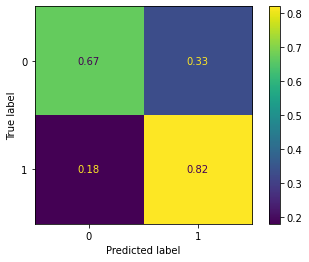

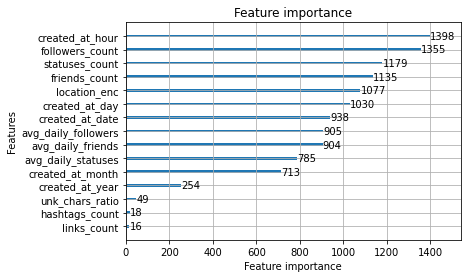

In [19]:
eval_clf(clf_meta, df_test_meta)

### Average probas at the user level

In [20]:
df_train_meta_agg, df_test_meta_agg = get_agg(clf_meta, 
                                              df_train_meta, 
                                              df_test_meta, 
                                              df_train['id'], 
                                              df_test['id'])
clf_meta_agg = get_best_clf(df_train_meta_agg)

[I 2022-03-29 12:30:41,293] A new study created in memory with name: no-name-9d7b66f6-835e-4a6a-8ccc-428caf2c2c87
[I 2022-03-29 12:30:41,559] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.8025872019719471, 'lambda_l2': 0.18614322014146678, 'num_leaves': 205, 'feature_fraction': 0.9154939740766698, 'bagging_fraction': 0.45236515707168806, 'bagging_freq': 3, 'learning_rate': 3.1623122337225445e-05, 'min_child_samples': 68}. Best is trial 6 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999878


[I 2022-03-29 12:30:41,574] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 1.247154120074183, 'lambda_l2': 0.0004988778465035614, 'num_leaves': 178, 'feature_fraction': 0.6073961786987421, 'bagging_fraction': 0.940550430984856, 'bagging_freq': 6, 'learning_rate': 0.007721236325755842, 'min_child_samples': 79}. Best is trial 6 with value: 0.5.
[I 2022-03-29 12:30:41,593] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 2.910700903143719e-07, 'lambda_l2': 1.936120588623136, 'num_leaves': 175, 'feature_fraction': 0.7845760825668453, 'bagging_fraction': 0.924407791670551, 'bagging_freq': 7, 'learning_rate': 0.0001632102116528983, 'min_child_samples': 60}. Best is trial 6 with value: 0.5.
[I 2022-03-29 12:30:41,606] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 2.074622355116885, 'lambda_l2': 0.00365686820250909, 'num_leaves': 52, 'feature_fraction': 0.5647236180849451, 'bagging_fraction': 0.4345653594371697, 'bagging_freq': 1, 'learning_rate':

Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999343
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999346
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.999355
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999848Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.999838
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:41,778] Trial 1 finished with value: 0.9963187347354943 and parameters: {'lambda_l1': 0.11634916818417955, 'lambda_l2': 0.019582209686597206, 'num_leaves': 221, 'feature_fraction': 0.5347121304605724, 'bagging_fraction': 0.5836565691867059, 'bagging_freq': 5, 'learning_rate': 0.02573260177567649, 'min_child_samples': 11}. Best is trial 3 with value: 0.996626988831717.
[I 2022-03-29 12:30:41,856] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 5.4177494011174456e-05, 'lambda_l2': 0.0001358468318560076, 'num_leaves': 204, 'feature_fraction': 0.803611650930467, 'bagging_fraction': 0.6743825304108697, 'bagging_freq': 4, 'learning_rate': 0.003782683061972491, 'min_child_samples': 13}. Best is trial 3 with value: 0.996626988831717.
[I 2022-03-29 12:30:41,887] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.00018229188494763718, 'lambda_l2': 2.8994097284580693e-08, 'num_leaves': 24, 'feature_fraction': 0.9545179255302018, 'bagging_fraction':

Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999847
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999869
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999866
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999858
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:41,998] Trial 8 finished with value: 0.9858054916652834 and parameters: {'lambda_l1': 0.0001511604057883134, 'lambda_l2': 0.00149095761819134, 'num_leaves': 140, 'feature_fraction': 0.8092673839455025, 'bagging_fraction': 0.6092426135910165, 'bagging_freq': 4, 'learning_rate': 0.009130359613520182, 'min_child_samples': 26}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,094] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 5.8431090769480885e-08, 'lambda_l2': 0.00012838664622412635, 'num_leaves': 189, 'feature_fraction': 0.527324968279405, 'bagging_fraction': 0.6576665872913848, 'bagging_freq': 2, 'learning_rate': 0.0016806211544429107, 'min_child_samples': 71}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,185] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.0007120009103475826, 'lambda_l2': 0.006810504602442652, 'num_leaves': 245, 'feature_fraction': 0.8072202146305936, 'bagging_fr

Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.999865
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.999843
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.999853


[I 2022-03-29 12:30:42,311] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 0.0013731175078101588, 'lambda_l2': 1.0784686813840526e-08, 'num_leaves': 123, 'feature_fraction': 0.5728101201300132, 'bagging_fraction': 0.549117390356842, 'bagging_freq': 5, 'learning_rate': 0.002670158621353094, 'min_child_samples': 89}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.999852
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:42,499] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.0005407804879472165, 'lambda_l2': 3.692801040892746e-05, 'num_leaves': 99, 'feature_fraction': 0.9224437189258522, 'bagging_fraction': 0.9979391773764843, 'bagging_freq': 3, 'learning_rate': 8.352801095116554e-05, 'min_child_samples': 57}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,609] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.001038507940063627, 'lambda_l2': 1.6001527401510122e-06, 'num_leaves': 155, 'feature_fraction': 0.8365288477348733, 'bagging_fraction': 0.8600701379162853, 'bagging_freq': 3, 'learning_rate': 0.00013707011444405467, 'min_child_samples': 49}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,609] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.03426537161166718, 'lambda_l2': 0.1117146057508911, 'num_leaves': 45, 'feature_fraction': 0.9893756867870981, 'bagging_fraction': 0.696912

Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999835
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999834
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.999836
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.999844
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:42,766] Trial 18 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 1.295014400785985e-08, 'lambda_l2': 9.186799734609131, 'num_leaves': 251, 'feature_fraction': 0.6710538941658366, 'bagging_fraction': 0.8036802602813984, 'bagging_freq': 2, 'learning_rate': 0.23723120841762155, 'min_child_samples': 96}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,860] Trial 19 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 0.007122968370756171, 'lambda_l2': 5.552497086726103, 'num_leaves': 110, 'feature_fraction': 0.6913347730989617, 'bagging_fraction': 0.803393283607208, 'bagging_freq': 2, 'learning_rate': 0.15265629142528053, 'min_child_samples': 91}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:42,923] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 0.007389300266756513, 'lambda_l2': 4.543705907181981e-06, 'num_leaves': 255, 'feature_fraction': 0.40139280444299613, 'baggin

Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.999848
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999851Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.999846
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:43,033] Trial 20 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 1.218671788988681e-08, 'lambda_l2': 6.9530688794739595, 'num_leaves': 105, 'feature_fraction': 0.6801466821019384, 'bagging_fraction': 0.8132604189676511, 'bagging_freq': 2, 'learning_rate': 0.24432765601863315, 'min_child_samples': 100}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:43,142] Trial 21 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 1.8929293696151363e-08, 'lambda_l2': 9.715159393222422, 'num_leaves': 5, 'feature_fraction': 0.704341938944404, 'bagging_fraction': 0.8090334752466507, 'bagging_freq': 2, 'learning_rate': 0.29815854262939184, 'min_child_samples': 42}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999857
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:43,346] Trial 22 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 6.2969838436965465e-06, 'lambda_l2': 6.071164632043555, 'num_leaves': 56, 'feature_fraction': 0.6946638327279191, 'bagging_fraction': 0.8102822978357331, 'bagging_freq': 2, 'learning_rate': 0.1661287674562698, 'min_child_samples': 100}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999848


[I 2022-03-29 12:30:43,440] Trial 23 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 1.1205989203788361e-08, 'lambda_l2': 8.865367575816249, 'num_leaves': 8, 'feature_fraction': 0.6850281682216812, 'bagging_fraction': 0.7852470966152625, 'bagging_freq': 2, 'learning_rate': 0.27772004662004574, 'min_child_samples': 95}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:43,535] Trial 24 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 5.882818854410937e-06, 'lambda_l2': 9.903070099941123, 'num_leaves': 9, 'feature_fraction': 0.6811785106509238, 'bagging_fraction': 0.7854811022730709, 'bagging_freq': 2, 'learning_rate': 0.24295933671933537, 'min_child_samples': 95}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.99985
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.99985
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:43,644] Trial 28 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 9.571467071255653e-06, 'lambda_l2': 0.9612384530078497, 'num_leaves': 69, 'feature_fraction': 0.7372540242336565, 'bagging_fraction': 0.7802746291505179, 'bagging_freq': 3, 'learning_rate': 0.06518737773673693, 'min_child_samples': 80}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:43,738] Trial 25 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 4.024121772095052e-06, 'lambda_l2': 2.1520057256664775, 'num_leaves': 67, 'feature_fraction': 0.6946835320263732, 'bagging_fraction': 0.7812730254364664, 'bagging_freq': 2, 'learning_rate': 0.2364264648977462, 'min_child_samples': 41}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999841
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999859
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999857
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.999862
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.999856


[I 2022-03-29 12:30:43,848] Trial 27 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 1.1534131602389605e-05, 'lambda_l2': 0.3919056759730344, 'num_leaves': 111, 'feature_fraction': 0.7065552961671351, 'bagging_fraction': 0.48645031274364176, 'bagging_freq': 2, 'learning_rate': 0.27362883746515465, 'min_child_samples': 100}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:43,848] Trial 29 finished with value: 0.9950175467716312 and parameters: {'lambda_l1': 9.342038428625075e-06, 'lambda_l2': 0.7768742481838539, 'num_leaves': 106, 'feature_fraction': 0.6418257118546223, 'bagging_fraction': 0.7764300475744055, 'bagging_freq': 2, 'learning_rate': 0.10492545587365355, 'min_child_samples': 84}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:43,926] Trial 26 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 0.011121811676927409, 'lambda_l2': 2.7043951530720965e-06, 'num_leaves': 106, 'feature_fraction': 0.694

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.999868


[I 2022-03-29 12:30:44,240] Trial 31 finished with value: 0.9920209612785431 and parameters: {'lambda_l1': 5.1921254487864385e-06, 'lambda_l2': 0.6814516761878623, 'num_leaves': 7, 'feature_fraction': 0.738232075652481, 'bagging_fraction': 0.4927629186497356, 'bagging_freq': 3, 'learning_rate': 0.08526809036281302, 'min_child_samples': 47}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:44,271] Trial 32 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.115112253567636e-05, 'lambda_l2': 0.623923417158946, 'num_leaves': 77, 'feature_fraction': 0.7334217126761607, 'bagging_fraction': 0.4914879069111403, 'bagging_freq': 3, 'learning_rate': 0.05911174821198108, 'min_child_samples': 80}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 0.999853
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999861
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:44,428] Trial 33 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 2.424394182436825e-07, 'lambda_l2': 0.4764017430339104, 'num_leaves': 29, 'feature_fraction': 0.6182728886386083, 'bagging_fraction': 0.9931495442916963, 'bagging_freq': 4, 'learning_rate': 0.020663728875129992, 'min_child_samples': 80}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:44,522] Trial 34 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.420106317239252e-07, 'lambda_l2': 0.5334344466385641, 'num_leaves': 31, 'feature_fraction': 0.8729280875291272, 'bagging_fraction': 0.5239037217262524, 'bagging_freq': 4, 'learning_rate': 0.024712268453406162, 'min_child_samples': 81}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.99985
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.999862
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:44,726] Trial 36 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 4.2246964072267397e-07, 'lambda_l2': 0.02385396228513217, 'num_leaves': 81, 'feature_fraction': 0.7529571433431008, 'bagging_fraction': 0.9614031513619729, 'bagging_freq': 4, 'learning_rate': 0.023851687166808574, 'min_child_samples': 67}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:44,805] Trial 35 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.0975387385455936e-07, 'lambda_l2': 0.024698317079609254, 'num_leaves': 76, 'feature_fraction': 0.86044270654999, 'bagging_fraction': 0.9463044724446127, 'bagging_freq': 4, 'learning_rate': 0.026666724817732104, 'min_child_samples': 72}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999858
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.999853
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.999853


[I 2022-03-29 12:30:44,930] Trial 38 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.2147630457195886e-07, 'lambda_l2': 0.04393951817031366, 'num_leaves': 31, 'feature_fraction': 0.8483547605506919, 'bagging_fraction': 0.8627085760381203, 'bagging_freq': 4, 'learning_rate': 0.01861757845750841, 'min_child_samples': 66}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:44,977] Trial 37 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.223138070236921e-07, 'lambda_l2': 1.873605739857078e-07, 'num_leaves': 153, 'feature_fraction': 0.7567822738639722, 'bagging_fraction': 0.9448005601524055, 'bagging_freq': 4, 'learning_rate': 0.021626696116883587, 'min_child_samples': 66}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:44,977] Trial 39 finished with value: 0.9942469115310744 and parameters: {'lambda_l1': 5.954376968655452e-07, 'lambda_l2': 0.029270703761258104, 'num_leaves': 146, 'feature_fraction': 0.8

Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999855
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999854
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.999849
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.999847
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:45,213] Trial 41 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 6.652632899593686e-07, 'lambda_l2': 0.02961109496642921, 'num_leaves': 38, 'feature_fraction': 0.8562450669776367, 'bagging_fraction': 0.40540649538696133, 'bagging_freq': 4, 'learning_rate': 0.01875579366890721, 'min_child_samples': 69}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:45,259] Trial 42 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 5.611529078812616e-07, 'lambda_l2': 0.025371623596353705, 'num_leaves': 31, 'feature_fraction': 0.8527674360425783, 'bagging_fraction': 0.4016684260560966, 'bagging_freq': 4, 'learning_rate': 0.014210414877816617, 'min_child_samples': 64}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999852
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:45,557] Trial 43 finished with value: 0.9920209612785431 and parameters: {'lambda_l1': 7.695120979106722e-07, 'lambda_l2': 0.02194278207931877, 'num_leaves': 83, 'feature_fraction': 0.7648147233712861, 'bagging_fraction': 0.40579888742208386, 'bagging_freq': 4, 'learning_rate': 0.021434726991182297, 'min_child_samples': 64}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:45,651] Trial 44 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 1.1158808559122783e-06, 'lambda_l2': 0.022899563963326614, 'num_leaves': 38, 'feature_fraction': 0.7714172100293931, 'bagging_fraction': 0.42208854742588214, 'bagging_freq': 4, 'learning_rate': 0.01289105930799013, 'min_child_samples': 62}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.999868
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.999853


[I 2022-03-29 12:30:45,776] Trial 45 finished with value: 0.5 and parameters: {'lambda_l1': 9.818043211377085e-07, 'lambda_l2': 0.0305460297202905, 'num_leaves': 230, 'feature_fraction': 0.7789511074375346, 'bagging_fraction': 0.4233098400737333, 'bagging_freq': 5, 'learning_rate': 0.008617436688155173, 'min_child_samples': 64}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999852
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999854


[I 2022-03-29 12:30:45,918] Trial 47 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.3616634875666638e-06, 'lambda_l2': 0.005416060023200266, 'num_leaves': 161, 'feature_fraction': 0.7743928565590131, 'bagging_fraction': 0.41828755586120026, 'bagging_freq': 5, 'learning_rate': 0.007547147779343316, 'min_child_samples': 75}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:46,001] Trial 46 finished with value: 0.5 and parameters: {'lambda_l1': 6.246613945493131e-08, 'lambda_l2': 0.0051122748538959244, 'num_leaves': 229, 'feature_fraction': 0.774735025873222, 'bagging_fraction': 0.40199686460978606, 'bagging_freq': 5, 'learning_rate': 0.010674166623242444, 'min_child_samples': 61}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:46,043] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 3.097240738806999e-05, 'lambda_l2': 0.003645813718875753, 'num_leaves': 46, 'feature_fraction': 0.8920310484717718, 'bagging_f

Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999853
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999857
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999845
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999854
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.999855
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 12:30:46,357] Trial 51 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.207394510219107e-05, 'lambda_l2': 0.0038984473809171244, 'num_leaves': 45, 'feature_fraction': 0.7860782474779463, 'bagging_fraction': 0.9804211168471897, 'bagging_freq': 5, 'learning_rate': 0.009751659494078076, 'min_child_samples': 74}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:46,502] Trial 52 finished with value: 0.5 and parameters: {'lambda_l1': 4.40964038989575e-05, 'lambda_l2': 0.005952357109292384, 'num_leaves': 47, 'feature_fraction': 0.7878174994866192, 'bagging_fraction': 0.9964303095568544, 'bagging_freq': 5, 'learning_rate': 1.1364556215829192e-05, 'min_child_samples': 74}. Best is trial 10 with value: 0.9976999502051076.



Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999844
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999855
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:46,608] Trial 53 finished with value: 0.5 and parameters: {'lambda_l1': 4.3501091965905434e-05, 'lambda_l2': 0.0041521278556705425, 'num_leaves': 51, 'feature_fraction': 0.8856243078363711, 'bagging_fraction': 0.4532202186536776, 'bagging_freq': 5, 'learning_rate': 1.3348679483775875e-05, 'min_child_samples': 58}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:46,718] Trial 54 finished with value: 0.5 and parameters: {'lambda_l1': 3.1444855558600026e-05, 'lambda_l2': 0.003650701203730662, 'num_leaves': 202, 'feature_fraction': 0.8083215351394094, 'bagging_fraction': 0.44655814686269735, 'bagging_freq': 6, 'learning_rate': 0.005016015102407801, 'min_child_samples': 86}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999848
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:46,874] Trial 55 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.731131554090261e-05, 'lambda_l2': 0.0009861632123964823, 'num_leaves': 127, 'feature_fraction': 0.8167026757362854, 'bagging_fraction': 0.9947344704487513, 'bagging_freq': 3, 'learning_rate': 0.03287744001263892, 'min_child_samples': 83}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:46,969] Trial 57 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 9.577443932258278, 'lambda_l2': 0.0007891693737875992, 'num_leaves': 206, 'feature_fraction': 0.639302916398075, 'bagging_fraction': 0.9926925038082497, 'bagging_freq': 3, 'learning_rate': 0.037760869337046137, 'min_child_samples': 85}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.999848
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.999857
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 12:30:47,078] Trial 56 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 9.601067184874195e-05, 'lambda_l2': 0.11500311083404857, 'num_leaves': 129, 'feature_fraction': 0.8169095655936972, 'bagging_fraction': 0.9966036298712275, 'bagging_freq': 3, 'learning_rate': 0.03430054975576254, 'min_child_samples': 85}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:47,126] Trial 58 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.644525866679828e-05, 'lambda_l2': 0.0006206486430695112, 'num_leaves': 131, 'feature_fraction': 0.8147163203848837, 'bagging_fraction': 0.9562056080249476, 'bagging_freq': 3, 'learning_rate': 0.03591702726380253, 'min_child_samples': 84}. Best is trial 10 with value: 0.9976999502051076.



Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.999847
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.999842
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.999847


[I 2022-03-29 12:30:47,251] Trial 59 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.00015414894074163946, 'lambda_l2': 0.0010809331326555821, 'num_leaves': 21, 'feature_fraction': 0.808363442133508, 'bagging_fraction': 0.9895327569309534, 'bagging_freq': 6, 'learning_rate': 0.03781277393706434, 'min_child_samples': 84}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:47,360] Trial 61 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 7.987333608151866, 'lambda_l2': 0.08146516059886796, 'num_leaves': 23, 'feature_fraction': 0.8203668380262776, 'bagging_fraction': 0.4555678099314514, 'bagging_freq': 6, 'learning_rate': 0.004874510098109084, 'min_child_samples': 50}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:47,376] Trial 60 finished with value: 0.9934021767481563 and parameters: {'lambda_l1': 2.3988942078185653e-06, 'lambda_l2': 0.0006639526349995015, 'num_leaves': 18, 'feature_fraction': 0.946810

Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.99987
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.999352
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.99985


[I 2022-03-29 12:30:47,454] Trial 62 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 9.179491690544301, 'lambda_l2': 0.09606158853221128, 'num_leaves': 16, 'feature_fraction': 0.8255682377698859, 'bagging_fraction': 0.9020173938360699, 'bagging_freq': 4, 'learning_rate': 0.04046627110866018, 'min_child_samples': 51}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.999839


[I 2022-03-29 12:30:47,674] Trial 63 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 1.6964880830050472e-07, 'lambda_l2': 0.1263388078640006, 'num_leaves': 19, 'feature_fraction': 0.5784008056966641, 'bagging_fraction': 0.552973766432675, 'bagging_freq': 3, 'learning_rate': 0.03810740479369931, 'min_child_samples': 81}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:47,784] Trial 64 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 5.190996716956663, 'lambda_l2': 0.0008035543706121554, 'num_leaves': 131, 'feature_fraction': 0.6527833421534673, 'bagging_fraction': 0.6243796844133491, 'bagging_freq': 3, 'learning_rate': 0.040962221816937476, 'min_child_samples': 92}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999864
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:47,905] Trial 65 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.00019210894323127336, 'lambda_l2': 0.15362996189019648, 'num_leaves': 18, 'feature_fraction': 0.726275931741843, 'bagging_fraction': 0.906366882926284, 'bagging_freq': 3, 'learning_rate': 0.039923216287554304, 'min_child_samples': 91}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:47,972] Trial 66 finished with value: 0.5 and parameters: {'lambda_l1': 6.867846594998728, 'lambda_l2': 0.00020940288296130997, 'num_leaves': 187, 'feature_fraction': 0.6514266641905565, 'bagging_fraction': 0.9009552992607566, 'bagging_freq': 3, 'learning_rate': 0.0011711022136157003, 'min_child_samples': 92}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.999846
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.999353


[I 2022-03-29 12:30:48,113] Trial 67 finished with value: 0.5 and parameters: {'lambda_l1': 2.22815732149926e-06, 'lambda_l2': 0.0001722452091932949, 'num_leaves': 66, 'feature_fraction': 0.8298948808873255, 'bagging_fraction': 0.6288993482912116, 'bagging_freq': 4, 'learning_rate': 0.0010491468356161543, 'min_child_samples': 51}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:48,239] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 1.7283490882602114e-07, 'lambda_l2': 0.0730014302193066, 'num_leaves': 63, 'feature_fraction': 0.7296578064166497, 'bagging_fraction': 0.8846213764124339, 'bagging_freq': 7, 'learning_rate': 0.0016576544474038776, 'min_child_samples': 49}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.99985
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999842
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.999355


[I 2022-03-29 12:30:48,317] Trial 70 finished with value: 0.9830430607260568 and parameters: {'lambda_l1': 0.5083263925652299, 'lambda_l2': 0.05951966872466028, 'num_leaves': 60, 'feature_fraction': 0.7371017806509392, 'bagging_fraction': 0.8957921642099174, 'bagging_freq': 7, 'learning_rate': 0.0016048751423842183, 'min_child_samples': 47}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:48,349] Trial 68 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.8255115030405118e-07, 'lambda_l2': 0.167205979492291, 'num_leaves': 61, 'feature_fraction': 0.7395405601590918, 'bagging_fraction': 0.8866945046707254, 'bagging_freq': 7, 'learning_rate': 0.07911272104716792, 'min_child_samples': 51}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:48,364] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 2.6790153509320915, 'lambda_l2': 0.21120599174351537, 'num_leaves': 63, 'feature_fraction': 0.7373069969569233, 'bagging_f

Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.999861
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999347
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.999346


[I 2022-03-29 12:30:48,521] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 0.29985256973854274, 'lambda_l2': 0.2456852082793451, 'num_leaves': 63, 'feature_fraction': 0.9321726200479556, 'bagging_fraction': 0.516185137732114, 'bagging_freq': 7, 'learning_rate': 0.0007202818047642473, 'min_child_samples': 46}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:48,678] Trial 74 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0004867844724120835, 'lambda_l2': 0.24252986236791704, 'num_leaves': 97, 'feature_fraction': 0.732955698549359, 'bagging_fraction': 0.4704616153096043, 'bagging_freq': 7, 'learning_rate': 0.07585238777149722, 'min_child_samples': 77}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999857
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.999841


[I 2022-03-29 12:30:48,835] Trial 75 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 1.3797401906649506e-07, 'lambda_l2': 2.340227158232246, 'num_leaves': 31, 'feature_fraction': 0.5420044549153022, 'bagging_fraction': 0.5145468279038581, 'bagging_freq': 7, 'learning_rate': 0.07606355048267661, 'min_child_samples': 36}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:48,850] Trial 73 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.71365474647379e-08, 'lambda_l2': 7.103817184347153e-08, 'num_leaves': 98, 'feature_fraction': 0.7530084150642783, 'bagging_fraction': 0.8734359825480196, 'bagging_freq': 7, 'learning_rate': 0.08608354105582555, 'min_child_samples': 35}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.99986
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:49,069] Trial 76 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.12356495531648547, 'lambda_l2': 0.010366809263402126, 'num_leaves': 35, 'feature_fraction': 0.876882247868578, 'bagging_fraction': 0.4692461993815068, 'bagging_freq': 6, 'learning_rate': 0.013408957239638225, 'min_child_samples': 78}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.999864
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:49,242] Trial 78 finished with value: 0.9935563037962678 and parameters: {'lambda_l1': 8.614812845723479e-08, 'lambda_l2': 2.3639312229498577, 'num_leaves': 76, 'feature_fraction': 0.8763231157739235, 'bagging_fraction': 0.5247771340634583, 'bagging_freq': 4, 'learning_rate': 0.012884522357891413, 'min_child_samples': 71}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:49,289] Trial 77 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 4.7041535403590175e-08, 'lambda_l2': 2.2617787749078304, 'num_leaves': 75, 'feature_fraction': 0.8746428000309655, 'bagging_fraction': 0.482723090137091, 'bagging_freq': 4, 'learning_rate': 0.013465888629571224, 'min_child_samples': 71}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:49,336] Trial 80 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 2.9010662678216864e-08, 'lambda_l2': 2.7101576979852093, 'num_leaves': 92, 'feature_fraction': 0.87193540

Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.999867
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999848
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999845
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999863


[I 2022-03-29 12:30:49,619] Trial 81 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 2.7596205012664605e-08, 'lambda_l2': 2.6865155780012815, 'num_leaves': 34, 'feature_fraction': 0.8802362801019786, 'bagging_fraction': 0.949505698106646, 'bagging_freq': 4, 'learning_rate': 0.026464755721779438, 'min_child_samples': 72}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.999851
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.999865Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999852
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 12:30:49,697] Trial 82 finished with value: 0.5 and parameters: {'lambda_l1': 4.185773938893625e-08, 'lambda_l2': 0.010535813169558268, 'num_leaves': 93, 'feature_fraction': 0.872327730937737, 'bagging_fraction': 0.4676431673823626, 'bagging_freq': 4, 'learning_rate': 0.0003557414286261345, 'min_child_samples': 71}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:49,713] Trial 83 finished with value: 0.994937519265881 and parameters: {'lambda_l1': 0.002155340742626447, 'lambda_l2': 4.6265564341318337e-07, 'num_leaves': 90, 'feature_fraction': 0.8795425773659297, 'bagging_fraction': 0.9377119424663823, 'bagging_freq': 4, 'learning_rate': 0.02572640340264906, 'min_child_samples': 61}. Best is trial 10 with value: 0.9976999502051076.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.999855


[I 2022-03-29 12:30:49,932] Trial 84 finished with value: 0.9899491380741232 and parameters: {'lambda_l1': 3.443136480106321e-07, 'lambda_l2': 0.048923409702995066, 'num_leaves': 72, 'feature_fraction': 0.8422591500512105, 'bagging_fraction': 0.9485477330823616, 'bagging_freq': 4, 'learning_rate': 0.027115326327601594, 'min_child_samples': 62}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,109] Trial 85 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.633314954293514e-05, 'lambda_l2': 0.012098246643980227, 'num_leaves': 25, 'feature_fraction': 0.7951906352412907, 'bagging_fraction': 0.9645667404457683, 'bagging_freq': 6, 'learning_rate': 0.02461945236266936, 'min_child_samples': 61}. Best is trial 10 with value: 0.9976999502051076.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.999855


[I 2022-03-29 12:30:50,215] Trial 86 finished with value: 0.9942469115310744 and parameters: {'lambda_l1': 3.108671018097351e-08, 'lambda_l2': 0.0019088073212805193, 'num_leaves': 87, 'feature_fraction': 0.7947312721890928, 'bagging_fraction': 0.9296104629281854, 'bagging_freq': 4, 'learning_rate': 0.0273777240508277, 'min_child_samples': 61}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,246] Trial 88 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 3.177749786081476e-07, 'lambda_l2': 1.1634248868419246, 'num_leaves': 92, 'feature_fraction': 0.9161734362332272, 'bagging_fraction': 0.5657284315730507, 'bagging_freq': 4, 'learning_rate': 0.025462405668153745, 'min_child_samples': 60}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,340] Trial 87 finished with value: 0.9689226519337016 and parameters: {'lambda_l1': 2.6169849882328516e-08, 'lambda_l2': 5.006288514193446e-05, 'num_leaves': 94, 'feature_fraction': 0.83816

Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.999856
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999848
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.999861
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:50,497] Trial 89 finished with value: 0.9934021767481563 and parameters: {'lambda_l1': 2.8432163958955512e-08, 'lambda_l2': 0.01495870211106239, 'num_leaves': 113, 'feature_fraction': 0.9105989927233987, 'bagging_fraction': 0.5631258091421953, 'bagging_freq': 4, 'learning_rate': 0.005681194897872873, 'min_child_samples': 81}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,513] Trial 90 finished with value: 0.9960905081450218 and parameters: {'lambda_l1': 2.0302045876895163e-08, 'lambda_l2': 1.2165320629897347, 'num_leaves': 26, 'feature_fraction': 0.9808920673117958, 'bagging_fraction': 0.4908220585844872, 'bagging_freq': 4, 'learning_rate': 0.05564254305279496, 'min_child_samples': 81}. Best is trial 10 with value: 0.9976999502051076.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.99987
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.99987
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999856
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999844
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:30:50,622] Trial 91 finished with value: 0.5 and parameters: {'lambda_l1': 2.539313675349795e-07, 'lambda_l2': 1.2005781595582203, 'num_leaves': 117, 'feature_fraction': 0.7128796865560357, 'bagging_fraction': 0.5648420817196654, 'bagging_freq': 4, 'learning_rate': 0.0031338254613948657, 'min_child_samples': 80}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,685] Trial 92 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 2.3670950663352583e-08, 'lambda_l2': 0.4739057341209915, 'num_leaves': 26, 'feature_fraction': 0.970650891438994, 'bagging_fraction': 0.5707683991429259, 'bagging_freq': 4, 'learning_rate': 0.006390149400030849, 'min_child_samples': 54}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,857] Trial 93 finished with value: 0.9739110331254596 and parameters: {'lambda_l1': 2.7605153980933454e-06, 'lambda_l2': 1.1244897193557863, 'num_leaves': 115, 'feature_fraction': 0.9787555298035399, 'b

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.999858
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.999847


[I 2022-03-29 12:30:50,936] Trial 94 finished with value: 0.9970093424703008 and parameters: {'lambda_l1': 3.943994537565436e-06, 'lambda_l2': 1.094050469059054, 'num_leaves': 121, 'feature_fraction': 0.9911657576797723, 'bagging_fraction': 0.7230953326340628, 'bagging_freq': 3, 'learning_rate': 0.005984855730874001, 'min_child_samples': 75}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:50,983] Trial 95 finished with value: 0.976673464064686 and parameters: {'lambda_l1': 8.330733438367759e-05, 'lambda_l2': 6.018454994288688e-05, 'num_leaves': 119, 'feature_fraction': 0.9952555246315528, 'bagging_fraction': 0.43044158261598925, 'bagging_freq': 5, 'learning_rate': 0.00529979839535254, 'min_child_samples': 54}. Best is trial 10 with value: 0.9976999502051076.
[I 2022-03-29 12:30:51,014] Trial 98 finished with value: 0.994937519265881 and parameters: {'lambda_l1': 3.3884339521449756e-07, 'lambda_l2': 4.150052402517556, 'num_leaves': 53, 'feature_fraction': 0.8608183

Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999853
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999848
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.999355
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.999841
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.999343
{'lambda_l1': 6.655486290642856e-05, 'lambda_l2': 0.014265377318239333, 'num_leaves': 249, 'feature_fraction': 0.7999964089907659, 'bagging_fraction': 0.49380845911410015, 'bagging_freq': 3, 'learning_rate': 0.020475597926064803, 'min_child_samples': 91} -> 0.9976999502051076
[LightGBM] [Warning] feature_fraction is set=0.7999964089907659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999964089907659
[LightGBM] [Warning] lambda_l1 is set=6.655486290642856e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.655486290642856e-05
[LightGBM] [Warning] bagging_fraction is set=

AUROC: 0.7287292817679558
Accuracy: 0.7345731191885038


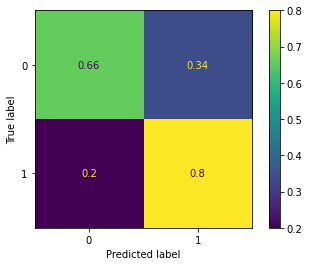

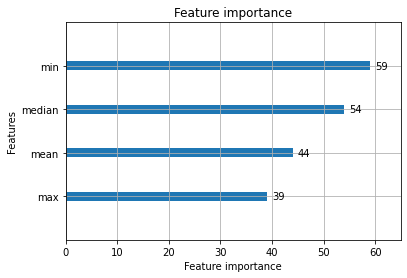

In [21]:
eval_clf(clf_meta_agg, df_test_meta_agg)

## Feature engineering

In [ ]:
POS_TAGS = [
    'ADJ', 'ADP', 'ADV', 'AUX',
    'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON',
    'PROPN', 'PUNCT', 'SCONJ', 'SYM', 
    'VERB', 'X', 'SPACE'
]
POS_TAGS = OrderedDict({ tag: 0 for tag in POS_TAGS })

def extract_tweet_metadata(text: str):
    
    tokens = nlp(text)
    tokens_count = len(tokens)
    
    avg_token_len = 0
    tokens_diff_ratio = []
    pos_tags_count = POS_TAGS.copy()
    
    for token in tokens:
        avg_token_len += len(token)
        tokens_diff_ratio.append(token.text)
        
        try:
            pos_tags_count[token.pos_] += 1
        except KeyError:
            print(token.pos_, "not in POS_TAGS")
        
    try:
        avg_token_len = avg_token_len / tokens_count
        tokens_diff_ratio = len(set(tokens_diff_ratio)) / tokens_count
    except ZeroDivisionError:
        tokens_diff_ratio = 0
            
    return tokens_count, avg_token_len, tokens_diff_ratio, *pos_tags_count.values()


def get_tweet_metadata(df: pd.DataFrame):
    new_cols = [ 'tokens_count', 'avg_token_len', 'tokens_diff_ratio' ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_tweet_metadata).to_list(), 
        columns=new_cols
    )
    return df

In [15]:
# Pretty long (4h on my pc)
df_train_fe = get_tweet_metadata(df_train)
df_test_fe = get_tweet_metadata(df_test)
df_train_fe.head()

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

,id,screen_name,location,followers_count,friends_count,statuses_count,tweet,label,location_enc,created_at_year,...,num_count,part_count,pron_count,propn_count,punct_count,sconj_count,sym_count,verb_count,x_count,space_count
0,24691376,vangoghmuseum,Amsterdam,1647822,1536,16822,Gustave Courbet was often called 'the most arr...,0,171,2009,...,1,1,1,10,14,0,0,4,0,0
1,259540958,IncredibleCulk,Heading to the corner,808966,146,2223,An animal MackLibs,0,1029,2011,...,0,0,0,1,0,0,0,0,0,0
2,424423803,CyaSteve,"Los Angeles, CA",2551,462,26710,I hope it's 900 gems.,1,1416,2011,...,1,0,2,0,1,0,0,1,0,0
3,281902422,SwatiJaiHind,"New Delhi, India",326003,381,8848,Delhi : Social Welfare Minister AdvRajendraPal...,0,1724,2011,...,0,0,0,7,1,0,0,1,0,0
4,173195708,Nigella_Lawson,London,2672077,872,36654,"I wouldn't even consider going on holiday now,...",0,1381,2010,...,0,1,2,0,1,0,0,4,0,0


In [16]:
df_train_fe.to_csv(PATH.format('train_metadata_fe'))
df_test_fe.to_csv(PATH.format('test_metadata_fe'))

In [22]:
df_train_fe = pd.read_csv(PATH.format('train_metadata_fe'), index_col='Unnamed: 0')
df_test_fe = pd.read_csv(PATH.format('test_metadata_fe'), index_col='Unnamed: 0')

In [23]:
df_train_meta_fe = filter_metadata(df_train_fe)
df_test_meta_fe = filter_metadata(df_test_fe)

# Adding engineered features from df_users
df_train_meta_fe = add_avg(df_train_meta_fe)
df_test_meta_fe = add_avg(df_test_meta_fe)

In [24]:
clf_meta_fe = get_best_clf(df_train_meta_fe)

[I 2022-03-29 12:31:09,477] A new study created in memory with name: no-name-905eb79a-f741-48f9-a2a7-997f3f392076


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.938165


[I 2022-03-29 12:33:12,359] Trial 5 finished with value: 0.8374824498754673 and parameters: {'lambda_l1': 1.2409791705317443, 'lambda_l2': 1.5850215247280956e-05, 'num_leaves': 25, 'feature_fraction': 0.48697477786458376, 'bagging_fraction': 0.569839919483849, 'bagging_freq': 5, 'learning_rate': 0.11285829969448646, 'min_child_samples': 88}. Best is trial 5 with value: 0.8374824498754673.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.864411


[I 2022-03-29 12:33:26,834] Trial 0 finished with value: 0.7656275260942493 and parameters: {'lambda_l1': 0.0004409665952879248, 'lambda_l2': 0.0321832564146263, 'num_leaves': 43, 'feature_fraction': 0.9335519990410485, 'bagging_fraction': 0.43910942239981376, 'bagging_freq': 2, 'learning_rate': 0.002106719046302345, 'min_child_samples': 60}. Best is trial 5 with value: 0.8374824498754673.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.874796


[I 2022-03-29 12:33:46,940] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.007649372749158575, 'lambda_l2': 3.0833817700458045e-05, 'num_leaves': 56, 'feature_fraction': 0.6916349495193209, 'bagging_fraction': 0.40821169984536093, 'bagging_freq': 7, 'learning_rate': 7.062523336429437e-05, 'min_child_samples': 5}. Best is trial 5 with value: 0.8374824498754673.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99975
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.91562


[I 2022-03-29 12:34:27,340] Trial 9 finished with value: 0.9929453339366987 and parameters: {'lambda_l1': 1.284437967901849e-07, 'lambda_l2': 0.00010487709077553717, 'num_leaves': 59, 'feature_fraction': 0.4537516202204841, 'bagging_fraction': 0.44816538144080137, 'bagging_freq': 4, 'learning_rate': 0.29679755381494677, 'min_child_samples': 52}. Best is trial 9 with value: 0.9929453339366987.
[I 2022-03-29 12:34:32,798] Trial 8 finished with value: 0.8230960841968409 and parameters: {'lambda_l1': 0.04739050418317637, 'lambda_l2': 2.4378381247133085e-05, 'num_leaves': 73, 'feature_fraction': 0.6274190170814989, 'bagging_fraction': 0.5997599336942739, 'bagging_freq': 5, 'learning_rate': 0.018099295836757696, 'min_child_samples': 38}. Best is trial 9 with value: 0.9929453339366987.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.970108
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 12:35:06,139] Trial 3 finished with value: 0.8769552516487561 and parameters: {'lambda_l1': 0.002081525509451745, 'lambda_l2': 1.3960035902996438e-07, 'num_leaves': 168, 'feature_fraction': 0.46527317332092155, 'bagging_fraction': 0.7273143981356738, 'bagging_freq': 6, 'learning_rate': 0.02227691945417735, 'min_child_samples': 68}. Best is trial 9 with value: 0.9929453339366987.
[I 2022-03-29 12:35:11,518] Trial 4 finished with value: 0.9998797367757668 and parameters: {'lambda_l1': 4.059330087894703e-06, 'lambda_l2': 3.998226523321873e-06, 'num_leaves': 198, 'feature_fraction': 0.7435413488670926, 'bagging_fraction': 0.7446460042572678, 'bagging_freq': 5, 'learning_rate': 0.2945279197311752, 'min_child_samples': 23}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.854486
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:35:23,938] Trial 12 finished with value: 0.7712572626817829 and parameters: {'lambda_l1': 0.004319658576633723, 'lambda_l2': 0.0009355655994149912, 'num_leaves': 13, 'feature_fraction': 0.4217483391896314, 'bagging_fraction': 0.5666912136494592, 'bagging_freq': 5, 'learning_rate': 0.014901502040867454, 'min_child_samples': 26}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.987605
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.985618


[I 2022-03-29 12:35:37,722] Trial 2 finished with value: 0.9146110368298888 and parameters: {'lambda_l1': 1.3703721948820453, 'lambda_l2': 2.8866422984927455e-07, 'num_leaves': 185, 'feature_fraction': 0.6307352258845116, 'bagging_fraction': 0.8941480858304652, 'bagging_freq': 6, 'learning_rate': 0.030271442291889696, 'min_child_samples': 24}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:35:42,726] Trial 7 finished with value: 0.9076514950184187 and parameters: {'lambda_l1': 0.13505874702900053, 'lambda_l2': 8.42356327065989e-08, 'num_leaves': 254, 'feature_fraction': 0.662022492685729, 'bagging_fraction': 0.8314443726062422, 'bagging_freq': 1, 'learning_rate': 0.021005107519762336, 'min_child_samples': 12}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.884108
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:35:53,170] Trial 10 finished with value: 0.8034174250047798 and parameters: {'lambda_l1': 0.0007538981616649946, 'lambda_l2': 0.4757443363728359, 'num_leaves': 84, 'feature_fraction': 0.9488784866653627, 'bagging_fraction': 0.989697517597516, 'bagging_freq': 5, 'learning_rate': 0.0034466292588074573, 'min_child_samples': 75}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.942868
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:36:05,451] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.02373287920942888, 'lambda_l2': 0.33198227651881557, 'num_leaves': 241, 'feature_fraction': 0.45563691956795976, 'bagging_fraction': 0.6294481831689738, 'bagging_freq': 3, 'learning_rate': 1.0394470796102569e-05, 'min_child_samples': 99}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.944395


[I 2022-03-29 12:36:28,175] Trial 13 finished with value: 0.8520692215290171 and parameters: {'lambda_l1': 0.0652048902970933, 'lambda_l2': 0.0007784310417568438, 'num_leaves': 19, 'feature_fraction': 0.42304530150163544, 'bagging_fraction': 0.6537667857187295, 'bagging_freq': 1, 'learning_rate': 0.18117911825832972, 'min_child_samples': 80}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.872737


[I 2022-03-29 12:36:55,311] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.0004089766709965149, 'lambda_l2': 0.00028583434140432506, 'num_leaves': 60, 'feature_fraction': 0.8643647388811537, 'bagging_fraction': 0.8691547966756987, 'bagging_freq': 5, 'learning_rate': 0.0001900787654992413, 'min_child_samples': 47}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.94609


[I 2022-03-29 12:37:38,104] Trial 11 finished with value: 0.8580156708374745 and parameters: {'lambda_l1': 0.02061600244027678, 'lambda_l2': 4.000761978701346e-06, 'num_leaves': 231, 'feature_fraction': 0.7045551432906836, 'bagging_fraction': 0.9938152290166983, 'bagging_freq': 7, 'learning_rate': 0.005960305047495795, 'min_child_samples': 30}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999985
Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1



[I 2022-03-29 12:37:50,557] Trial 19 finished with value: 0.9982110713351398 and parameters: {'lambda_l1': 2.941763489050502e-07, 'lambda_l2': 0.002794131175848931, 'num_leaves': 130, 'feature_fraction': 0.8211976798054291, 'bagging_fraction': 0.7525540637980687, 'bagging_freq': 3, 'learning_rate': 0.16604321342300632, 'min_child_samples': 47}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:37:55,575] Trial 18 finished with value: 0.9998431501627288 and parameters: {'lambda_l1': 2.8561937106234383e-07, 'lambda_l2': 0.001788679509093287, 'num_leaves': 157, 'feature_fraction': 0.8289065037444483, 'bagging_fraction': 0.709002848796831, 'bagging_freq': 3, 'learning_rate': 0.2748156110062864, 'min_child_samples': 46}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.989061


[I 2022-03-29 12:38:21,233] Trial 16 finished with value: 0.9230992382084607 and parameters: {'lambda_l1': 0.010695368593144851, 'lambda_l2': 0.014984423992522228, 'num_leaves': 210, 'feature_fraction': 0.8491679952975957, 'bagging_fraction': 0.7351496529980079, 'bagging_freq': 4, 'learning_rate': 0.027247755746038372, 'min_child_samples': 70}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.999999


[I 2022-03-29 12:38:29,493] Trial 20 finished with value: 0.9996659944947373 and parameters: {'lambda_l1': 9.64533793348909e-07, 'lambda_l2': 2.0816452282097493e-06, 'num_leaves': 118, 'feature_fraction': 0.8098769071278071, 'bagging_fraction': 0.7805211612540496, 'bagging_freq': 3, 'learning_rate': 0.29995755734096374, 'min_child_samples': 46}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.946993
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999992
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:38:43,644] Trial 14 finished with value: 0.5332820887104296 and parameters: {'lambda_l1': 0.0009020390765592415, 'lambda_l2': 1.8758174425038473e-07, 'num_leaves': 251, 'feature_fraction': 0.42319900620670275, 'bagging_fraction': 0.9037835017060047, 'bagging_freq': 1, 'learning_rate': 0.0009817683474337192, 'min_child_samples': 59}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:38:48,829] Trial 21 finished with value: 0.9984813555901687 and parameters: {'lambda_l1': 2.692307192645508e-07, 'lambda_l2': 2.0776447280624495e-06, 'num_leaves': 118, 'feature_fraction': 0.803870161262039, 'bagging_fraction': 0.7517042168115318, 'bagging_freq': 3, 'learning_rate': 0.20598924625252313, 'min_child_samples': 44}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.921258


[I 2022-03-29 12:38:56,738] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 9.138782983411029e-07, 'lambda_l2': 6.678051030828009, 'num_leaves': 243, 'feature_fraction': 0.8718662679211016, 'bagging_fraction': 0.9983759102940075, 'bagging_freq': 3, 'learning_rate': 6.413911500164868e-05, 'min_child_samples': 41}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:39:41,434] Trial 22 finished with value: 0.9996875920134658 and parameters: {'lambda_l1': 3.228564351801271e-07, 'lambda_l2': 1.2588481959156681e-08, 'num_leaves': 123, 'feature_fraction': 0.7989129288163836, 'bagging_fraction': 0.7451913354072819, 'bagging_freq': 3, 'learning_rate': 0.28963893034680765, 'min_child_samples': 53}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999256


[I 2022-03-29 12:40:01,227] Trial 23 finished with value: 0.9807304265055706 and parameters: {'lambda_l1': 2.1836210481094797e-06, 'lambda_l2': 0.010035864560651819, 'num_leaves': 130, 'feature_fraction': 0.7934210132704579, 'bagging_fraction': 0.7636510532035916, 'bagging_freq': 3, 'learning_rate': 0.08399106101408105, 'min_child_samples': 43}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.920245


[I 2022-03-29 12:40:32,030] Trial 24 finished with value: 0.5 and parameters: {'lambda_l1': 7.954311721543081e-06, 'lambda_l2': 0.012863798664398005, 'num_leaves': 193, 'feature_fraction': 0.7851495053321186, 'bagging_fraction': 0.7865417806556003, 'bagging_freq': 3, 'learning_rate': 0.000602061487782571, 'min_child_samples': 17}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.906112


[I 2022-03-29 12:40:38,616] Trial 25 finished with value: 0.5 and parameters: {'lambda_l1': 6.819448509229901e-06, 'lambda_l2': 5.207965665553473, 'num_leaves': 142, 'feature_fraction': 0.773536693638211, 'bagging_fraction': 0.7932414875747246, 'bagging_freq': 3, 'learning_rate': 0.000535732856502472, 'min_child_samples': 17}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.911502
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:40:50,112] Trial 26 finished with value: 0.5 and parameters: {'lambda_l1': 9.363465729436526e-06, 'lambda_l2': 0.015221740802651528, 'num_leaves': 155, 'feature_fraction': 0.7625132699379891, 'bagging_fraction': 0.5231822048655514, 'bagging_freq': 2, 'learning_rate': 0.0008583380968338236, 'min_child_samples': 18}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998564
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998069


[I 2022-03-29 12:41:00,933] Trial 29 finished with value: 0.9719107831010777 and parameters: {'lambda_l1': 1.1641198352644396e-05, 'lambda_l2': 1.6892377453019385e-06, 'num_leaves': 136, 'feature_fraction': 0.7516584788471149, 'bagging_fraction': 0.8039212112594051, 'bagging_freq': 2, 'learning_rate': 0.06746314637842221, 'min_child_samples': 34}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:41:01,058] Trial 27 finished with value: 0.9668380413888336 and parameters: {'lambda_l1': 8.316496293661676e-06, 'lambda_l2': 0.017537609954023845, 'num_leaves': 153, 'feature_fraction': 0.7635141977723952, 'bagging_fraction': 0.6753019458061321, 'bagging_freq': 4, 'learning_rate': 0.057101222859288134, 'min_child_samples': 17}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999858
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



[I 2022-03-29 12:41:17,729] Trial 28 finished with value: 0.9921064359204962 and parameters: {'lambda_l1': 7.1160773623772416e-06, 'lambda_l2': 1.0975433720668469e-08, 'num_leaves': 158, 'feature_fraction': 0.7690758071530989, 'bagging_fraction': 0.7971775095387683, 'bagging_freq': 2, 'learning_rate': 0.08875473640305295, 'min_child_samples': 37}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999536


[I 2022-03-29 12:42:08,315] Trial 30 finished with value: 0.9852012506405042 and parameters: {'lambda_l1': 1.5376436480148526e-05, 'lambda_l2': 0.009285332659370215, 'num_leaves': 157, 'feature_fraction': 0.7540746317358755, 'bagging_fraction': 0.6783982766209726, 'bagging_freq': 2, 'learning_rate': 0.07455009570280666, 'min_child_samples': 17}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995753


[I 2022-03-29 12:42:38,096] Trial 31 finished with value: 0.9515725471838706 and parameters: {'lambda_l1': 1.2121235540991515e-08, 'lambda_l2': 2.4474147499420904e-08, 'num_leaves': 163, 'feature_fraction': 0.7408725275608715, 'bagging_fraction': 0.6710370460792806, 'bagging_freq': 2, 'learning_rate': 0.04706471389839533, 'min_child_samples': 19}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902681


[I 2022-03-29 12:42:47,124] Trial 36 finished with value: 0.8231667061698628 and parameters: {'lambda_l1': 1.750705231681158e-08, 'lambda_l2': 1.6506386188314724e-08, 'num_leaves': 97, 'feature_fraction': 0.9121734076939814, 'bagging_fraction': 0.7034976052310074, 'bagging_freq': 4, 'learning_rate': 0.007640006941824225, 'min_child_samples': 58}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.975404Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995671
Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.988338


[I 2022-03-29 12:43:02,048] Trial 37 finished with value: 0.8892249946501909 and parameters: {'lambda_l1': 1.0719577786557328e-08, 'lambda_l2': 1.627618543983673e-08, 'num_leaves': 95, 'feature_fraction': 0.9036396204471292, 'bagging_fraction': 0.7049658833852439, 'bagging_freq': 4, 'learning_rate': 0.04326840224756484, 'min_child_samples': 60}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:43:02,160] Trial 34 finished with value: 0.952697760769668 and parameters: {'lambda_l1': 1.0419689819054003e-08, 'lambda_l2': 2.202956868971701e-08, 'num_leaves': 107, 'feature_fraction': 0.9870831997093712, 'bagging_fraction': 0.6815920285740998, 'bagging_freq': 2, 'learning_rate': 0.06441850059819923, 'min_child_samples': 34}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:43:02,162] Trial 35 finished with value: 0.9222639122502606 and parameters: {'lambda_l1': 1.4452244647327557e-08, 'lambda_l2': 2.15544515451111e-08, 'num_leaves': 103, 'feature_fraction': 0.9

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999041
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99933
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:43:29,542] Trial 32 finished with value: 0.9774449315070695 and parameters: {'lambda_l1': 1.0607623241808177e-08, 'lambda_l2': 2.7692051950181837e-08, 'num_leaves': 158, 'feature_fraction': 0.7281598916468494, 'bagging_fraction': 0.6863089553646041, 'bagging_freq': 2, 'learning_rate': 0.06285455839523774, 'min_child_samples': 59}. Best is trial 4 with value: 0.9998797367757668.
[I 2022-03-29 12:43:30,506] Trial 33 finished with value: 0.9811932258893341 and parameters: {'lambda_l1': 1.218972253603039e-08, 'lambda_l2': 1.510601272914639e-08, 'num_leaves': 160, 'feature_fraction': 0.7289895077049534, 'bagging_fraction': 0.6722368155453404, 'bagging_freq': 2, 'learning_rate': 0.06883994579587853, 'min_child_samples': 59}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:44:22,842] Trial 38 finished with value: 0.9996377885515891 and parameters: {'lambda_l1': 1.1714538515003597e-08, 'lambda_l2': 1.1871321082261048e-08, 'num_leaves': 103, 'feature_fraction': 0.9037405724597823, 'bagging_fraction': 0.698135073048134, 'bagging_freq': 4, 'learning_rate': 0.2957745803605854, 'min_child_samples': 57}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.999981


[I 2022-03-29 12:44:47,701] Trial 39 finished with value: 0.9995170447698939 and parameters: {'lambda_l1': 7.212444483486473e-05, 'lambda_l2': 7.330942000107123e-07, 'num_leaves': 109, 'feature_fraction': 0.8932478332839462, 'bagging_fraction': 0.7134479062282956, 'bagging_freq': 4, 'learning_rate': 0.2826047312854121, 'min_child_samples': 57}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:44:59,971] Trial 40 finished with value: 0.9996698894554371 and parameters: {'lambda_l1': 6.333014124833731e-08, 'lambda_l2': 6.638707033893729e-07, 'num_leaves': 113, 'feature_fraction': 0.8947086338223946, 'bagging_fraction': 0.8492088102134419, 'bagging_freq': 4, 'learning_rate': 0.2911958132544384, 'min_child_samples': 53}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999998


[I 2022-03-29 12:45:07,861] Trial 41 finished with value: 0.9994450530407982 and parameters: {'lambda_l1': 4.735068487980014e-05, 'lambda_l2': 5.5529729385384494e-06, 'num_leaves': 109, 'feature_fraction': 0.9821891114030525, 'bagging_fraction': 0.849628736559451, 'bagging_freq': 6, 'learning_rate': 0.2755742954657093, 'min_child_samples': 29}. Best is trial 4 with value: 0.9998797367757668.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:45:48,957] Trial 44 finished with value: 0.9989879208632049 and parameters: {'lambda_l1': 0.00010866098535740414, 'lambda_l2': 6.570426173391153e-06, 'num_leaves': 180, 'feature_fraction': 0.8360401525895031, 'bagging_fraction': 0.8665587350963064, 'bagging_freq': 6, 'learning_rate': 0.1497886386125783, 'min_child_samples': 65}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999994


[I 2022-03-29 12:45:57,509] Trial 43 finished with value: 0.9986876584195575 and parameters: {'lambda_l1': 7.732396613826633e-05, 'lambda_l2': 5.694952892461944e-07, 'num_leaves': 183, 'feature_fraction': 0.5785682892813289, 'bagging_fraction': 0.8490321165103548, 'bagging_freq': 6, 'learning_rate': 0.1371176053739328, 'min_child_samples': 51}. Best is trial 4 with value: 0.9998797367757668.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:46:06,999] Trial 42 finished with value: 0.9999052292551953 and parameters: {'lambda_l1': 7.831559093358174e-05, 'lambda_l2': 5.395608550448875e-06, 'num_leaves': 184, 'feature_fraction': 0.5607764241904563, 'bagging_fraction': 0.8591637004878071, 'bagging_freq': 6, 'learning_rate': 0.2931668689825694, 'min_child_samples': 67}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 12:46:28,029] Trial 45 finished with value: 0.9998515308326186 and parameters: {'lambda_l1': 5.3270928867836065e-05, 'lambda_l2': 9.558493355735876e-07, 'num_leaves': 181, 'feature_fraction': 0.6105719939970771, 'bagging_fraction': 0.8449426383109704, 'bagging_freq': 6, 'learning_rate': 0.299331319408263, 'min_child_samples': 68}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999991


[I 2022-03-29 12:46:42,283] Trial 46 finished with value: 0.9986542658277012 and parameters: {'lambda_l1': 3.930392094646971e-05, 'lambda_l2': 8.639311825117981e-07, 'num_leaves': 177, 'feature_fraction': 0.5842759083018475, 'bagging_fraction': 0.6190746603654829, 'bagging_freq': 6, 'learning_rate': 0.14249956404617098, 'min_child_samples': 65}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999997


[I 2022-03-29 12:47:11,460] Trial 48 finished with value: 0.9992585555879928 and parameters: {'lambda_l1': 5.7961526564537534e-08, 'lambda_l2': 4.786822833987481e-06, 'num_leaves': 185, 'feature_fraction': 0.8301829416390859, 'bagging_fraction': 0.8441901752329249, 'bagging_freq': 3, 'learning_rate': 0.1398724160652819, 'min_child_samples': 66}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 12:47:22,825] Trial 47 finished with value: 0.9991559949217883 and parameters: {'lambda_l1': 5.9554383031229176e-08, 'lambda_l2': 6.202155853406192e-05, 'num_leaves': 186, 'feature_fraction': 0.5656205600744096, 'bagging_fraction': 0.6230944043915436, 'bagging_freq': 6, 'learning_rate': 0.15352098456909985, 'min_child_samples': 52}. Best is trial 42 with value: 0.9999052292551953.
[I 2022-03-29 12:47:22,903] Trial 49 finished with value: 0.9994509406290245 and parameters: {'lambda_l1': 7.992499486925181e-08, 'lambda_l2': 3.5148753784790083e-07, 'num_leaves': 188, 'feature_fraction': 0.8351230068449026, 'bagging_fraction': 0.9158063032481815, 'bagging_freq': 3, 'learning_rate': 0.15438480825266745, 'min_child_samples': 48}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:48:22,627] Trial 51 finished with value: 0.9989588838928355 and parameters: {'lambda_l1': 1.005974658906967e-07, 'lambda_l2': 9.274241966051357e-08, 'num_leaves': 208, 'feature_fraction': 0.9455460806528507, 'bagging_fraction': 0.9250534467075618, 'bagging_freq': 3, 'learning_rate': 0.12152498371486006, 'min_child_samples': 6}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 12:48:52,590] Trial 50 finished with value: 0.9992438067724144 and parameters: {'lambda_l1': 6.981821431570586e-08, 'lambda_l2': 5.037160865575377e-07, 'num_leaves': 204, 'feature_fraction': 0.6435899653823522, 'bagging_fraction': 0.920786628710228, 'bagging_freq': 3, 'learning_rate': 0.13026357562438867, 'min_child_samples': 51}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999991


[I 2022-03-29 12:49:02,983] Trial 53 finished with value: 0.9985701086590438 and parameters: {'lambda_l1': 5.484987221668251, 'lambda_l2': 9.9259989478614e-05, 'num_leaves': 208, 'feature_fraction': 0.5592235711631827, 'bagging_fraction': 0.928538742570843, 'bagging_freq': 7, 'learning_rate': 0.13451677046023255, 'min_child_samples': 88}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.96204


[I 2022-03-29 12:49:16,927] Trial 54 finished with value: 0.8670699026012034 and parameters: {'lambda_l1': 1.0231293943571602e-06, 'lambda_l2': 8.118261475502112e-05, 'num_leaves': 204, 'feature_fraction': 0.5277470026172739, 'bagging_fraction': 0.9335877143491635, 'bagging_freq': 7, 'learning_rate': 0.01254240292635624, 'min_child_samples': 87}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 12:49:25,663] Trial 52 finished with value: 0.9990345502005749 and parameters: {'lambda_l1': 6.903429345274767e-08, 'lambda_l2': 6.969257493009016e-05, 'num_leaves': 212, 'feature_fraction': 0.5999732870022654, 'bagging_fraction': 0.9417644108501817, 'bagging_freq': 7, 'learning_rate': 0.1357744638860708, 'min_child_samples': 91}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990569


[I 2022-03-29 12:49:57,504] Trial 55 finished with value: 0.9222106086466935 and parameters: {'lambda_l1': 2.3072092832481146e-06, 'lambda_l2': 6.613560822809548e-05, 'num_leaves': 217, 'feature_fraction': 0.5217438211442998, 'bagging_fraction': 0.9234249513373738, 'bagging_freq': 7, 'learning_rate': 0.029692038700588914, 'min_child_samples': 82}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.961292


[I 2022-03-29 12:50:05,365] Trial 56 finished with value: 0.8653947389271852 and parameters: {'lambda_l1': 2.0868670527324732e-06, 'lambda_l2': 0.0002549969117450328, 'num_leaves': 208, 'feature_fraction': 0.5209277473301125, 'bagging_fraction': 0.9262006817239284, 'bagging_freq': 7, 'learning_rate': 0.011496233182994428, 'min_child_samples': 86}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.966492
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:50:17,980] Trial 57 finished with value: 0.8715220048917937 and parameters: {'lambda_l1': 1.5266918257866696e-06, 'lambda_l2': 7.608940493232036e-08, 'num_leaves': 224, 'feature_fraction': 0.5303907401243574, 'bagging_fraction': 0.9462358561019601, 'bagging_freq': 7, 'learning_rate': 0.012167455281326298, 'min_child_samples': 91}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.918665


[I 2022-03-29 12:50:37,961] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 1.435141015607484e-06, 'lambda_l2': 1.1192946188384266e-05, 'num_leaves': 171, 'feature_fraction': 0.634965013113223, 'bagging_fraction': 0.8170544229671045, 'bagging_freq': 7, 'learning_rate': 2.1627640370699885e-05, 'min_child_samples': 79}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 12:51:08,016] Trial 60 finished with value: 0.9992092326835778 and parameters: {'lambda_l1': 8.570578383747481e-07, 'lambda_l2': 1.8138537721874038e-05, 'num_leaves': 143, 'feature_fraction': 0.5349284696452912, 'bagging_fraction': 0.8177446286847313, 'bagging_freq': 5, 'learning_rate': 0.2164587808851469, 'min_child_samples': 78}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.970209
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.90886
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 12:51:47,112] Trial 59 finished with value: 0.8754556259375377 and parameters: {'lambda_l1': 2.6162053503285427e-06, 'lambda_l2': 1.46299350959794e-05, 'num_leaves': 231, 'feature_fraction': 0.549227200677974, 'bagging_fraction': 0.7340084143809841, 'bagging_freq': 7, 'learning_rate': 0.01364437106348653, 'min_child_samples': 84}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.931257


[I 2022-03-29 12:51:53,728] Trial 61 finished with value: 0.999761005518273 and parameters: {'lambda_l1': 2.0145812508053396e-06, 'lambda_l2': 1.5821825521426777e-05, 'num_leaves': 230, 'feature_fraction': 0.676031328471803, 'bagging_fraction': 0.9664542718325224, 'bagging_freq': 5, 'learning_rate': 0.20434289651469598, 'min_child_samples': 74}. Best is trial 42 with value: 0.9999052292551953.
[I 2022-03-29 12:51:54,810] Trial 63 finished with value: 0.5 and parameters: {'lambda_l1': 3.102693538110814e-07, 'lambda_l2': 1.4551294463215657e-05, 'num_leaves': 145, 'feature_fraction': 0.6973360546756545, 'bagging_fraction': 0.8797948503223652, 'bagging_freq': 5, 'learning_rate': 1.0135170792764309e-05, 'min_child_samples': 70}. Best is trial 42 with value: 0.9999052292551953.
[I 2022-03-29 12:52:05,217] Trial 62 finished with value: 0.5 and parameters: {'lambda_l1': 2.5713790429535178e-06, 'lambda_l2': 1.0696174479993654e-05, 'num_leaves': 227, 'feature_fraction': 0.6864476748929429, 'bagg

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 12:52:23,874] Trial 65 finished with value: 0.9998147039408497 and parameters: {'lambda_l1': 3.410795664572892e-07, 'lambda_l2': 1.7647985185280722e-05, 'num_leaves': 171, 'feature_fraction': 0.6838160057303385, 'bagging_fraction': 0.8158875682370149, 'bagging_freq': 5, 'learning_rate': 0.23402580130444658, 'min_child_samples': 73}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:52:33,537] Trial 66 finished with value: 0.999407635400539 and parameters: {'lambda_l1': 3.540438961120369e-07, 'lambda_l2': 0.10734343053452758, 'num_leaves': 144, 'feature_fraction': 0.6958685964765986, 'bagging_fraction': 0.8836137106611666, 'bagging_freq': 5, 'learning_rate': 0.22420380567826229, 'min_child_samples': 72}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 12:52:50,638] Trial 64 finished with value: 0.9998102182316597 and parameters: {'lambda_l1': 2.8473774588305055e-07, 'lambda_l2': 1.6362646034882952e-07, 'num_leaves': 230, 'feature_fraction': 0.6665875341328935, 'bagging_fraction': 0.7309012533968062, 'bagging_freq': 5, 'learning_rate': 0.20965613539024358, 'min_child_samples': 76}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999989


[I 2022-03-29 12:53:05,625] Trial 67 finished with value: 0.9988873727212018 and parameters: {'lambda_l1': 0.0001797807200252194, 'lambda_l2': 0.0011848681652418453, 'num_leaves': 122, 'feature_fraction': 0.6694512379573482, 'bagging_fraction': 0.7370358308934728, 'bagging_freq': 5, 'learning_rate': 0.21477363299945548, 'min_child_samples': 70}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999719


[I 2022-03-29 12:53:27,261] Trial 68 finished with value: 0.9909005897603075 and parameters: {'lambda_l1': 3.6776258696654354e-07, 'lambda_l2': 1.6147511843284566e-06, 'num_leaves': 74, 'feature_fraction': 0.682924296413062, 'bagging_fraction': 0.7731948366744702, 'bagging_freq': 5, 'learning_rate': 0.20405939616437432, 'min_child_samples': 74}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 12:53:56,249] Trial 71 finished with value: 0.9992113553988073 and parameters: {'lambda_l1': 3.9890244949024435e-07, 'lambda_l2': 0.0017023582525079045, 'num_leaves': 121, 'feature_fraction': 0.8705286857541895, 'bagging_fraction': 0.965935715920244, 'bagging_freq': 5, 'learning_rate': 0.21376250428991045, 'min_child_samples': 74}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999999


[I 2022-03-29 12:54:18,756] Trial 70 finished with value: 0.9996768483496157 and parameters: {'lambda_l1': 2.1356386049478123e-07, 'lambda_l2': 0.0029552711859370724, 'num_leaves': 196, 'feature_fraction': 0.6858074186260531, 'bagging_fraction': 0.7652753228158826, 'bagging_freq': 5, 'learning_rate': 0.20480591032880302, 'min_child_samples': 72}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 12:54:30,906] Trial 69 finished with value: 0.9997703274064119 and parameters: {'lambda_l1': 4.236225446437082e-07, 'lambda_l2': 0.0034933400163690937, 'num_leaves': 198, 'feature_fraction': 0.6661218382039498, 'bagging_fraction': 0.770970819260679, 'bagging_freq': 5, 'learning_rate': 0.2156339552889422, 'min_child_samples': 74}. Best is trial 42 with value: 0.9999052292551953.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999961


[I 2022-03-29 12:54:47,631] Trial 72 finished with value: 0.9956923433470222 and parameters: {'lambda_l1': 5.358218210932762e-07, 'lambda_l2': 0.0009030569207188309, 'num_leaves': 197, 'feature_fraction': 0.667647615171922, 'bagging_fraction': 0.9668135438474863, 'bagging_freq': 5, 'learning_rate': 0.09712198782339385, 'min_child_samples': 74}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.931121


[I 2022-03-29 12:54:52,374] Trial 73 finished with value: 0.8178846036148482 and parameters: {'lambda_l1': 0.00028784959824187787, 'lambda_l2': 0.0012722169973052398, 'num_leaves': 198, 'feature_fraction': 0.6669621438707977, 'bagging_fraction': 0.7703996630460431, 'bagging_freq': 6, 'learning_rate': 0.0021022794392701162, 'min_child_samples': 62}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999981


[I 2022-03-29 12:55:25,589] Trial 75 finished with value: 0.9974451858529814 and parameters: {'lambda_l1': 2.5084779064717884e-05, 'lambda_l2': 3.683505267601096e-05, 'num_leaves': 248, 'feature_fraction': 0.6099095632905956, 'bagging_fraction': 0.9725493787156644, 'bagging_freq': 6, 'learning_rate': 0.08459514428936966, 'min_child_samples': 76}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999991


[I 2022-03-29 12:55:28,689] Trial 76 finished with value: 0.9983733480998501 and parameters: {'lambda_l1': 0.0009273746541035407, 'lambda_l2': 1.7798252806072283e-07, 'num_leaves': 243, 'feature_fraction': 0.7166340616583275, 'bagging_fraction': 0.7637473963692812, 'bagging_freq': 6, 'learning_rate': 0.09205427465344727, 'min_child_samples': 63}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999991


[I 2022-03-29 12:55:35,503] Trial 74 finished with value: 0.9982100000291876 and parameters: {'lambda_l1': 0.00025451653936974644, 'lambda_l2': 0.0016469818525309651, 'num_leaves': 247, 'feature_fraction': 0.6665533101122787, 'bagging_fraction': 0.7779953982475492, 'bagging_freq': 6, 'learning_rate': 0.09650037903492785, 'min_child_samples': 68}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999985


[I 2022-03-29 12:55:45,039] Trial 77 finished with value: 0.9978751634967037 and parameters: {'lambda_l1': 2.226385974667219e-05, 'lambda_l2': 2.1215597348427597e-07, 'num_leaves': 241, 'feature_fraction': 0.6192971952436442, 'bagging_fraction': 0.7642768033113029, 'bagging_freq': 6, 'learning_rate': 0.09417712193054224, 'min_child_samples': 62}. Best is trial 42 with value: 0.9999052292551953.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999994


[I 2022-03-29 12:55:50,225] Trial 79 finished with value: 0.9985423633766829 and parameters: {'lambda_l1': 2.668041132882397e-05, 'lambda_l2': 0.00047567981191785696, 'num_leaves': 247, 'feature_fraction': 0.6552578270153588, 'bagging_fraction': 0.6523871782456724, 'bagging_freq': 6, 'learning_rate': 0.09737257858675771, 'min_child_samples': 62}. Best is trial 42 with value: 0.9999052292551953.
[I 2022-03-29 12:55:51,166] Trial 78 finished with value: 0.9985081397576054 and parameters: {'lambda_l1': 1.911337498610208e-05, 'lambda_l2': 2.9504926822149205e-06, 'num_leaves': 252, 'feature_fraction': 0.6074758653038974, 'bagging_fraction': 0.7553745115574947, 'bagging_freq': 6, 'learning_rate': 0.10070264441047211, 'min_child_samples': 77}. Best is trial 42 with value: 0.9999052292551953.


KeyboardInterrupt: 

In [ ]:
eval_clf(clf_meta_fe, df_test_meta_fe)

### Average probas at the user level

In [ ]:
df_train_meta_fe_agg, df_test_meta_fe_agg = get_agg(clf_meta_fe, 
                                                    df_train_meta_fe, 
                                                    df_test_meta_fe, 
                                                    df_train['id'], 
                                                    df_test['id'])
clf_meta_fe_agg = get_best_clf(df_train_meta_fe_agg)

In [ ]:
eval_clf(clf_meta_fe_agg, df_test_meta_fe_agg)

# Detection on tweets metadata (but not users')

In [ ]:
def filter_tweet_metadata(df: pd.DataFrame):
    return df.drop([ 'followers_count', 'friends_count', 'statuses_count',
                     'location_enc', 'created_at_date', 'created_at_year',
                     'created_at_month', 'created_at_day', 'created_at_hour', 
                     'avg_daily_followers', 'avg_daily_friends', 'avg_daily_statuses'], axis=1)

In [ ]:
df_train_meta_tweet = filter_tweet_metadata(df_train_meta)
df_test_meta_tweet = filter_tweet_metadata(df_test_meta)

In [ ]:
clf_meta_tweet = get_best_clf(df_train_meta_tweet)

In [ ]:
eval_clf(clf_meta_tweet, df_test_meta_tweet)

### Average probas at the user level

In [ ]:
df_train_meta_agg_tweet, df_test_meta_agg_tweet = get_agg(clf_meta_tweet, 
                                                          df_train_meta_tweet, 
                                                          df_test_meta_tweet, 
                                                          df_train['id'], 
                                                          df_test['id'])
clf_meta_agg_tweet = get_best_clf(df_train_meta_agg_tweet)

In [ ]:
eval_clf(clf_meta_agg_tweet, df_test_meta_agg_tweet)

## Feature engineering

In [ ]:
df_train_meta_tweet_fe = filter_tweet_metadata(df_train_meta_fe)
df_test_meta_tweet_fe = filter_tweet_metadata(df_test_meta_fe)

In [ ]:
clf_meta_tweet_fe = get_best_clf(df_train_meta_tweet_fe)

In [ ]:
eval_clf(clf_meta_tweet_fe, df_test_meta_tweet_fe)

### Average probas at the user level

In [ ]:
df_train_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe = get_agg(clf_meta_tweet_fe, 
                                                                df_train_meta_tweet_fe, 
                                                                df_test_meta_tweet_fe, 
                                                                df_train['id'], 
                                                                df_test['id'])
clf_meta_agg_tweet_fe = get_best_clf(df_train_meta_agg_tweet_fe)

In [ ]:
eval_clf(clf_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe)

# TODO: Combine models on users metadata + tweets metadata

# Detection on tweets content

In [ ]:
X_train_tweet, y_train_tweet = df_train['tweet'], df_train['label']
X_test_tweet, y_test_tweet = df_test['tweet'], df_test['label']

X_train_tweet.head()

## Encoding hashtags

> __Meh__

In [7]:
hashtags_count = []
for _, hashtags in tqdm(df_train['hashtags'].iteritems(), total=len(df_train)):
    hashtags_count += hashtags
hashtags_count = Counter(hashtags_count)
hashtags_count

  0%|          | 0/1398465 [00:00<?, ?it/s]

Counter({'Sponsored': 39,
         'HandShaq': 1,
         'ad': 465,
         'lsunationalchamps': 1,
         'WeWantToPlay': 22,
         'SharkWeek': 124,
         'LeadingThroughChange': 2,
         'MyStartingFive': 4,
         'SHAQvsGRONK': 1,
         'fortopartner': 2,
         'ShotForHeroes': 1,
         'sanitation': 5,
         'NRGFAM': 14,
         'BETAwards': 52,
         'BiteSizedGlory': 1,
         'GeauxTigers': 62,
         'frostedflakespartner': 1,
         'RingPartner': 1,
         'healthcareheroes': 19,
         'ShareMyHero': 1,
         'jcppartner': 1,
         'shaqlife': 4,
         'TNTpartner': 4,
         'MothersDay': 87,
         'FastFoto': 2,
         'FastFotoSweepstakes': 1,
         'EpsonPartner': 1,
         'NFLdraft': 2,
         'Shaqcast': 1,
         'Prince': 13,
         'HatsOff': 2,
         'JCPpartner': 1,
         'throwback': 80,
         'TNTPartner': 1,
         'PapaJohnsPartner': 1,
         'PostForPencils': 1,
         'S

In [8]:
hashtags_best = hashtags_count.most_common()
hashtags_best_label = [ c[0] for c in hashtags_best ]
hashtags_best_count = [ c[1] for c in hashtags_best ]

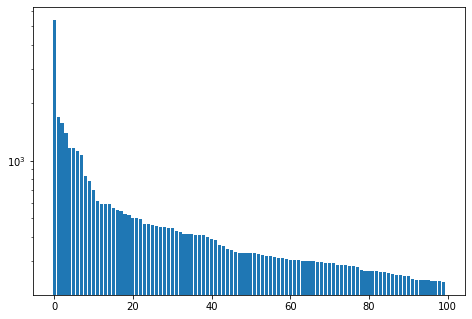

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
langs = list(range(100))
students = hashtags_best_count[:100]
ax.bar(langs,students)
plt.show()

In [ ]:
lim = 41
hashtags_best_label = hashtags_best_label[:lim]

> __Wouldn't it be smarter to use hashtags from the Ukraine dataset?__

In [21]:
# To remove if above cells are unfrozen
hashtags_best_label = [ ht for ht, c in hashtags_count.items() if c > 10 ]
len(hashtags_best_label)

8268

In [22]:
hashtags_filtered = { ht: i for i, ht in enumerate(hashtags_best_label) }

def encode_hashtag(hashtags: list):
    most_common = None
    for ht in hashtags:
        if ht in hashtags_filtered:
            i = hashtags_filtered[ht]
            if most_common is None or i < most_common:
                most_common = i
    if most_common is None:
        most_common = np.nan
    return most_common

df_train['hashtags_enc'] = df_train['hashtags'].apply(encode_hashtag)
df_test['hashtags_enc'] = df_test['hashtags'].apply(encode_hashtag)
print(round(100 * df_train['hashtags_enc'].count() / len(df_train['hashtags_enc']), 3), "%")
df_train['hashtags_enc'].head()

13.578 %


0    NaN
1    NaN
2    0.0
3    1.0
4    NaN
Name: hashtags_enc, dtype: float64

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
#TODO preprocess the corpus using spacy or load the pre-processed corpus

def preprocess(text, nlp=nlp):
    return [
        token for token in nlp(text)
        if not token.is_punct and not token.is_stop
    ]

df['text_clean'] = df['text'].progress_apply(preprocess)
df['text_clean'].head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(dfs['text'])

In [ ]:
from gensim.models import Word2Vec

##TODO train a word2vec model on this dataset, only consider words which appear at least 10 times in the corpus
w2v = Word2Vec(dataset, min_count=10)

In [ ]:
text = extract_artefacts(df_train.iloc[0]['tweet'])[0]
text

> Doc2Vec

In [ ]:
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc = [TaggedDocument(word_tokenize(text), [0])]
d2v = Doc2Vec(doc,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size
                     
D = d2v.docvecs.vectors_docs

> SpaCy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

nlp(text).vector

> Tensorflow

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [ ]:
embeddings = model(text)

with tf.Session() as session:
    session.run([ tf.global_variables_initializer(), tf.tables_initializer() ])
    text_encoded = session.run(embeddings)

> Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)

In [ ]:
text_encoded = embedder.encode(text)
text_encoded

# Train final model on several subsample of data (change proportion of bots in dataset)